# #9 : Bayes Statistical Inference using JAGS package

In [1]:
library(readxl)
library(tidyverse)
library(rjags)
library(runjags)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang

Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2

-- Attaching packages --------------------------------------- tidyverse 1.2.1 --

√ ggplot2 3.1.1       √ purrr   0.3.4  
√ tibble  2.1.1       √ dplyr   0.8.0.1
√ tidyr   0.8.3       √ stringr 1.4.0  
√ readr   1.3.1       √ forcats 0.4.0  

Warning message:
"package 'purrr' was built under R version 3.6.3"
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter()  masks stats::filter()
x purrr::flatten() masks jsonlite::flatten()
x dplyr::lag()     masks stats::lag()

Warning message:
"package 'rjags' was built under R version 3.6.3"
Loading required package: coda

Warning message:
"package 'coda' was built under R version 3.6.3"
Linked to JAGS 4.3.0

Loaded modules: basemod,bugs

Warning message:
"package 'run

## Part 1. Alzheimer 치료제 (lecithin) 효과 검증 임상시험 

첨부된 자료는 n=47 명의 Alzheimer 환자에 대해 치료제 lecithin을 첨가한 식이요법의 효과를 검증하기 위한 임상 실험(Clinical Trial) 결과이다. 환자들을 가짜 약 (placebo) 그룹과 lecithin 처방 그룹으로 랜덤하게 할당한 결과 각각 $n_1 = 26, n_2 = 22$ 명의 환자가 배당 되었다.         
이들 환자에 대해 시간이 따른 기억력 변화를 객관적으로 측정하기 위해 MMSE (Mini Mental Status Exam) 점수를 약 처방 이전 일회 그리고 처방 후 매월 한번씩 4개월간 총 5번 측정하였다. (MMSE은 기억력, 판단력 등을 측정하는 표준화된 테스트로 총 30문항의 30점 만점으로 20점 이하는 치매 발병 의심 판정기준으로 사용함)

In [2]:
alz <- read_xlsx('Alzheimer.xlsx',sheet=1)

### (a) (t,y) 산점도를 통해 두 그룹간의 시간에 따른 MMSE 점수 추세 비교 

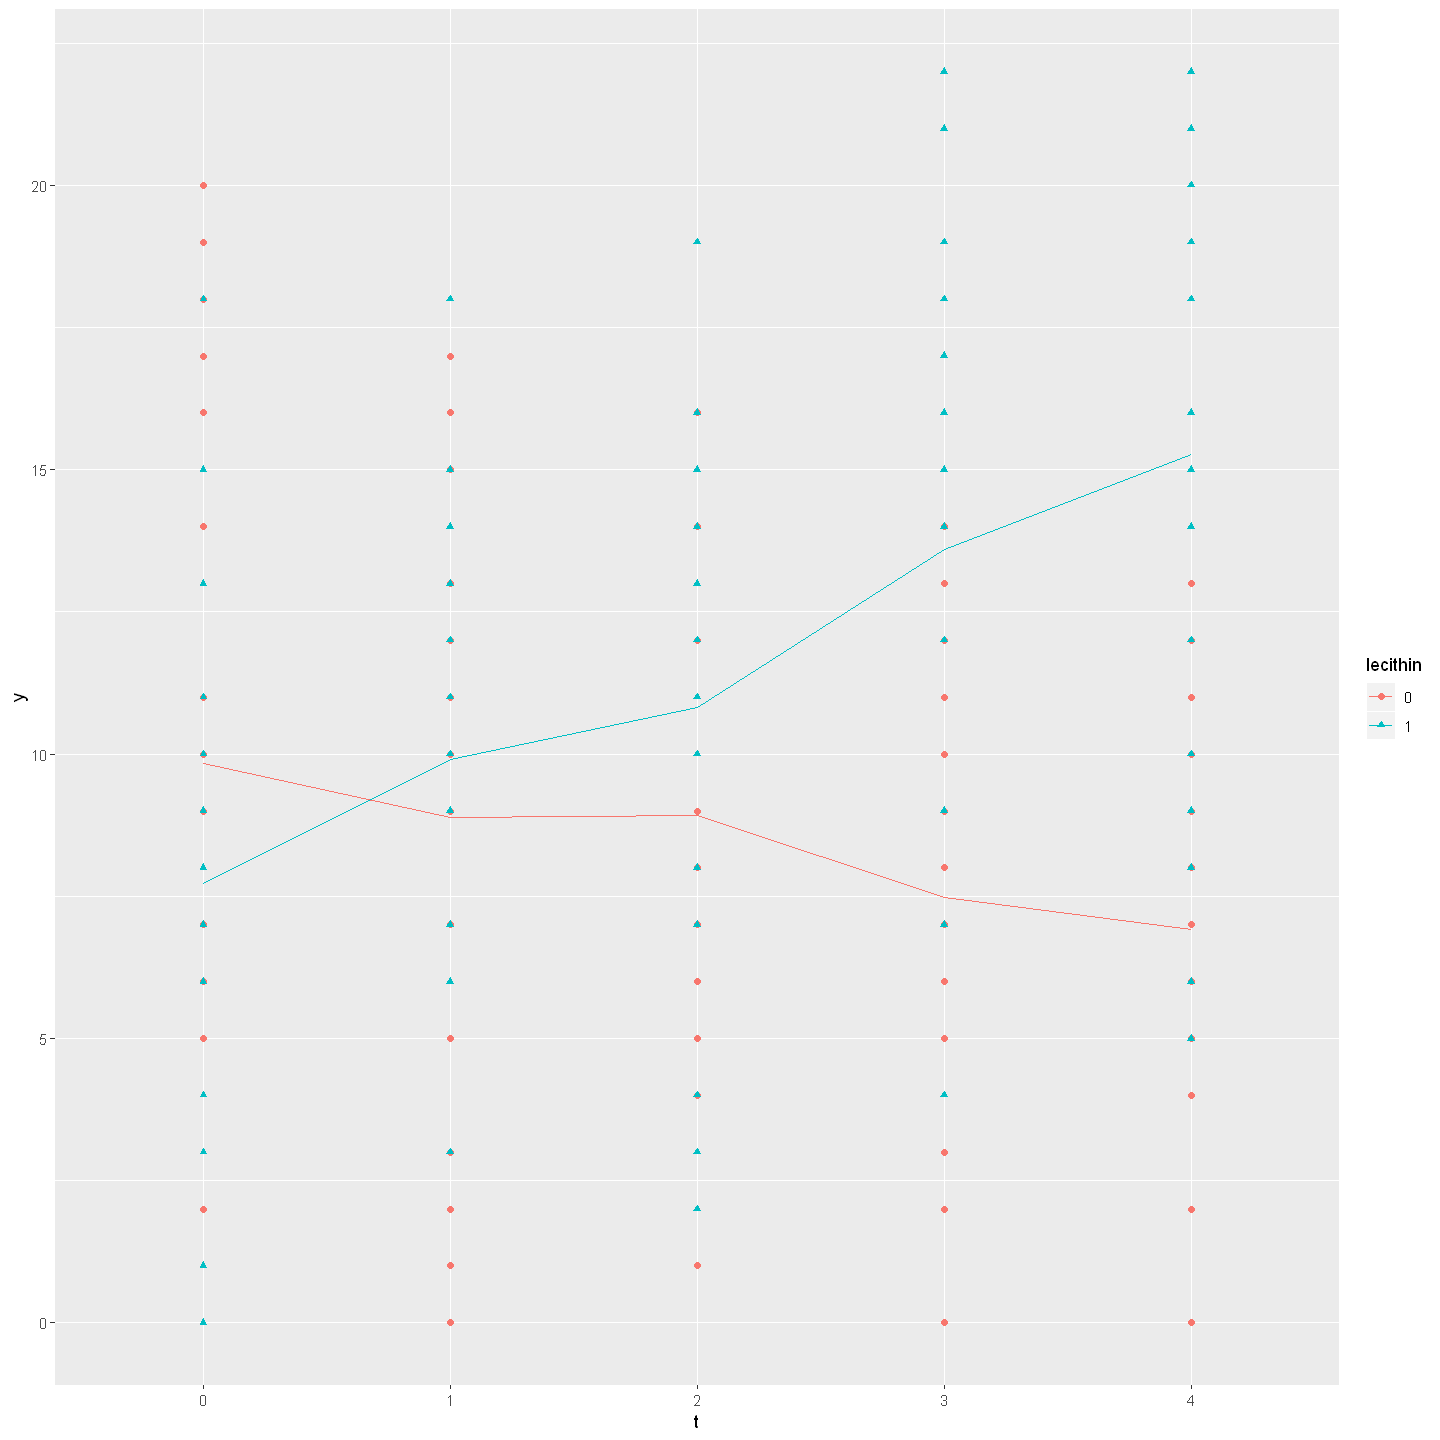

In [5]:
mean <- alz %>% group_by(as.factor(t), as.factor(lecithin)) %>% summarise(mean=mean(y))
colnames(mean) <- c("t","lecithin","mean")
alz$t <- as.factor(alz$t) ; alz$lecithin <- as.factor(alz$lecithin)
ggplot(alz)+
  geom_point(aes(t,y,color=lecithin,shape=lecithin))+
  geom_line(data=mean,aes(x=t,y=mean,color=lecithin,group=lecithin))

* Lecithin 그룹은 대체적으로 테스트를 반복할수록 점수가 향상되었다.
* 가짜약 그룹은 점수가 감소하는 추세를 보인다.

### (b) boxplot을 통해 두 그룹간의 시간에 따른 MMSE 점수 추세 비교

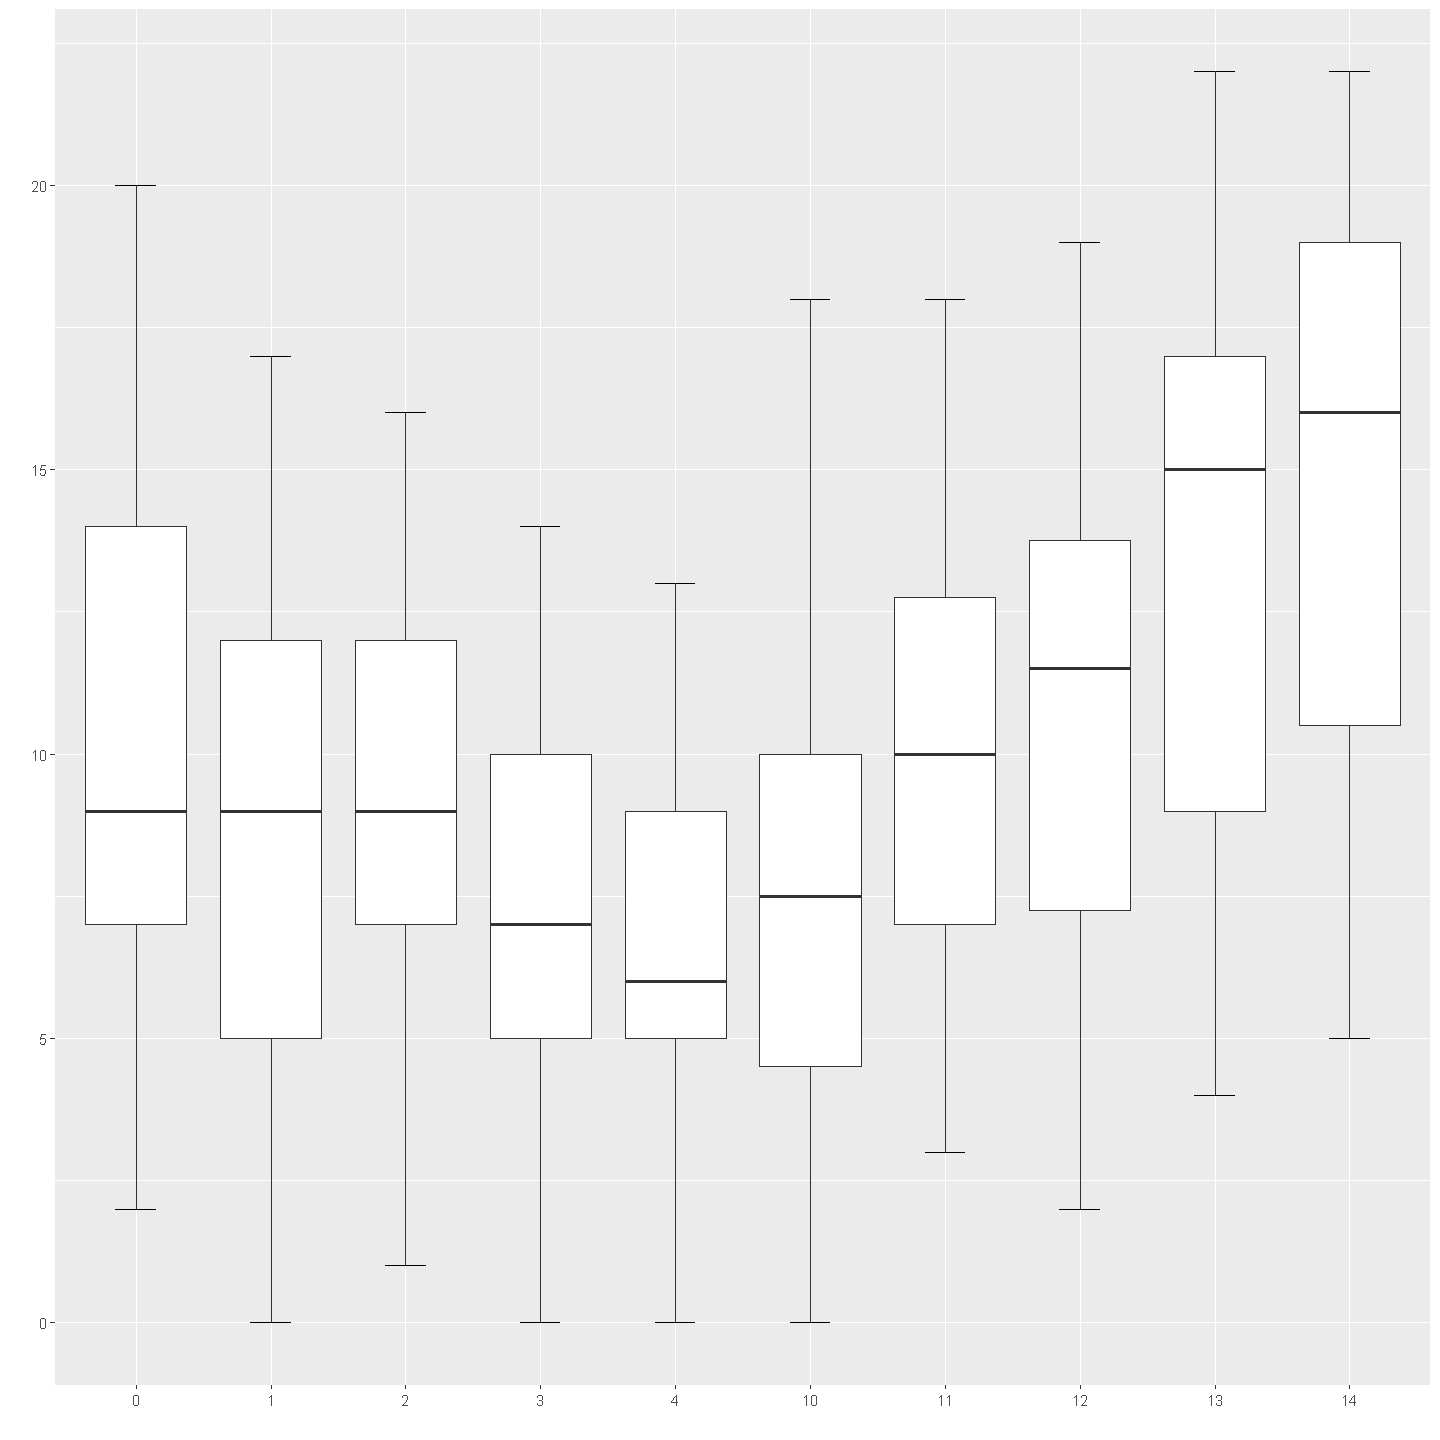

In [6]:
alz%>%mutate('boxplot'=c(rep(0:4,times=25),rep(10:14,times=22)))%>%
  ggplot(aes(as.factor(boxplot),y))+stat_boxplot(geom='errorbar',width=0.3)+
  geom_boxplot(aes(group=boxplot))+labs(x='',y='')

* lecithin (10-14) : 산점도와 마찬가지로 점수가 향상되는 추세를 보인다. 
* 가짜약 (0-4) : 산점도와 마찬가지로 점수가 감소하는 추세를 보인다. 

### (c) Bayes 방법으로 일반화 선형모형 (GLM) 적합 

#### Fixed effects binomial GLM
$y_{it}$ ~ $bin(30,p_{it})$       
$log(p_{it} / (1-p_{it})) = a + c*\delta_i + (d*\delta_i + b)*t/12$        
$i = 1, ..., n, t = 0,1,2,3,4$       
$\delta_i =$ 0 (placebo) / 1 (lecithin), $i = 1, ..., n$      
모수 : $\theta = (a,b,c,d)$ -> (효과: c,d) 

In [7]:
y<-alz$y
I<-alz$lecithin
t<-alz$t

In [8]:
fixed_glm <- "model{
for(i in 1:length(y)) {
y[i] ~ dbinom(p[i],30)
p[i] <- ilogit(a+c*I[i]+(d*I[i]+b)*t[i]/12)
}

## prior distribution

a ~ dunif(-20,20)
b ~ dunif(-20,20)
c ~ dunif(-20,20)
d ~ dunif(-20,20)
}"

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 235
   Unobserved stochastic nodes: 4
   Total graph size: 759

Initializing model



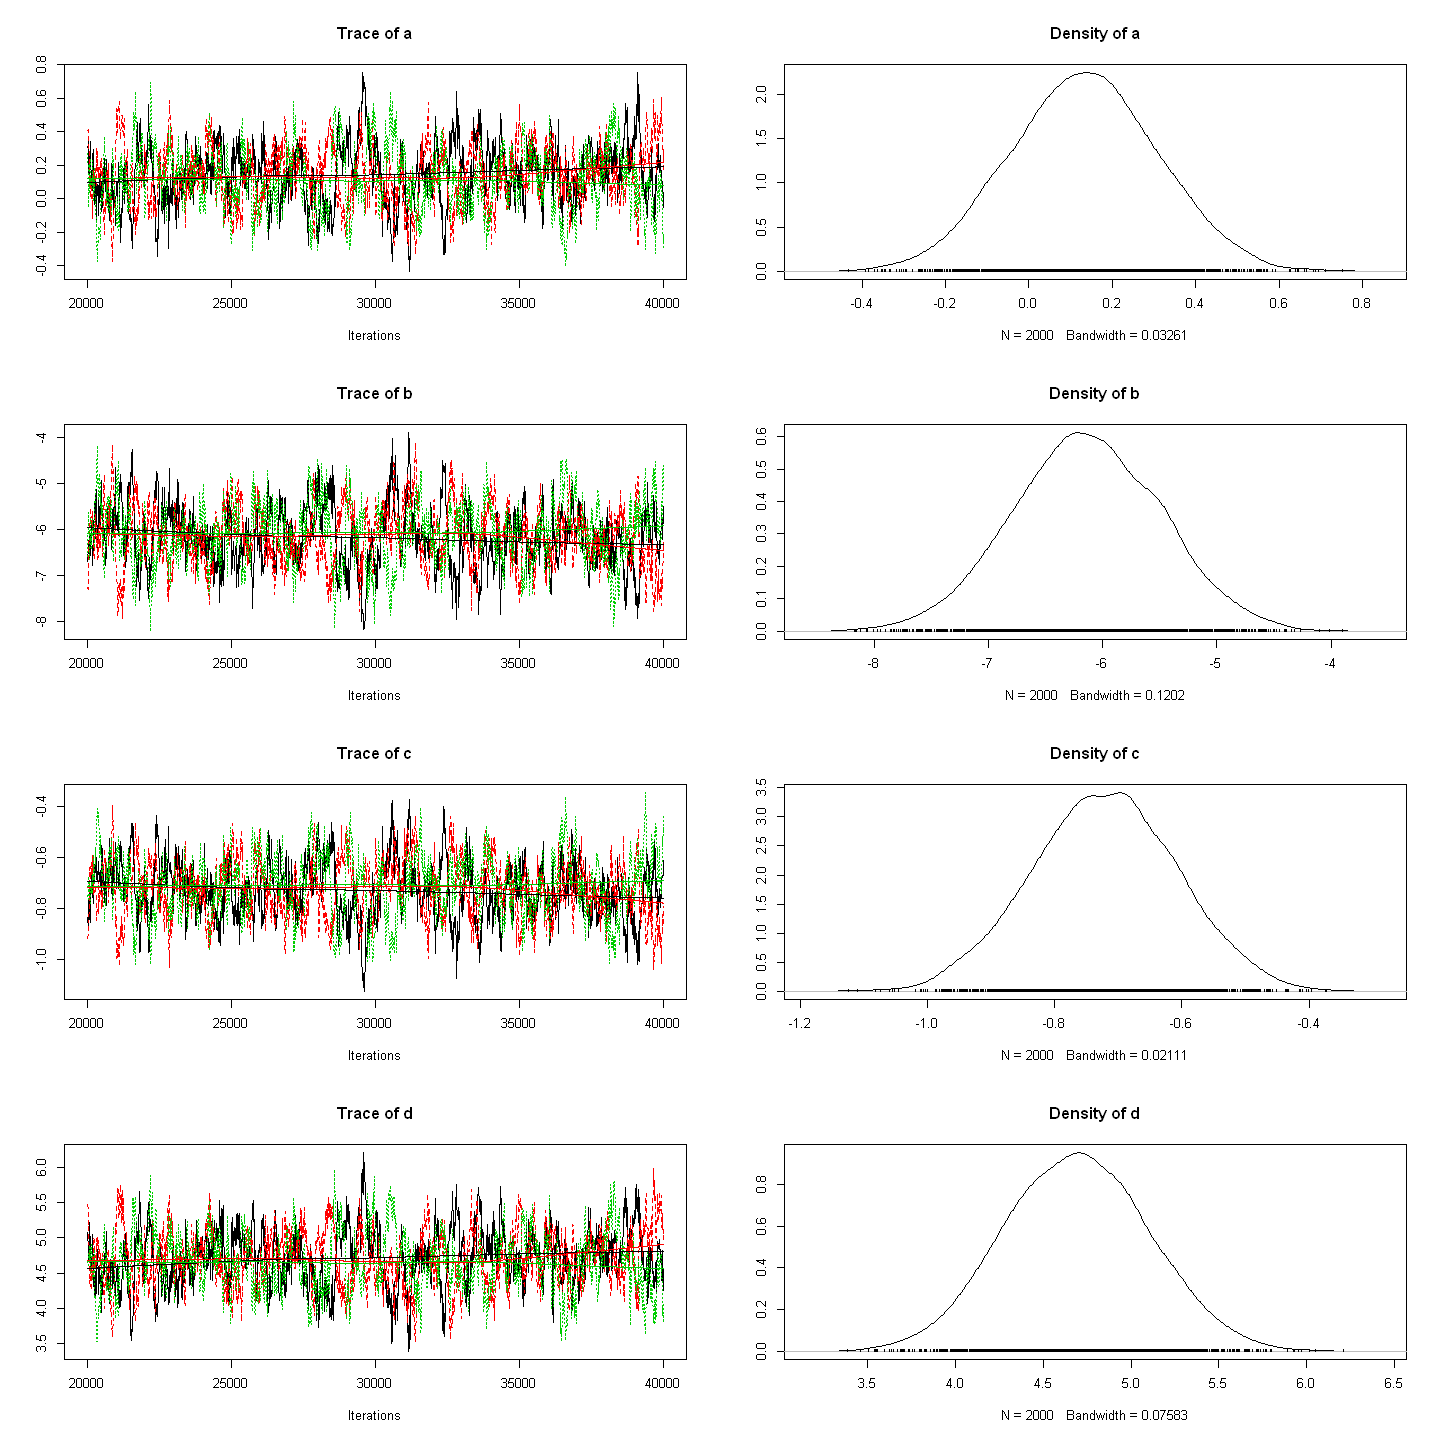

In [9]:
model <- jags.model(textConnection(fixed_glm), data=list(y=y,I=I,t=t),n.chains = 3, n.adapt= 10000)

#burnin for 10000 samples 
update(model,10000)

#thinning
mcmc.c<-coda.samples(model,variable.names=c("a","b","c","d"),n.iter=20000,thin=10)
plot(mcmc.c)

In [10]:
summary(mcmc.c)


Iterations = 20010:40000
Thinning interval = 10 
Number of chains = 3 
Sample size per chain = 2000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

     Mean     SD Naive SE Time-series SE
a  0.1332 0.1753 0.002263       0.011151
b -6.1387 0.6462 0.008342       0.042312
c -0.7211 0.1135 0.001465       0.007134
d  4.6916 0.4075 0.005261       0.026372

2. Quantiles for each variable:

     2.5%      25%     50%     75%   97.5%
a -0.2093  0.01532  0.1330  0.2521  0.4786
b -7.4097 -6.57232 -6.1457 -5.6901 -4.8663
c -0.9452 -0.79744 -0.7203 -0.6427 -0.5003
d  3.9039  4.40768  4.6902  4.9681  5.4918


* c의 추정값 : -0.7211, 95% CI : (-0.9452, -0.5003) 
* d의 추정값 :  4.6916, 95% CI : ( 3.9039,  5.4918) 
* c와 d 모두 0을 포함하지 않으므로 유의한 효과가 있다고 할 수 있다. 

### (d) Bayes 방법으로 혼합형 선형모형 (GLMM) 적합

#### Mixed effects binomial GLM 
$y_{it}$ ~ $bin(30,p_{it})$, $i = 1, ..., n, t = 0,1,2,3,4$          
$log(p_{it} / (1-p_{it})) = \alpha_i+\beta_i(t/12)$           
$\alpha_i = a+\sigma u_i + c*\delta_i$           
$\beta_i = b+d*\delta_i$          
$u_i$ ~ $N(0,1)$               
모수 : $\theta = (a,b,c,d,u_i,\sigma)$ -> (효과: c,d / 이질성: $u_i$) 

In [11]:
alz2 <- read_xlsx('Alzheimer.xlsx',sheet=2)
y<-alz2[,2:6]
I<-alz2$lecithin

In [12]:
mixed_glm <- "model{
    for(i in 1:47) {
        for(t in 1:5){
          y[i,t]~dbinom(p[i,t],30)
          p[i,t]<-ilogit(alpha[i]+beta[i]*(t-1)/12)
        }
          alpha[i]<-a+sigma*u[i]+c*I[i]
          beta[i]<-b+d*I[i]
          u[i]~dnorm(0,1)
    }

## prior distribution
a ~ dunif(-20,20)
b ~ dunif(-20,20)
c ~ dunif(-20,20)
d ~ dunif(-20,20)
sigma ~ dunif(0,10)
}"

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 235
   Unobserved stochastic nodes: 52
   Total graph size: 940

Initializing model



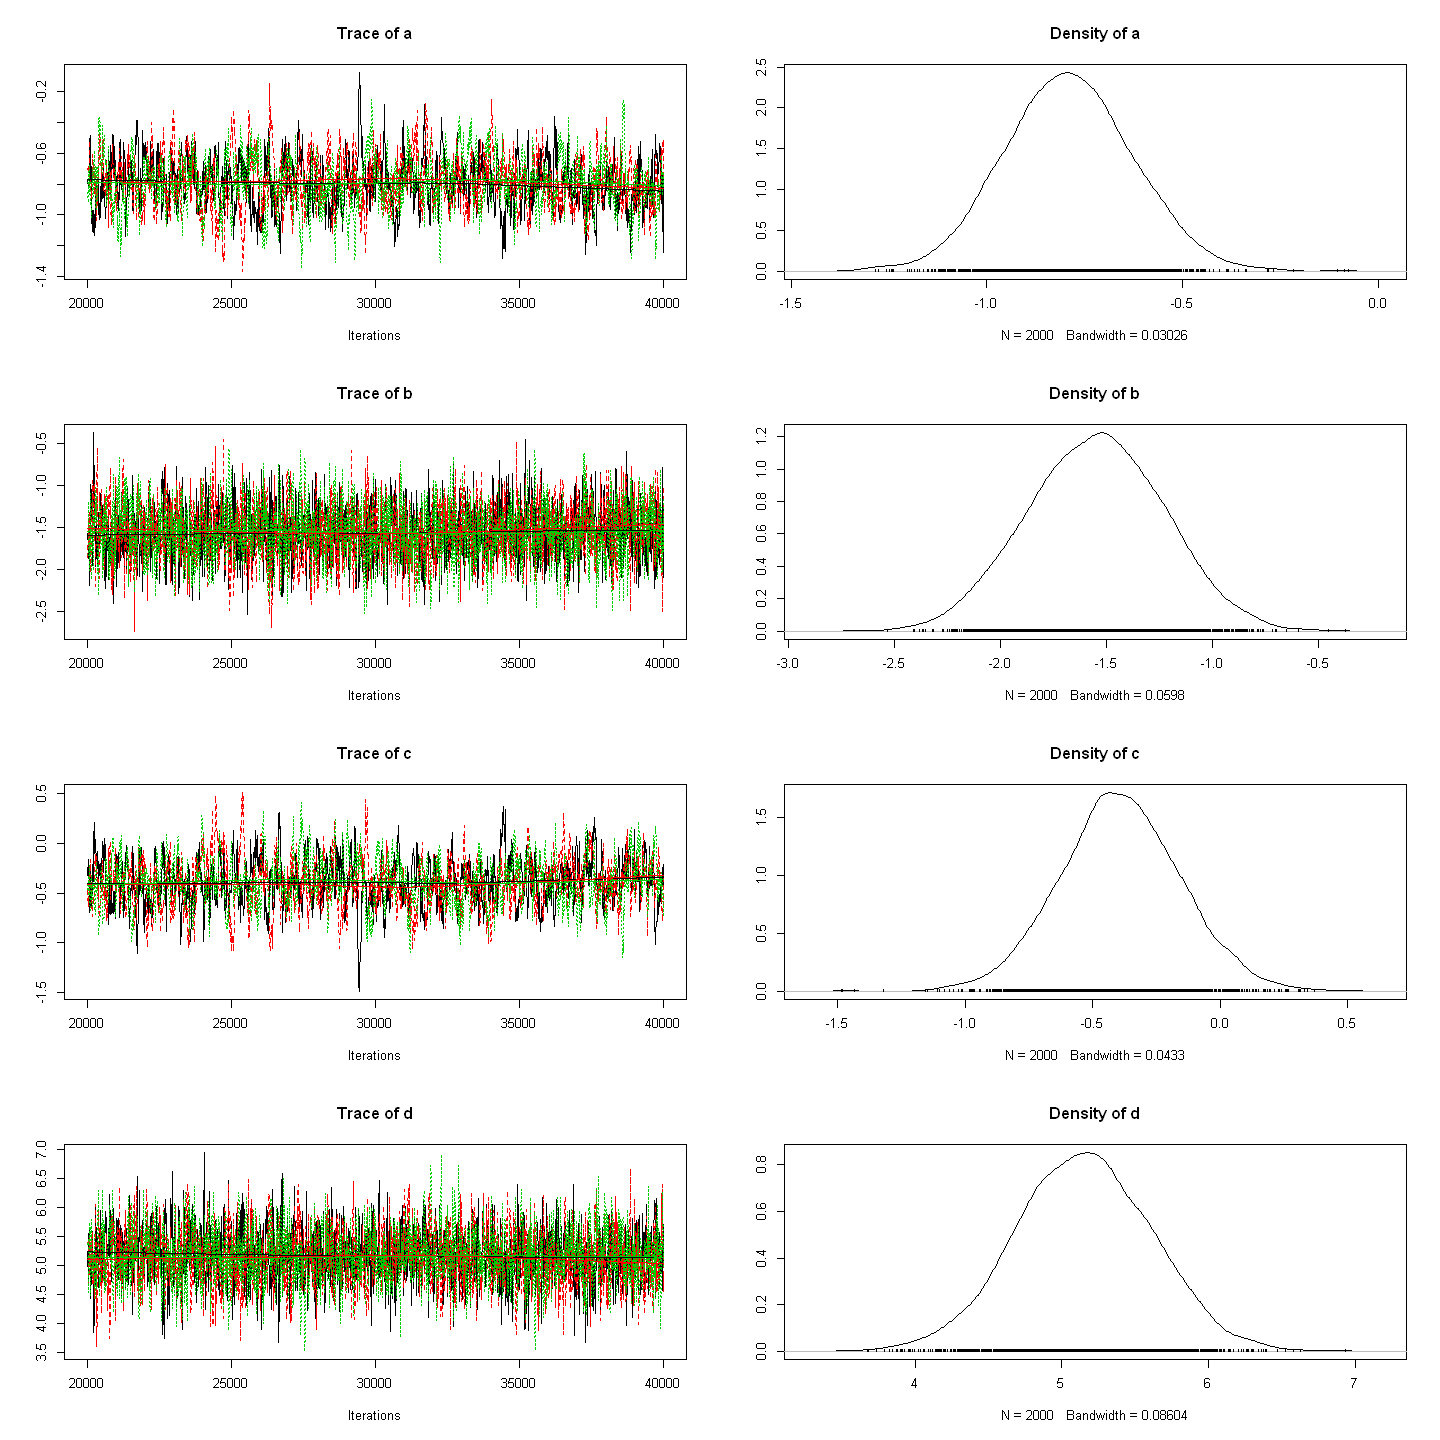

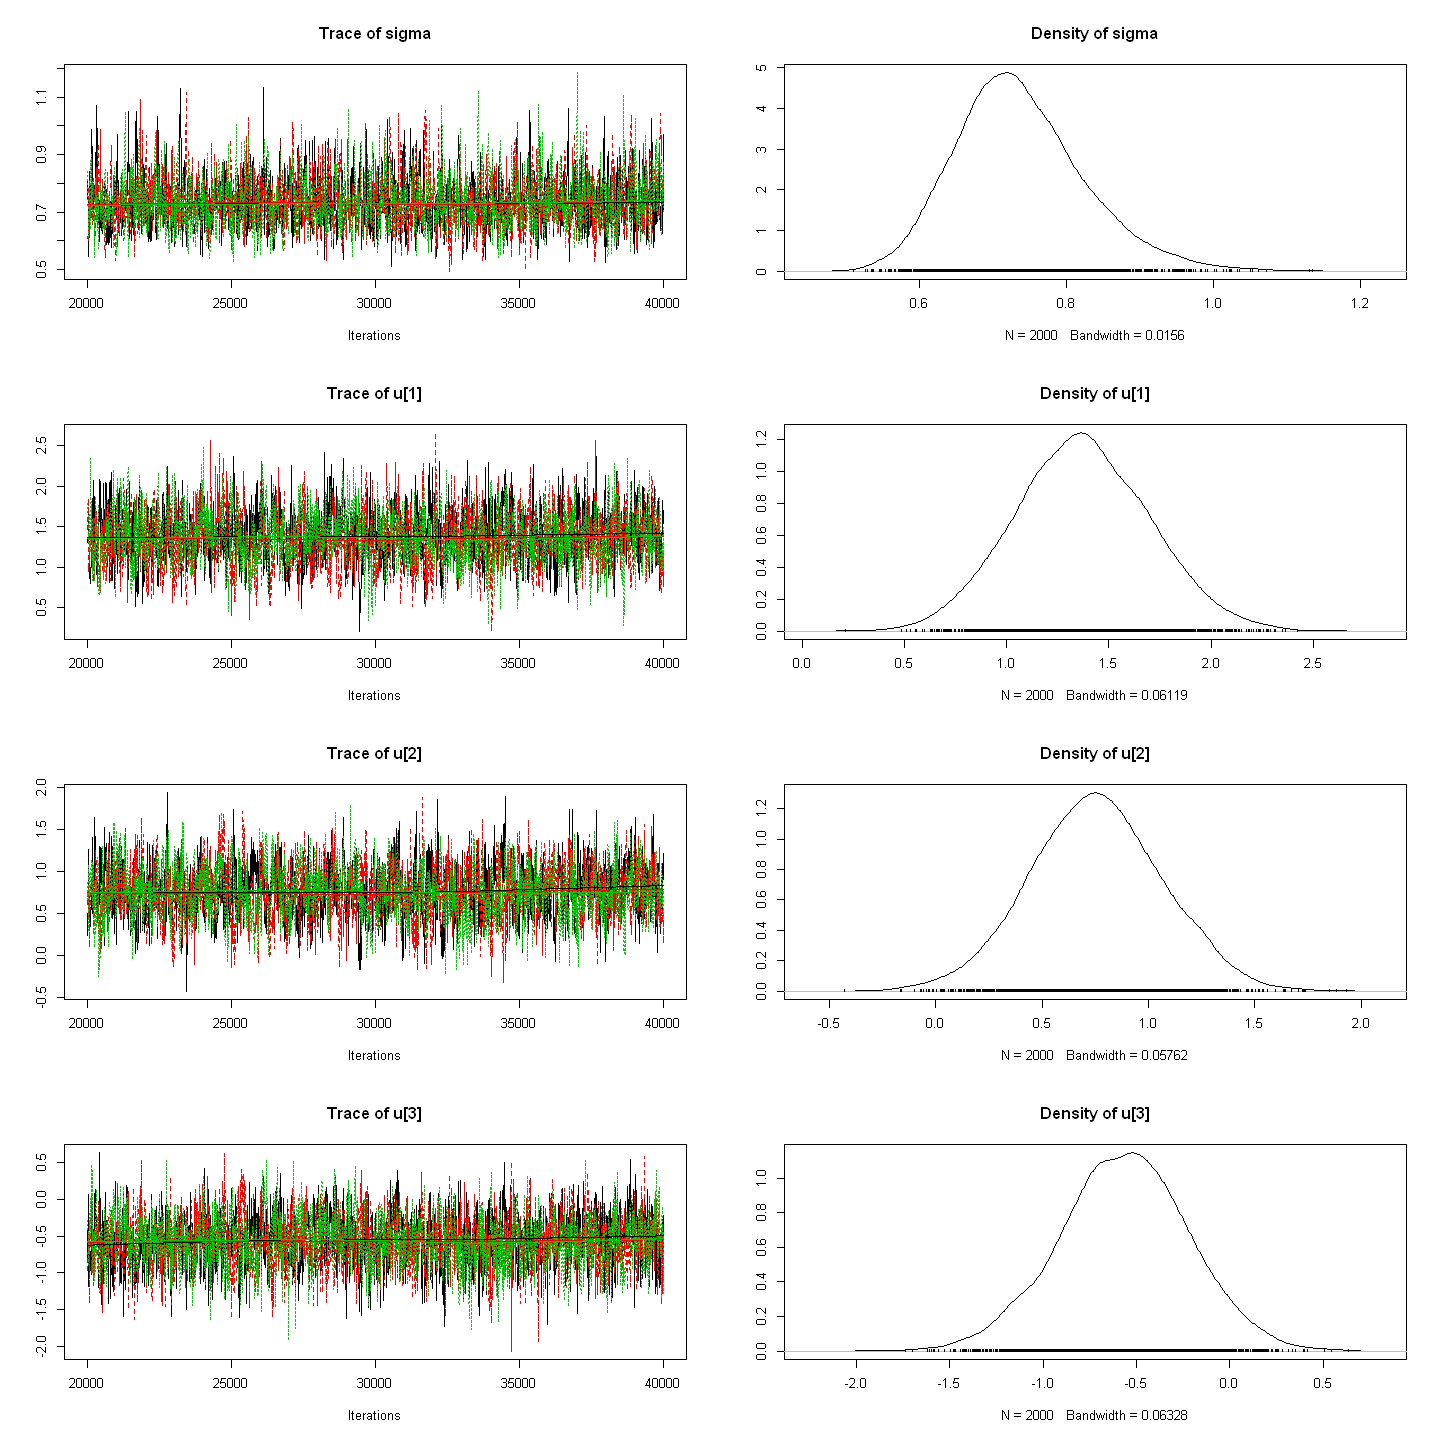

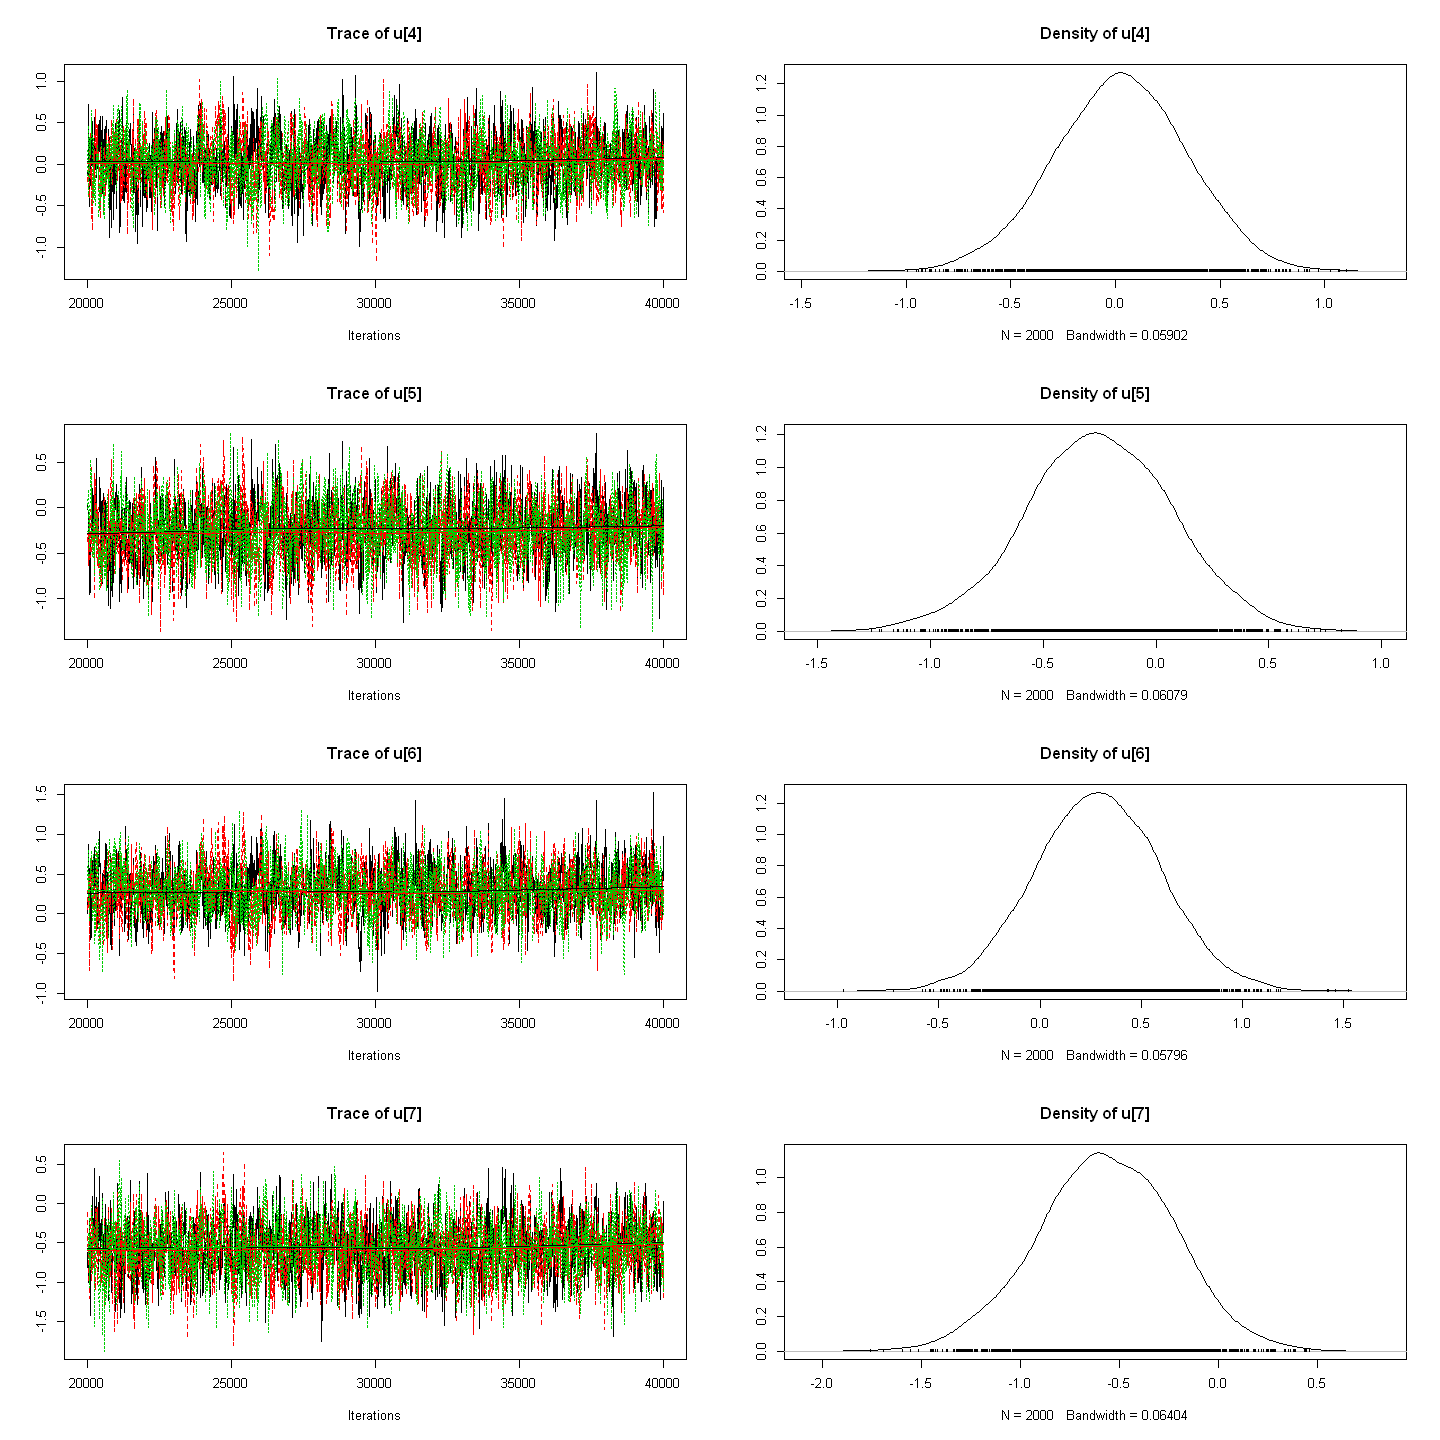

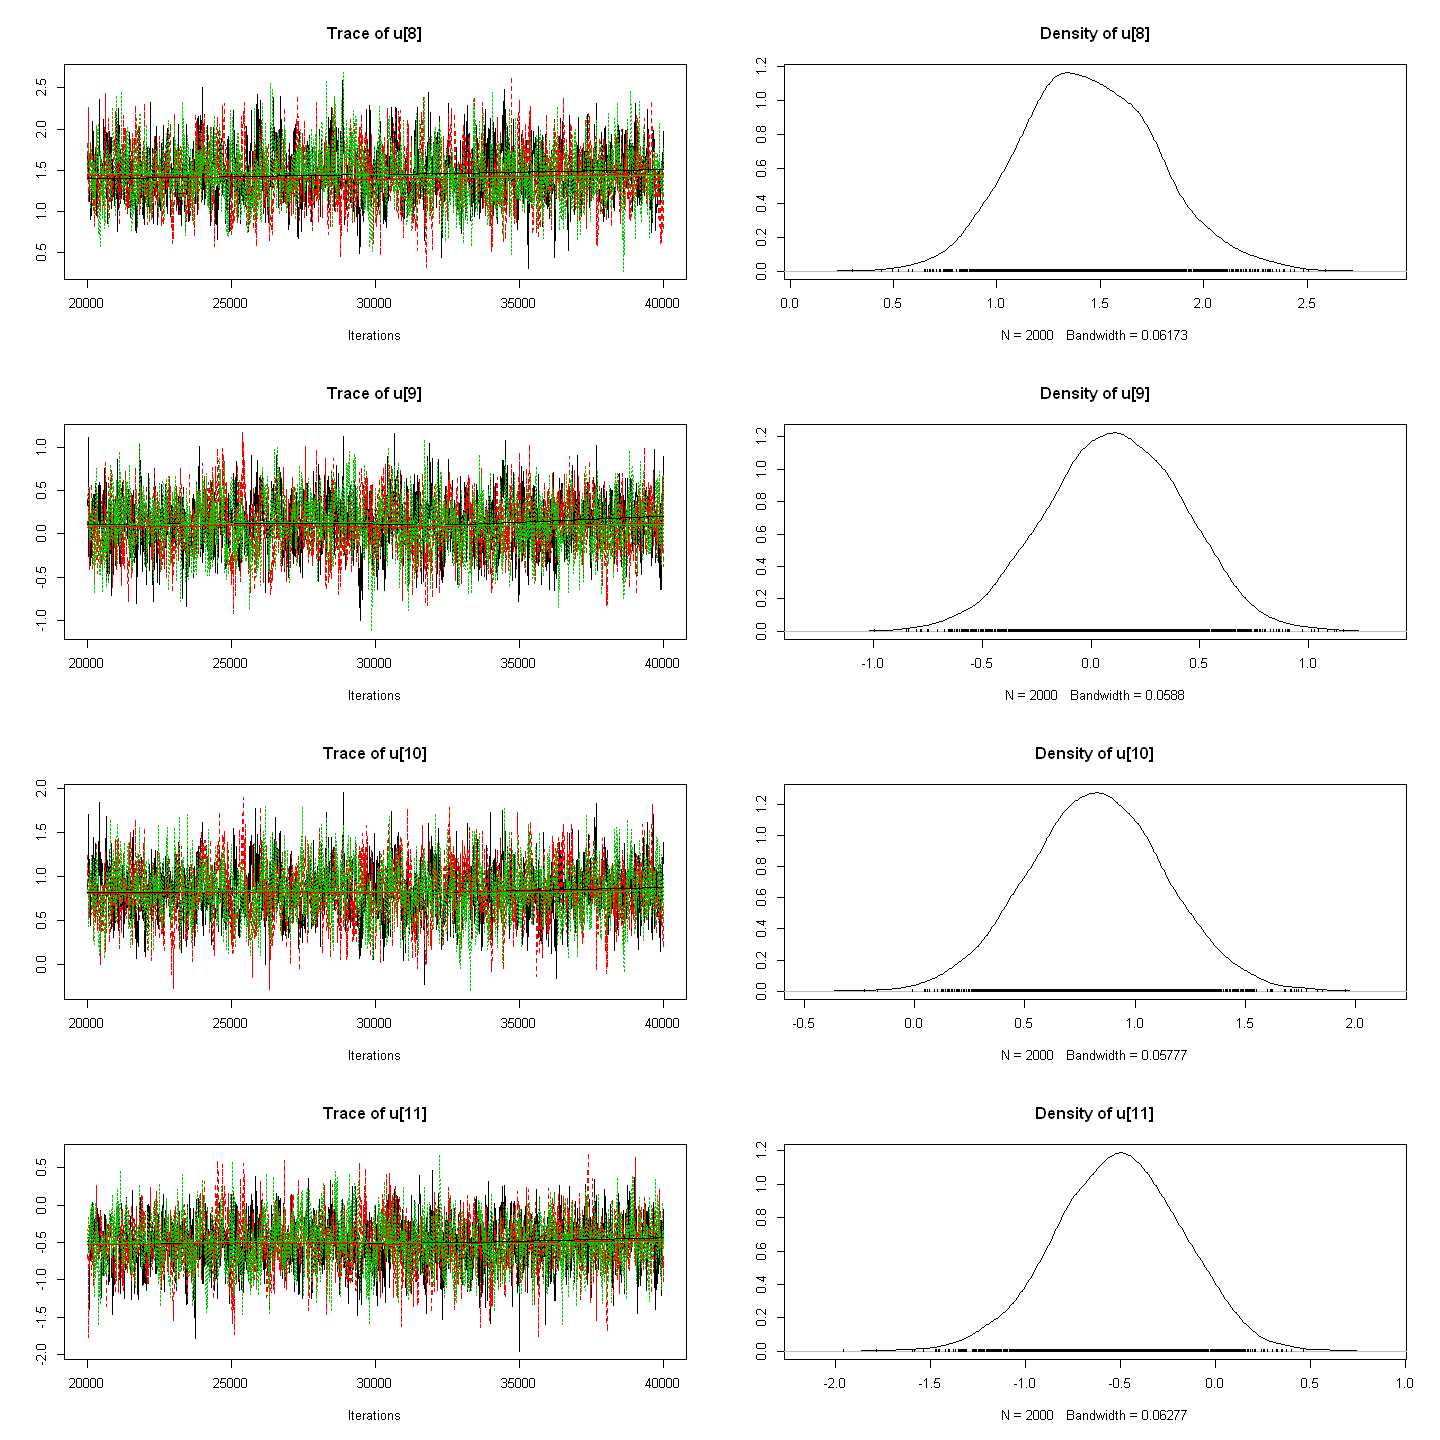

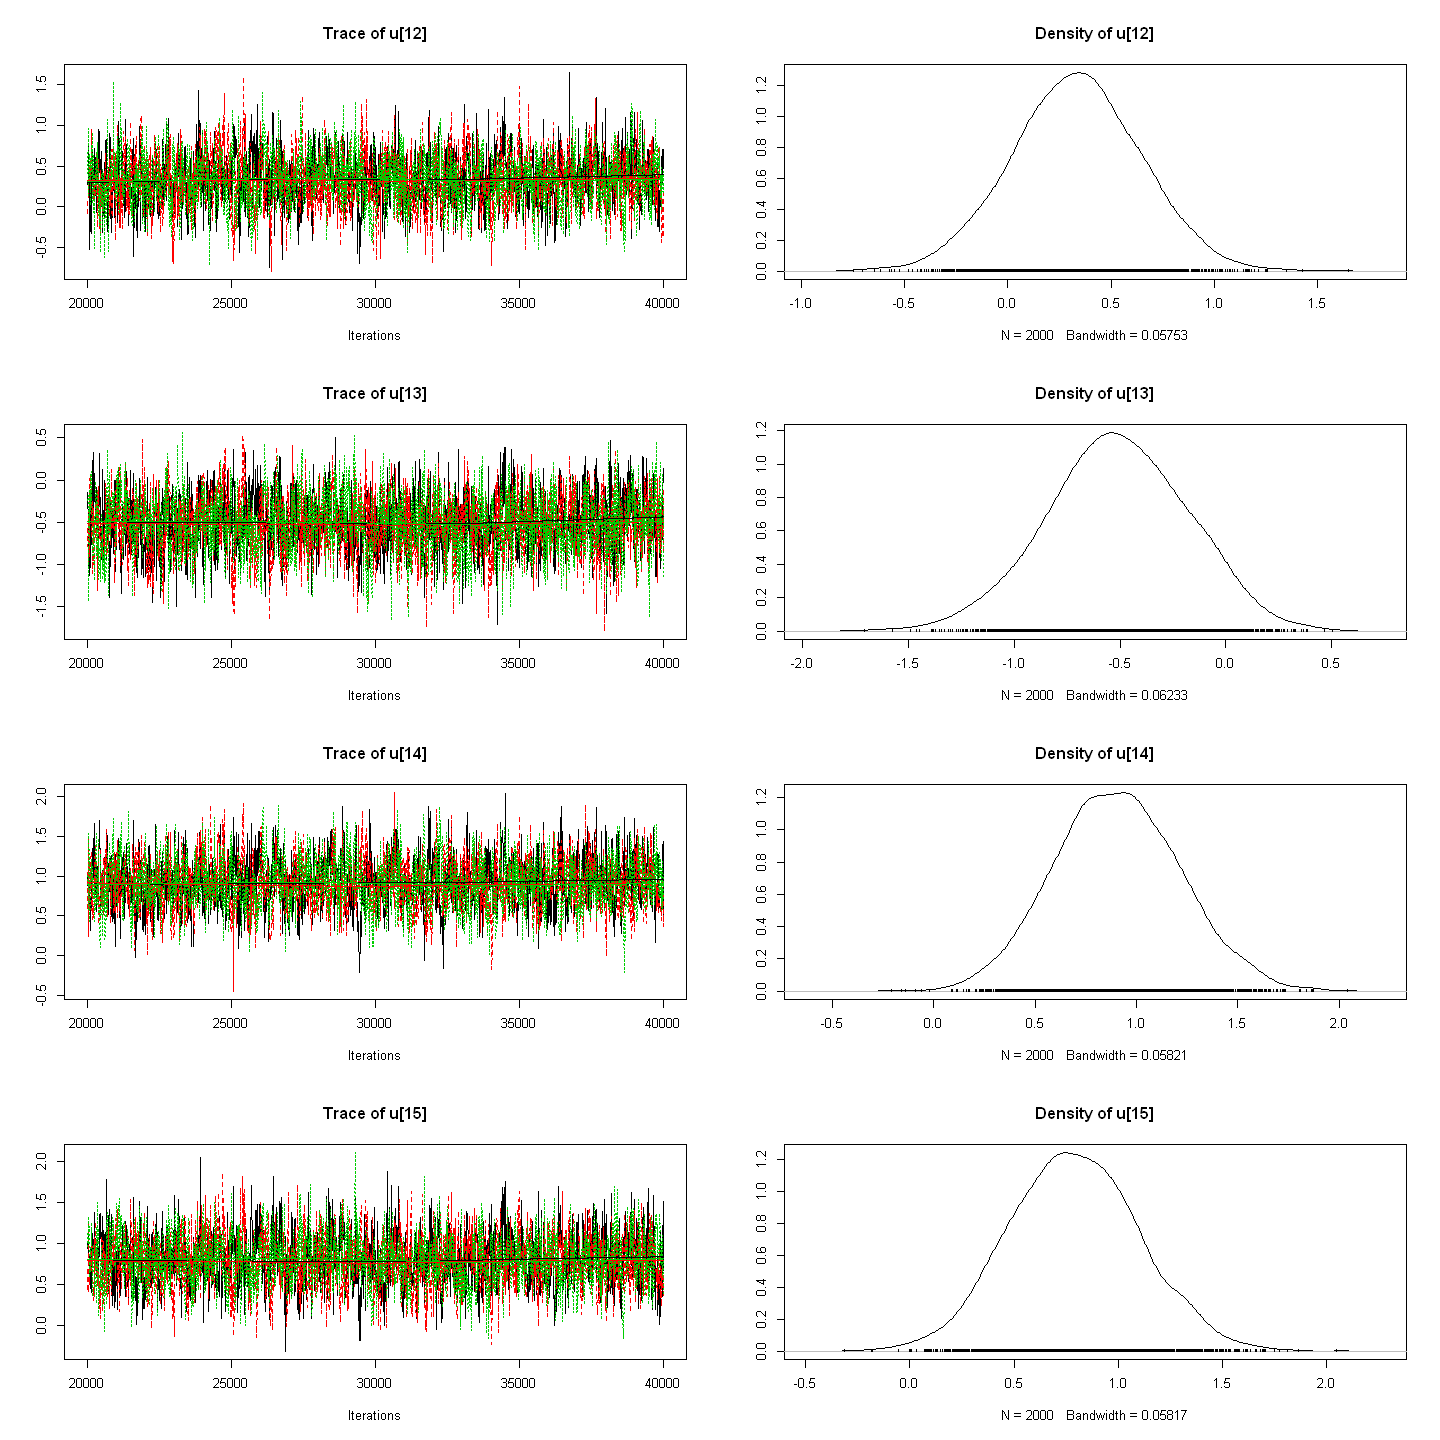

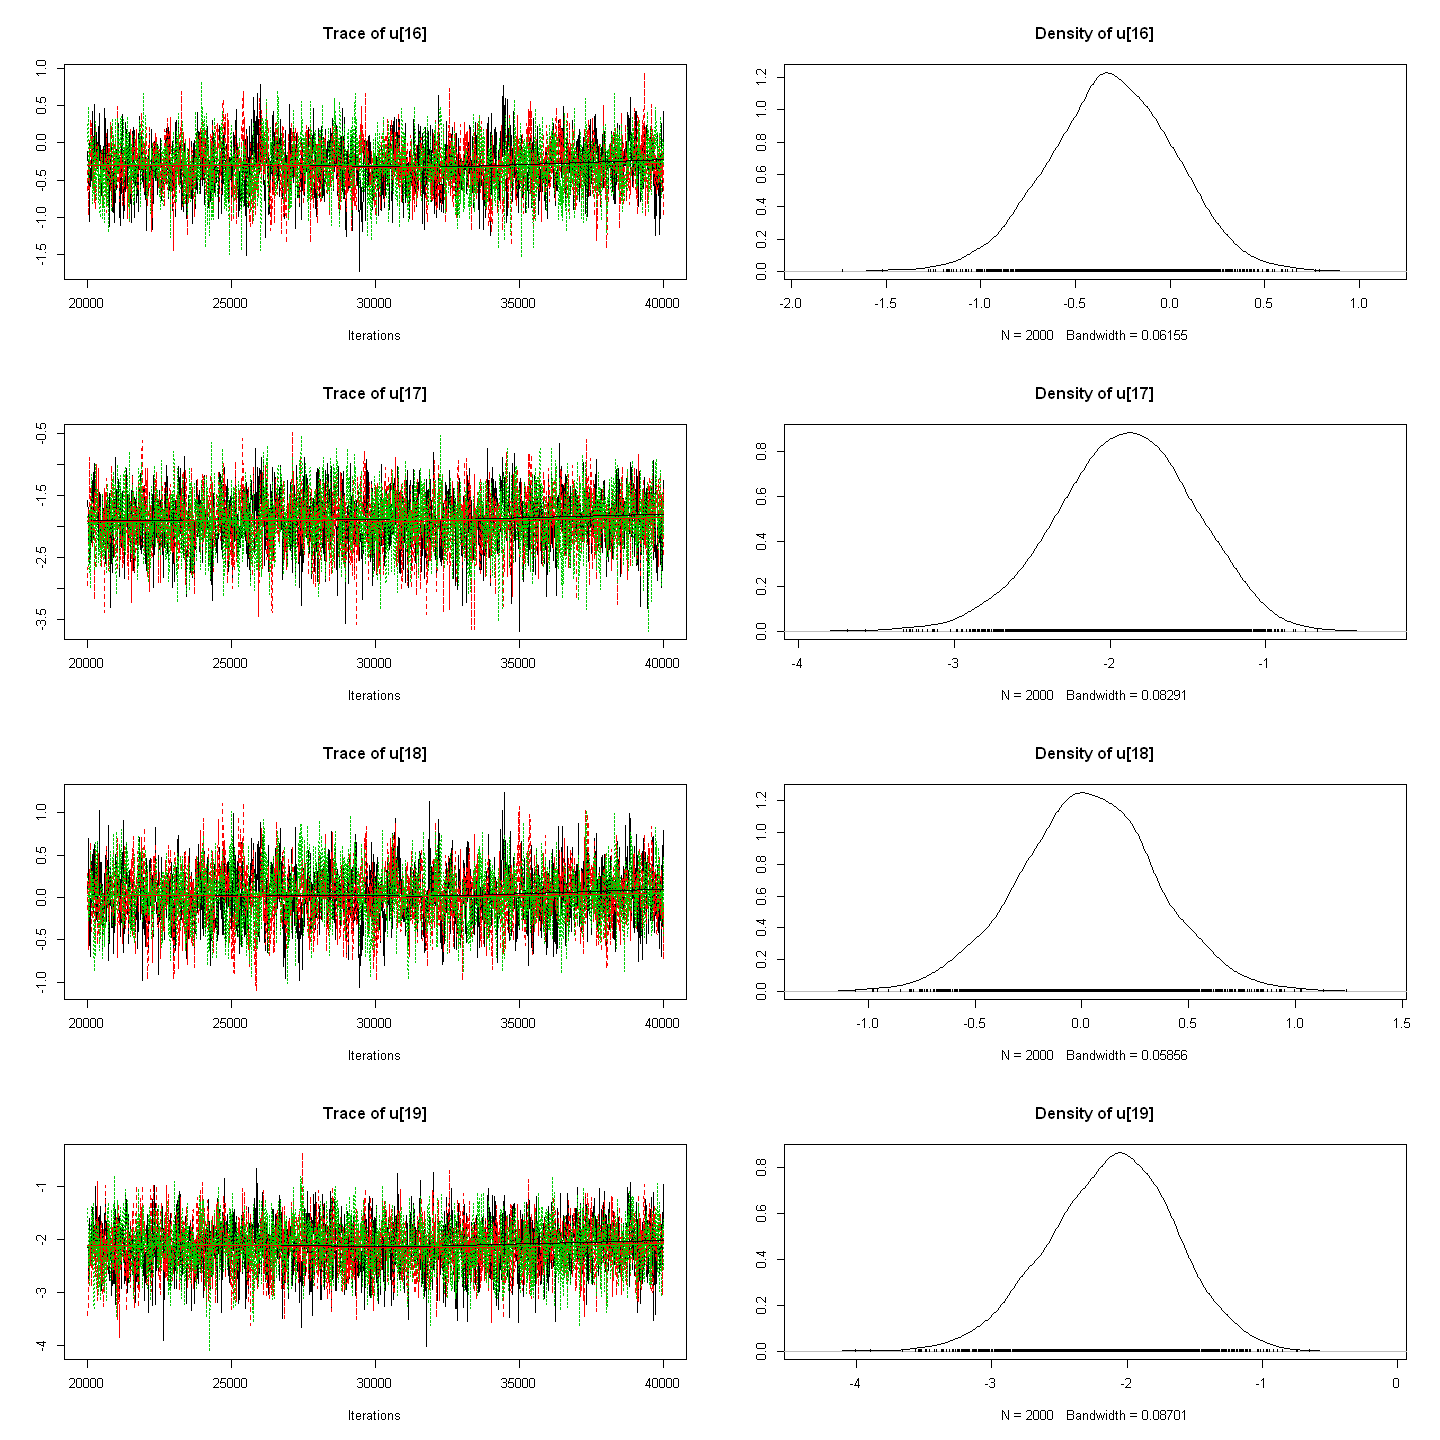

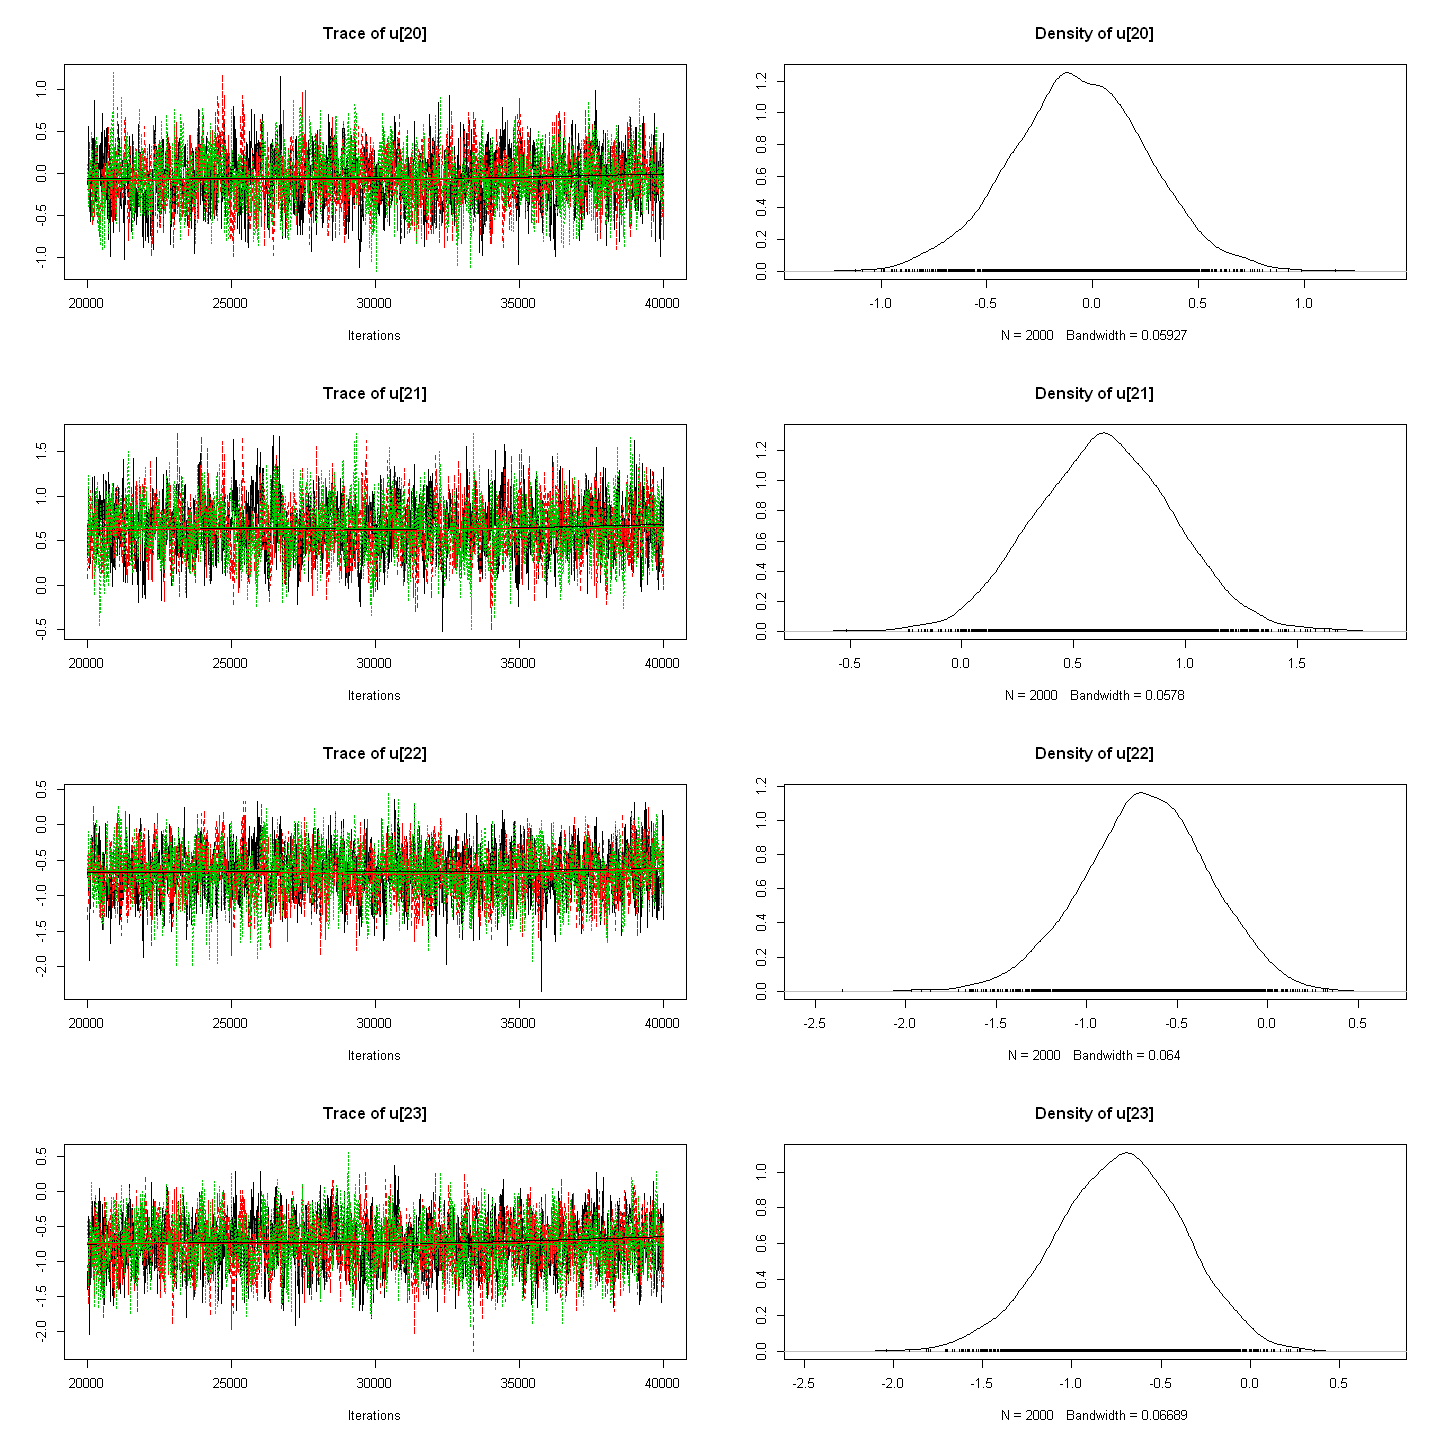

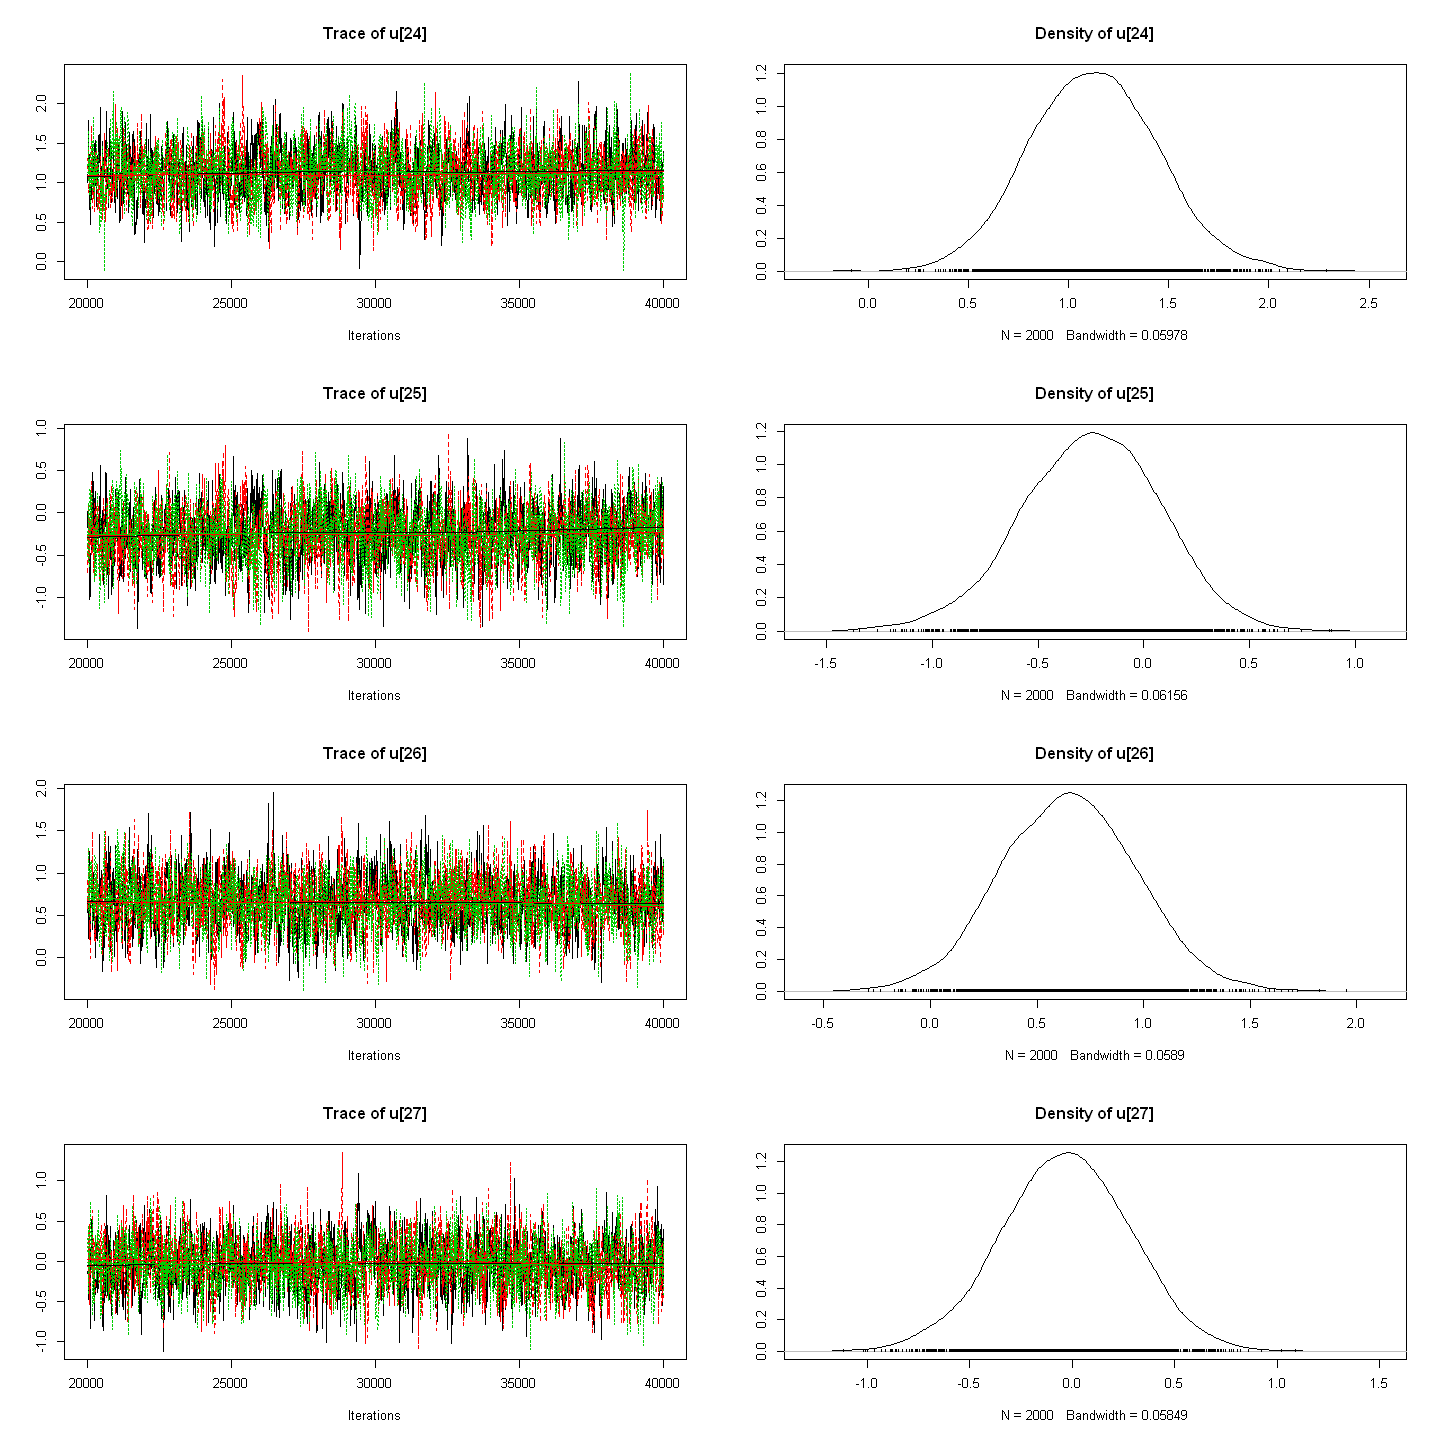

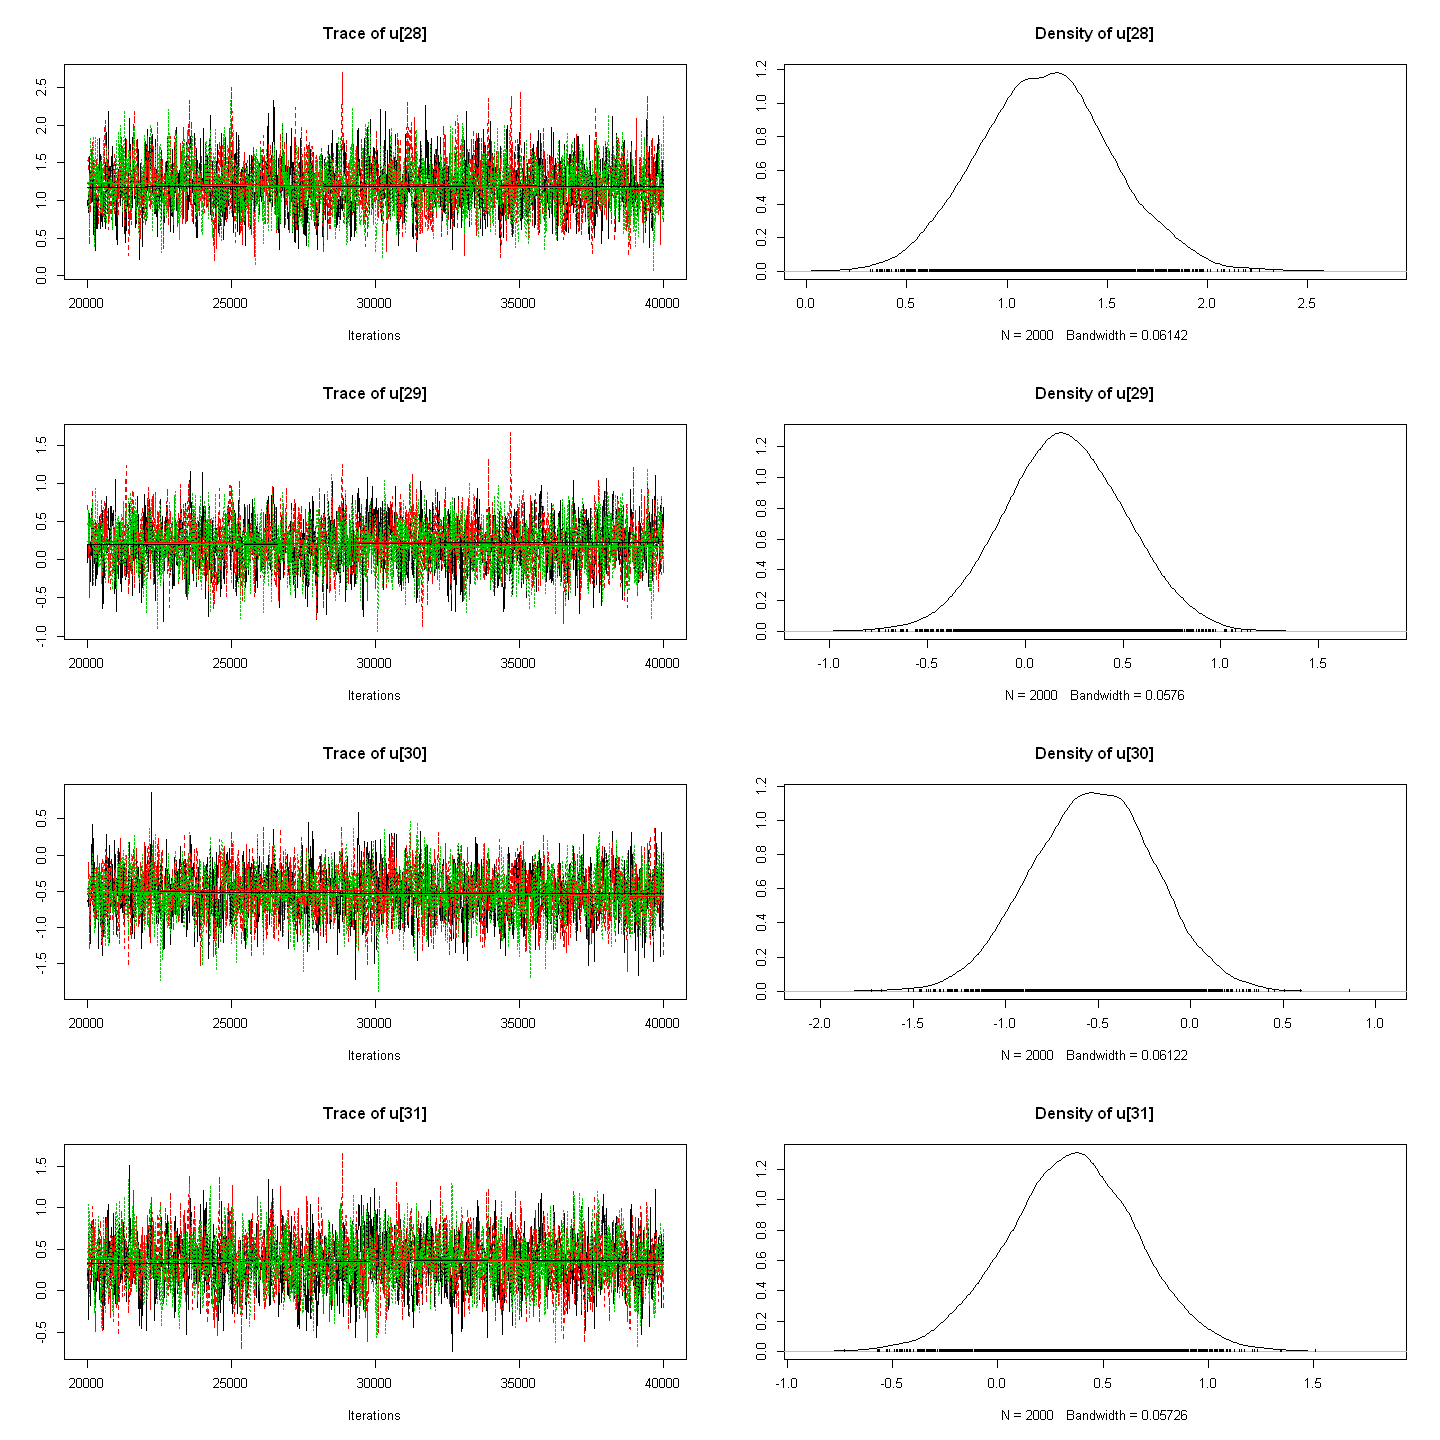

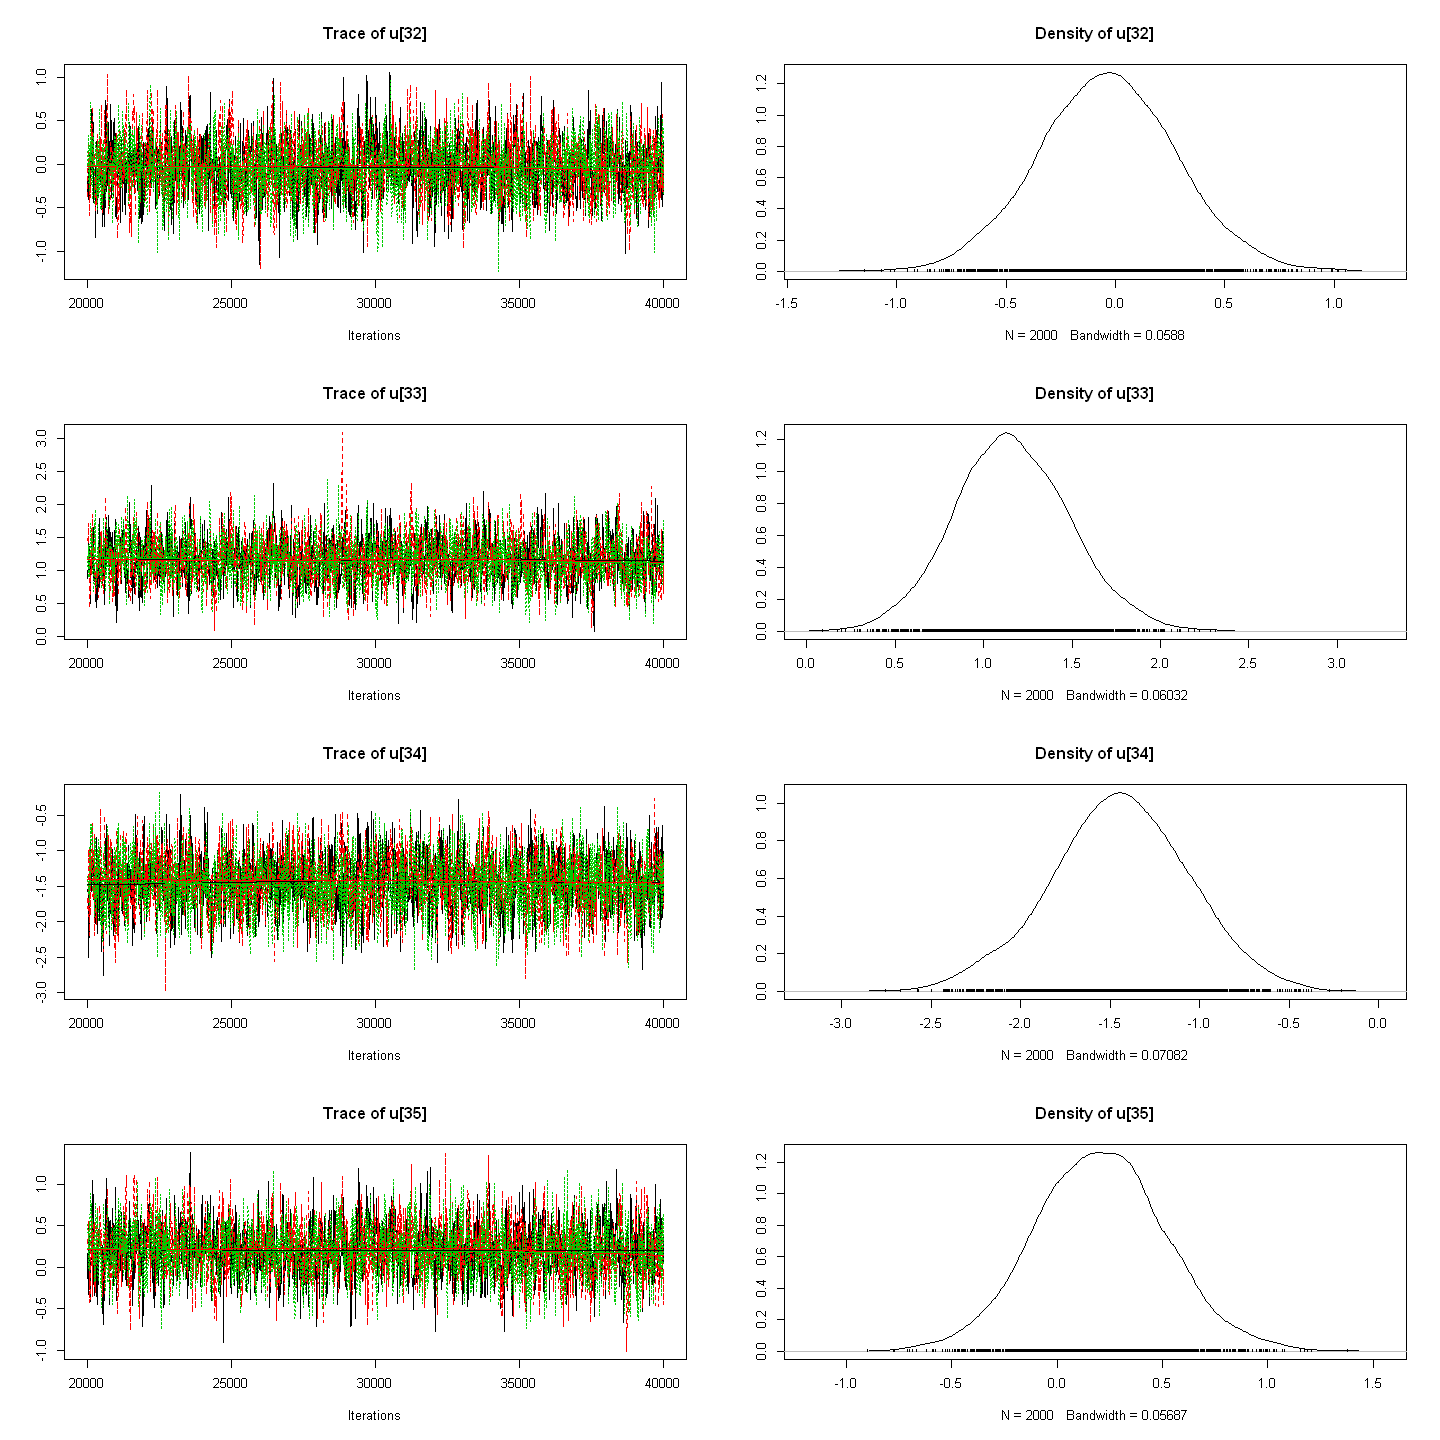

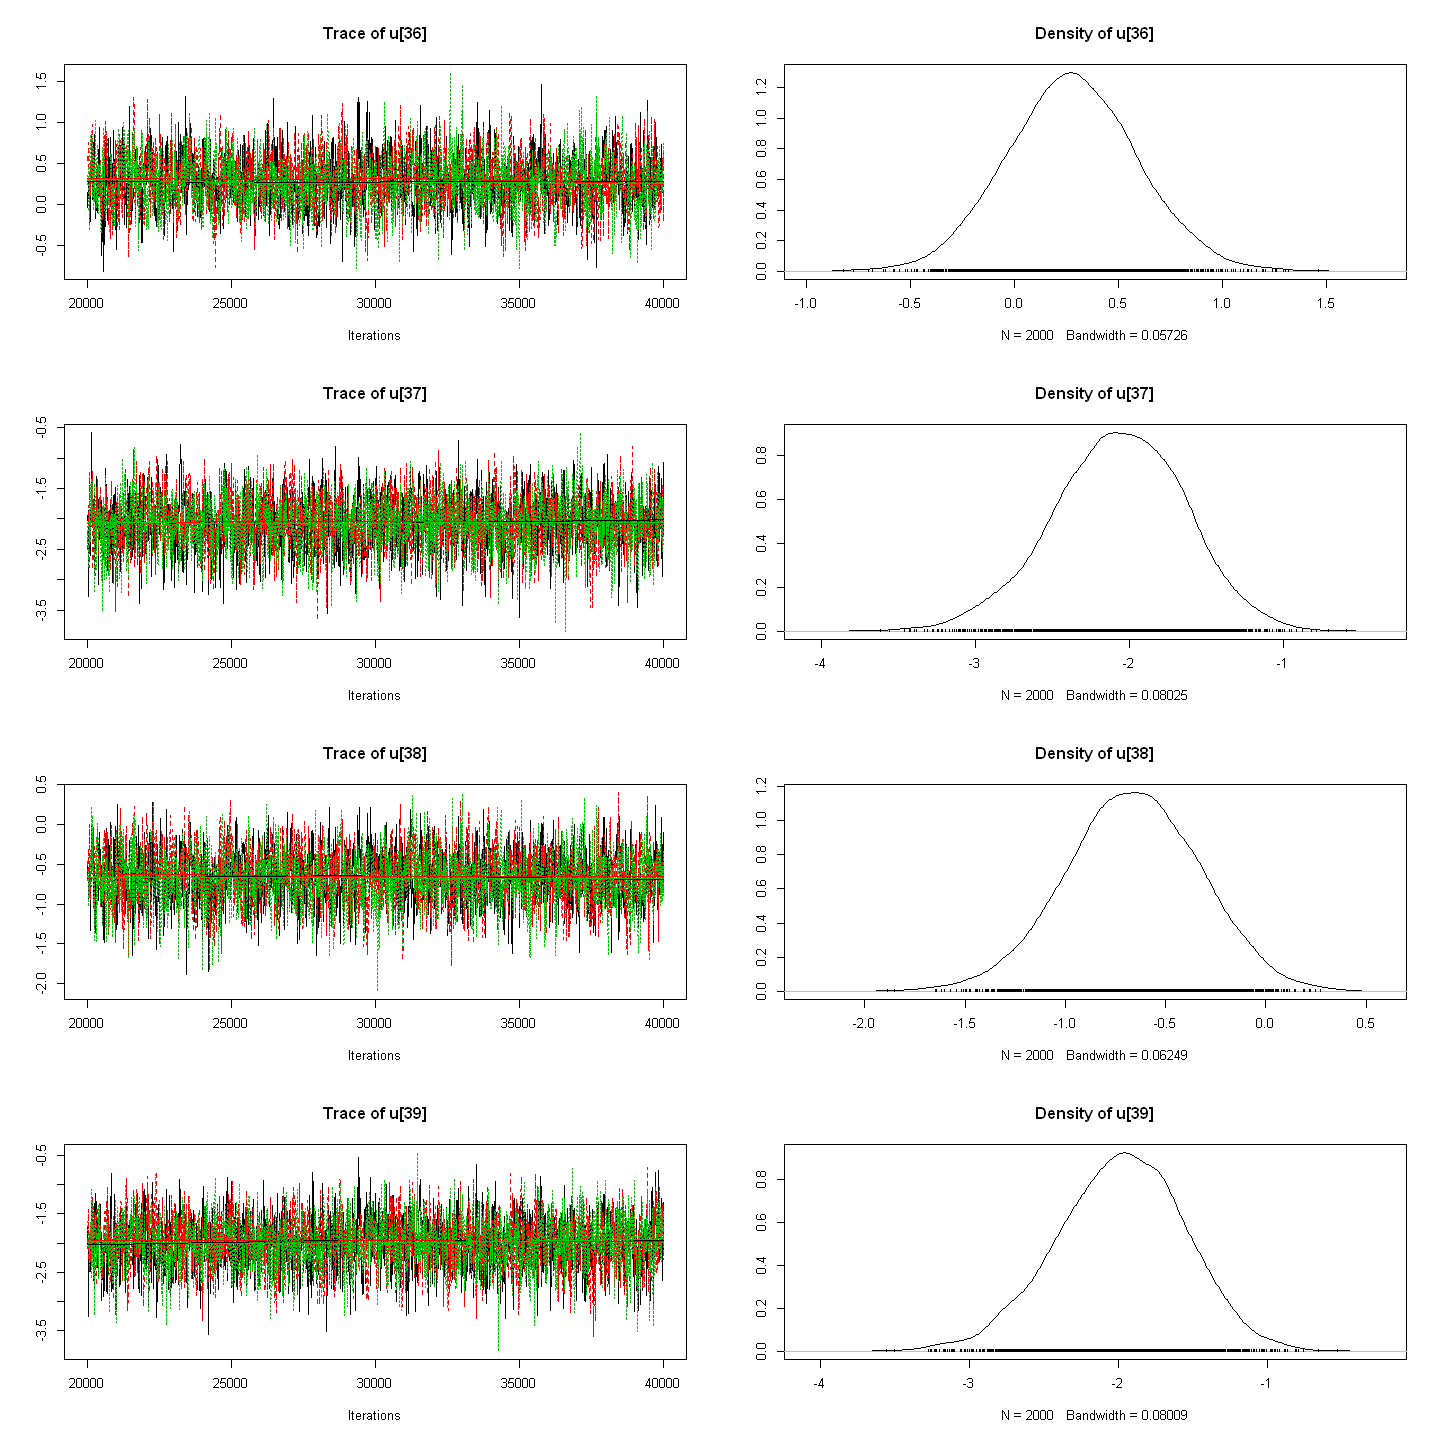

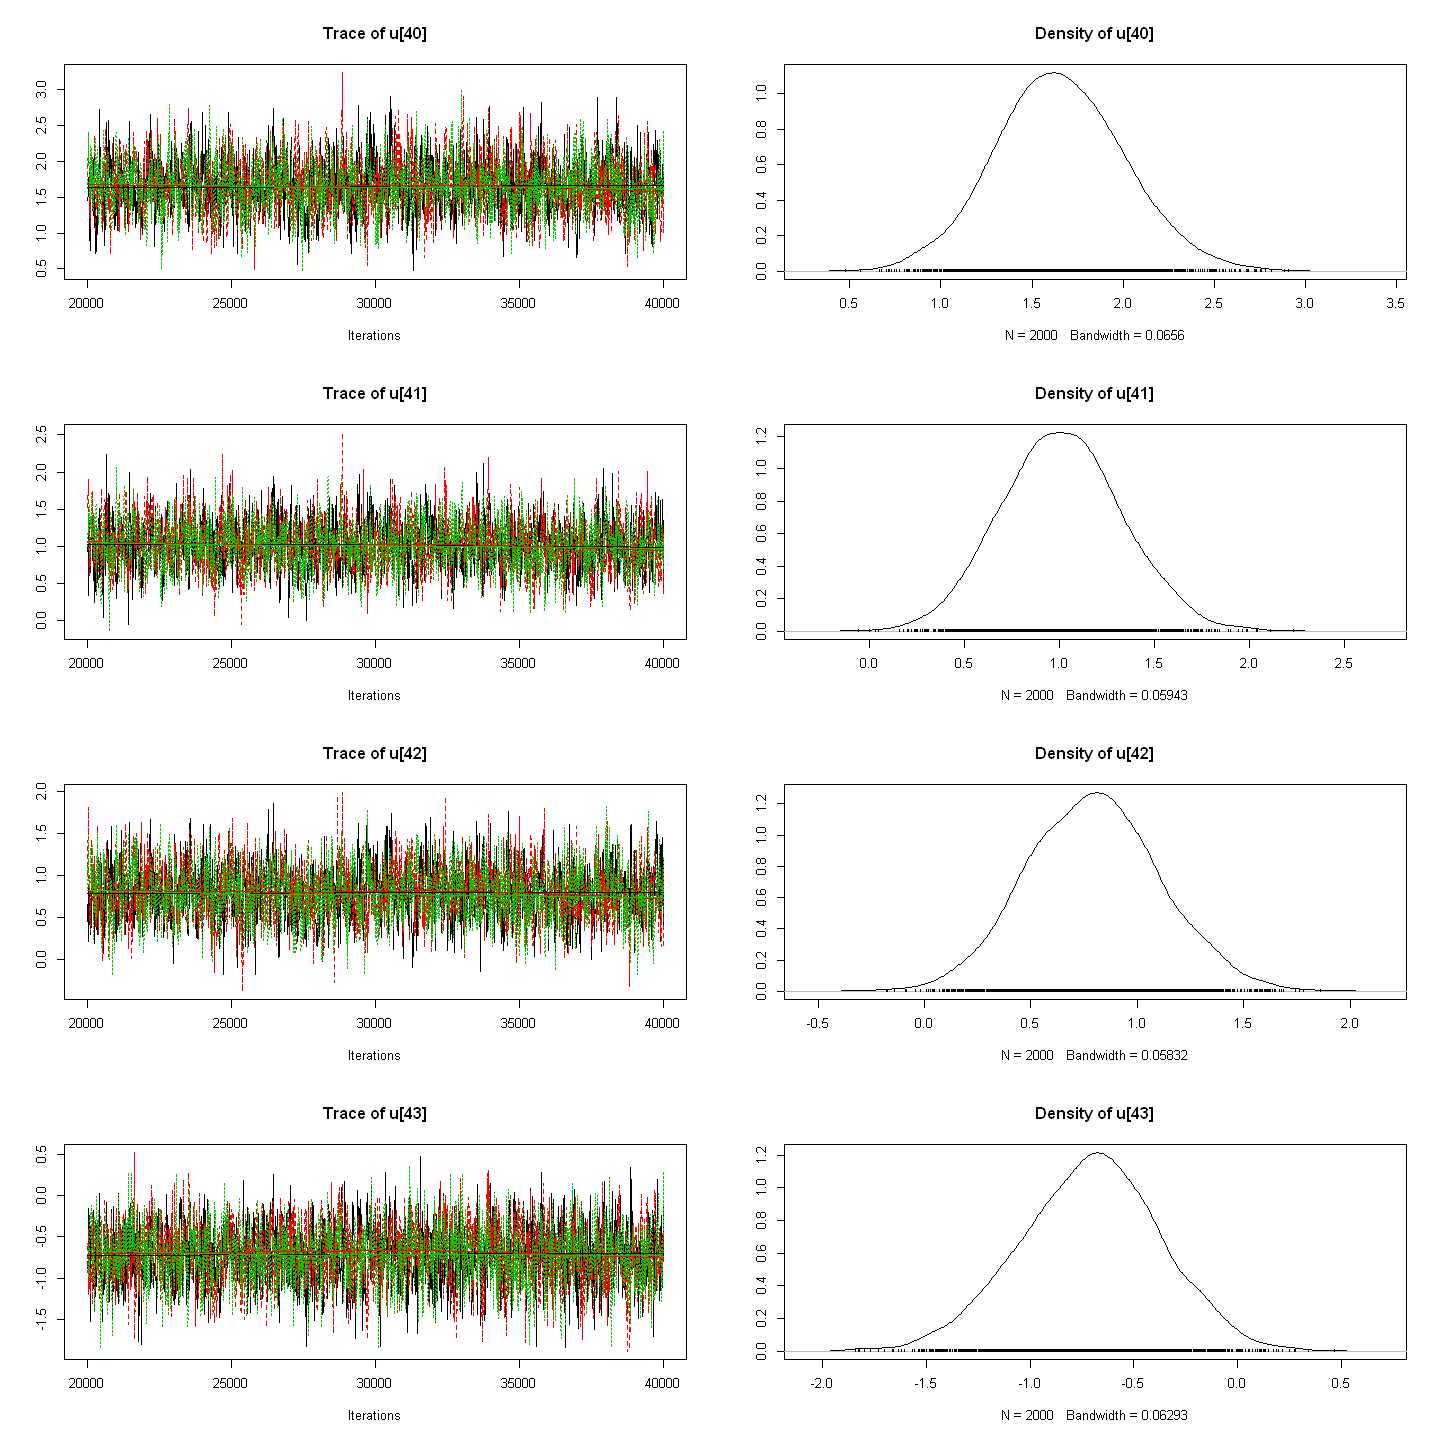

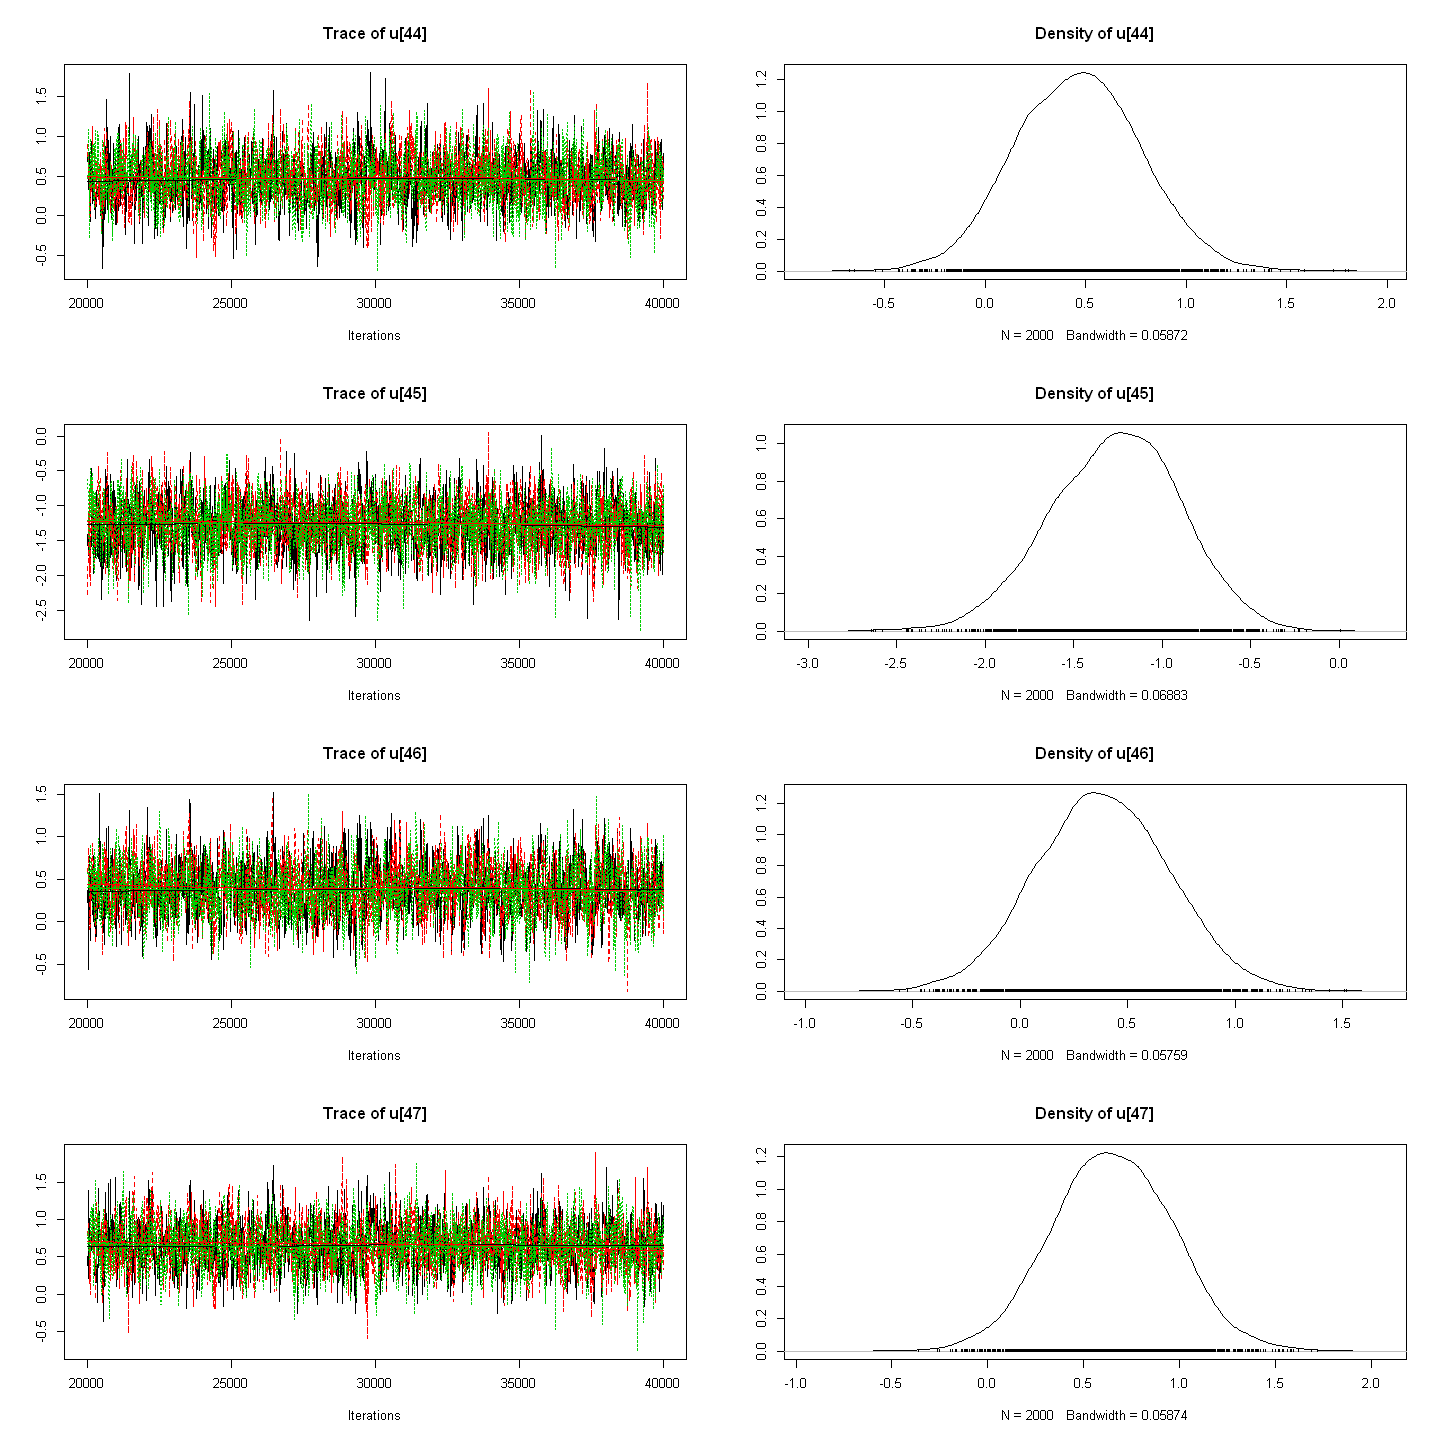

In [14]:
model2 <- jags.model(textConnection(mixed_glm), data=list(y=y,I=I), n.chains = 3, n.adapt= 10000)

#burnin for 10000 samples 
update(model2,10000)

#thinning
mcmc.d <- coda.samples(model2, variable.names=c("a","b","c","d","u","sigma"), n.iter=20000, thin=10)
plot(mcmc.d)

In [15]:
summary(mcmc.d)


Iterations = 20010:40000
Thinning interval = 10 
Number of chains = 3 
Sample size per chain = 2000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

          Mean      SD Naive SE Time-series SE
a     -0.79055 0.16561 0.002138       0.006916
b     -1.54927 0.32140 0.004149       0.006504
c     -0.39181 0.23864 0.003081       0.010161
d      5.15041 0.46241 0.005970       0.009403
sigma  0.73712 0.08848 0.001142       0.001874
u[1]   1.37137 0.32887 0.004246       0.008627
u[2]   0.75444 0.31270 0.004037       0.008834
u[3]  -0.56788 0.34960 0.004513       0.008931
u[4]   0.02515 0.31718 0.004095       0.008805
u[5]  -0.25368 0.32669 0.004218       0.008239
u[6]   0.28537 0.31151 0.004022       0.008719
u[7]  -0.56815 0.34418 0.004443       0.008067
u[8]   1.44161 0.33177 0.004283       0.008672
u[9]   0.10949 0.31602 0.004080       0.008876
u[10]  0.82540 0.31160 0.004023       0.008247
u[11] -0.50913 0.33733 0.004355       0.008521
u

In [16]:
CI <- summary(mcmc.d)$quantiles[c(3,4),c(1,5)]; CI

2.5%       97.5%     
c -0.8595203 0.07622359
d  4.2382081 6.04302193

* c의 추정값 : -0.39181, 95% CI : (-0.85952, 0.07622) 
* d의 추정값 : 5.15041, 95% CI : (4.2382, 6.0430) 
* c는 0을 포함하므로 유의하지 않다고 할 수 있으며, d는 0을 포함하지 않으므로 유의한 효과가 있다고 할 수 있다.

### (e) GLM vs GLMM 

* GLM은 전체 모형의 평균적인 효과를 한 눈에 볼 수 있다.   
* GLMM은 개체 별 특성을 고려해 줄 수 있다. (환자 별 병의 진행도의 차이 등)  

### (f) GLMM 에서의 random effect 비교 (a vs a*)

In [17]:
alphastar<-log((y$y0+1/2)/(30-y$y0+1/2))
mcmc.d.alpha <- coda.samples(model2,variable.names=c("alpha"),n.iter=20000, thin=10)
alpha<-summary(mcmc.d.alpha)$statistics[,1]

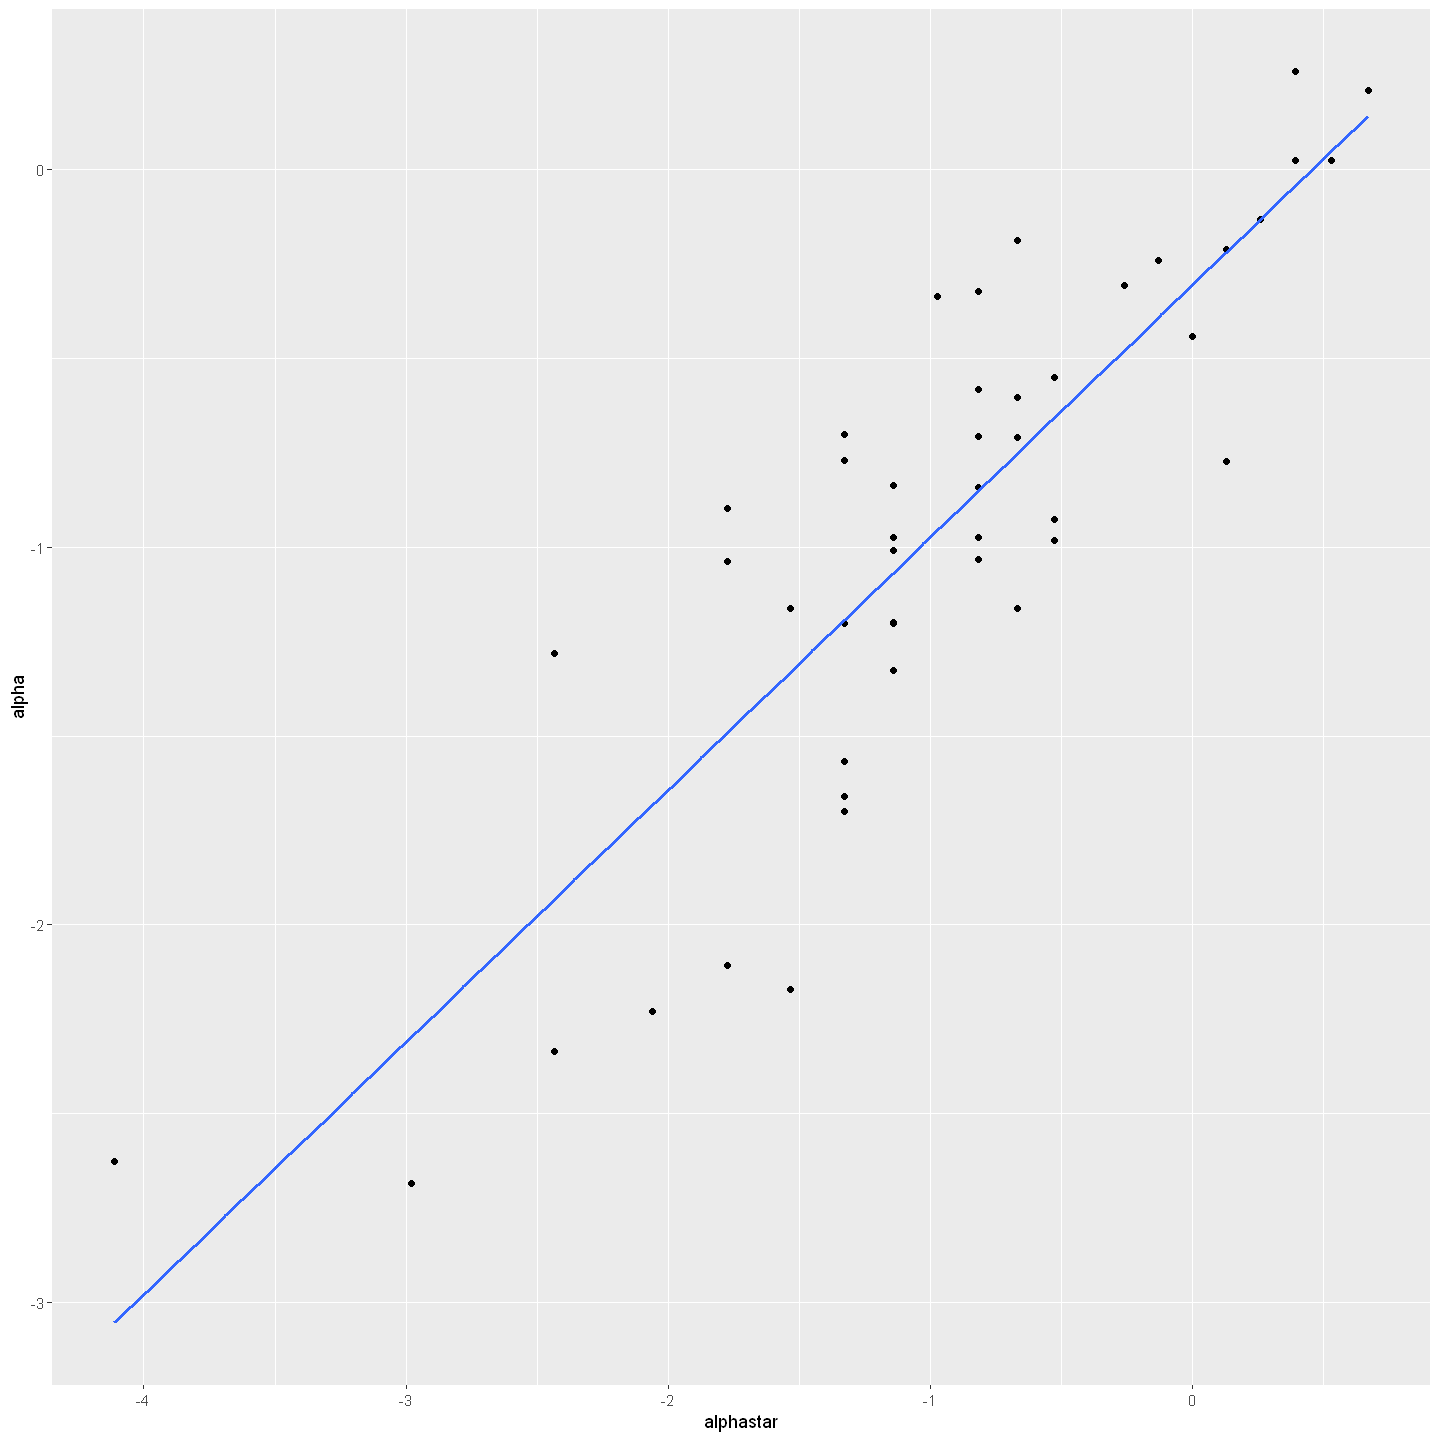

In [20]:
alphapoint<-data.frame(cbind(data.frame(alpha),alphastar))
ggplot(alphapoint,aes(alphastar,alpha))+geom_point()+geom_smooth(method="lm",se=F)

In [19]:
fit <- lm(alpha~alphastar)
coef <- summary(fit); coef$coeff[,1]

(Intercept)   alphastar 
 -0.3051622   0.6687723

* $\alpha$와 $\alpha^*$ 가 선형관계에 있다는 것을 확인할 수 있다. 
* 이를 통해 Mixed effects model에서 추정된 random effect alpha와        
  첫번째 시험점수 $y_{i0}$에서 추정된 $\alpha^*$이 비슷하게 추정되었음을 알 수 있다.   

## PART 2. 비선형 Mixed effect 모형을 이용한 상어 성장곡선 추정 

In [21]:
shark<-read.csv("Shark.csv")
shark<-shark[1:36,]

### (a) Bayes 방법으로 일반화 선형모형 (GLM) 적합

#### Fixed effects Nonlinear GLM 
$y_i = g(x_i,t_i,s_i ; a,b,c_1,c_2) + e_i, e_i$ ~ $N(0, \sigma^2)$          
$g(x_i,t_i,s_i ; a,b,c_1,c_2) = a_i - (a_i - x_i)e^{-b_it_i}$            



$y_i = L(t_{i2}), i=1,...,n$       
$x_i = L(t_{i1})$      
$t_i = (t_{i2}-t_{i1})/365.25$ (years)       



$a_i = L_{i\infty} = a+c_1s_i$       
$b_i = k_i = b+c_2s_i$       
$s_i = 0$ if F / $1$ if M        

In [22]:
y<-shark$L2
x<-shark$L1
t<-shark$Days/365.25
s<-shark$Gender

In [23]:
fixed_glm<-"model{

for (i in 1:length(y)) {
  y[i] ~ dnorm(mu[i],tau)
  mu[i]<-alpha[i]-(alpha[i]-x[i])*exp(-beta[i]*t[i])
  alpha[i]<-a+c1*s[i]
  beta[i]<-b+c2*s[i]
  }

a ~ dunif(0,400)
b ~ dunif(-100,100)
c1 ~ dunif(-100,100)
c2 ~ dunif(-100,100)
sigma ~ dunif(0,50)
tau<-1/pow(sigma,2)

}"

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 36
   Unobserved stochastic nodes: 5
   Total graph size: 347

Initializing model



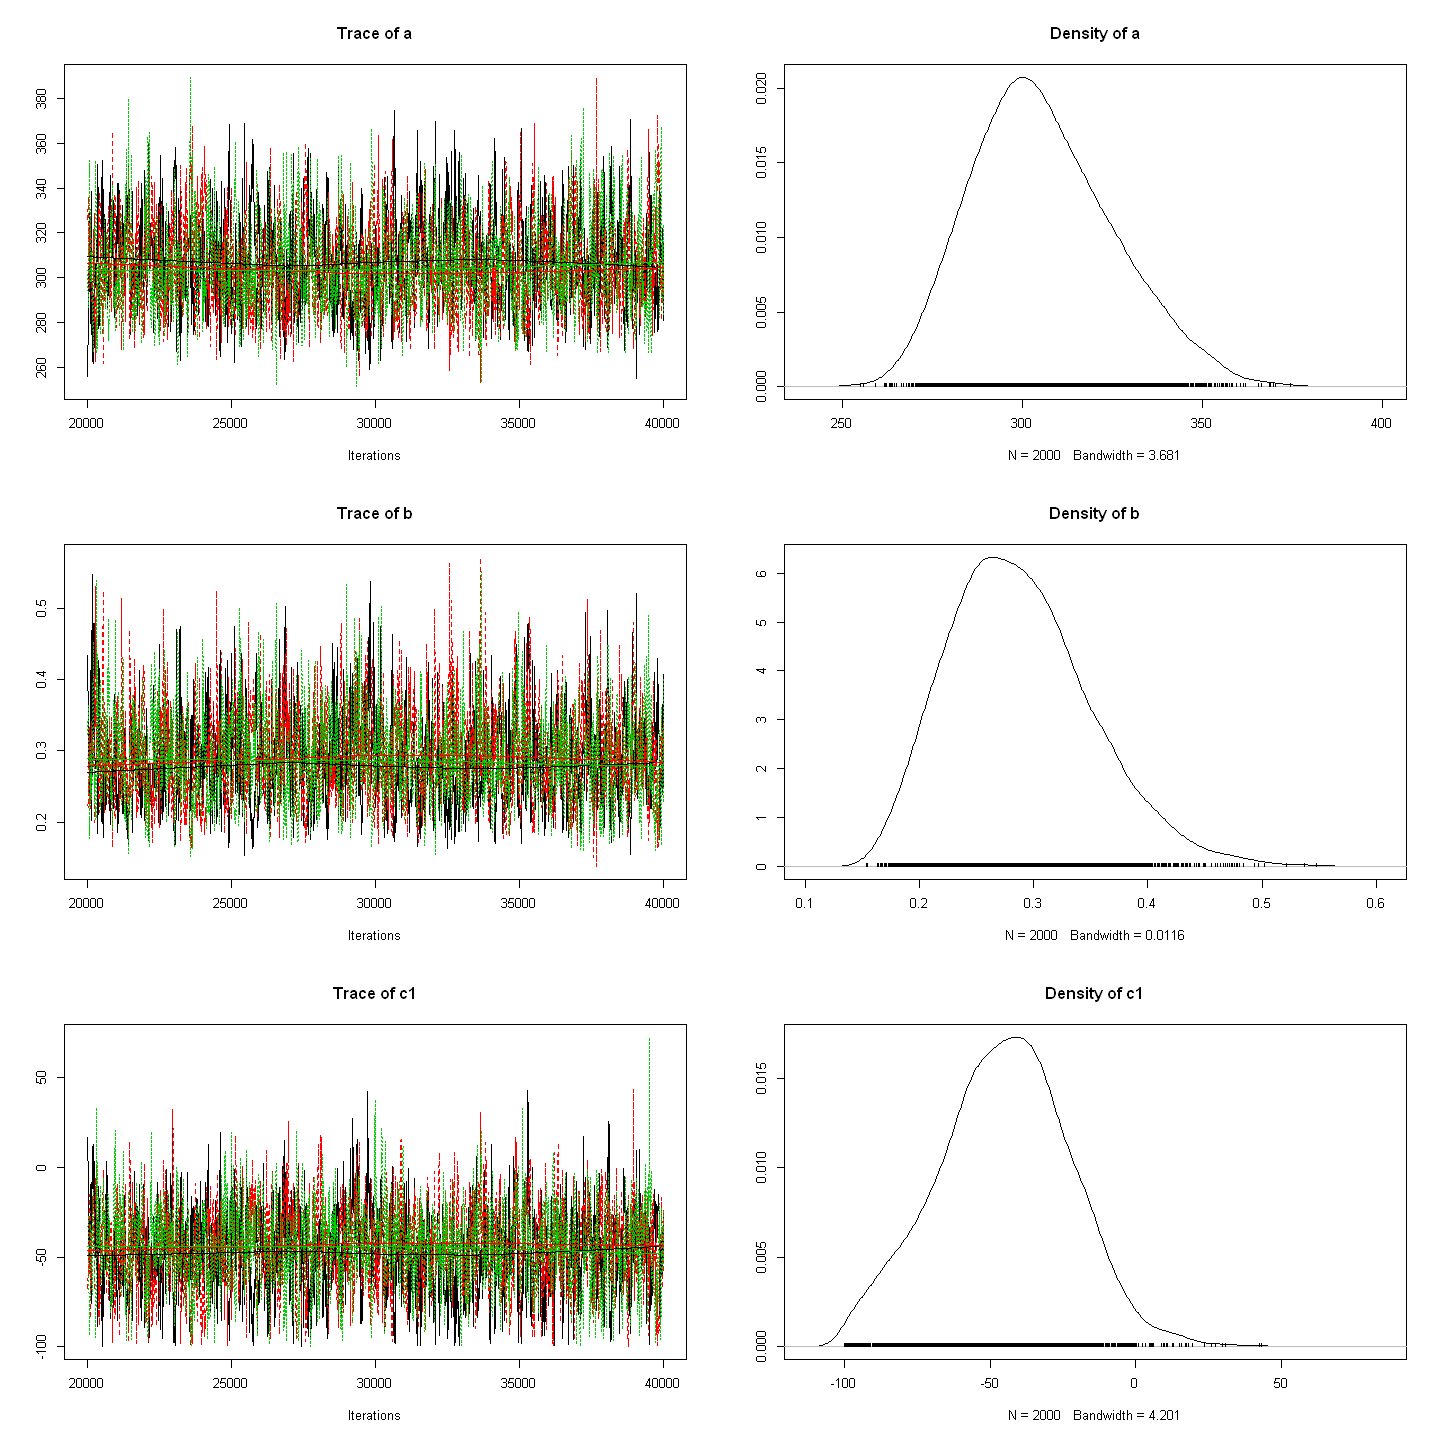

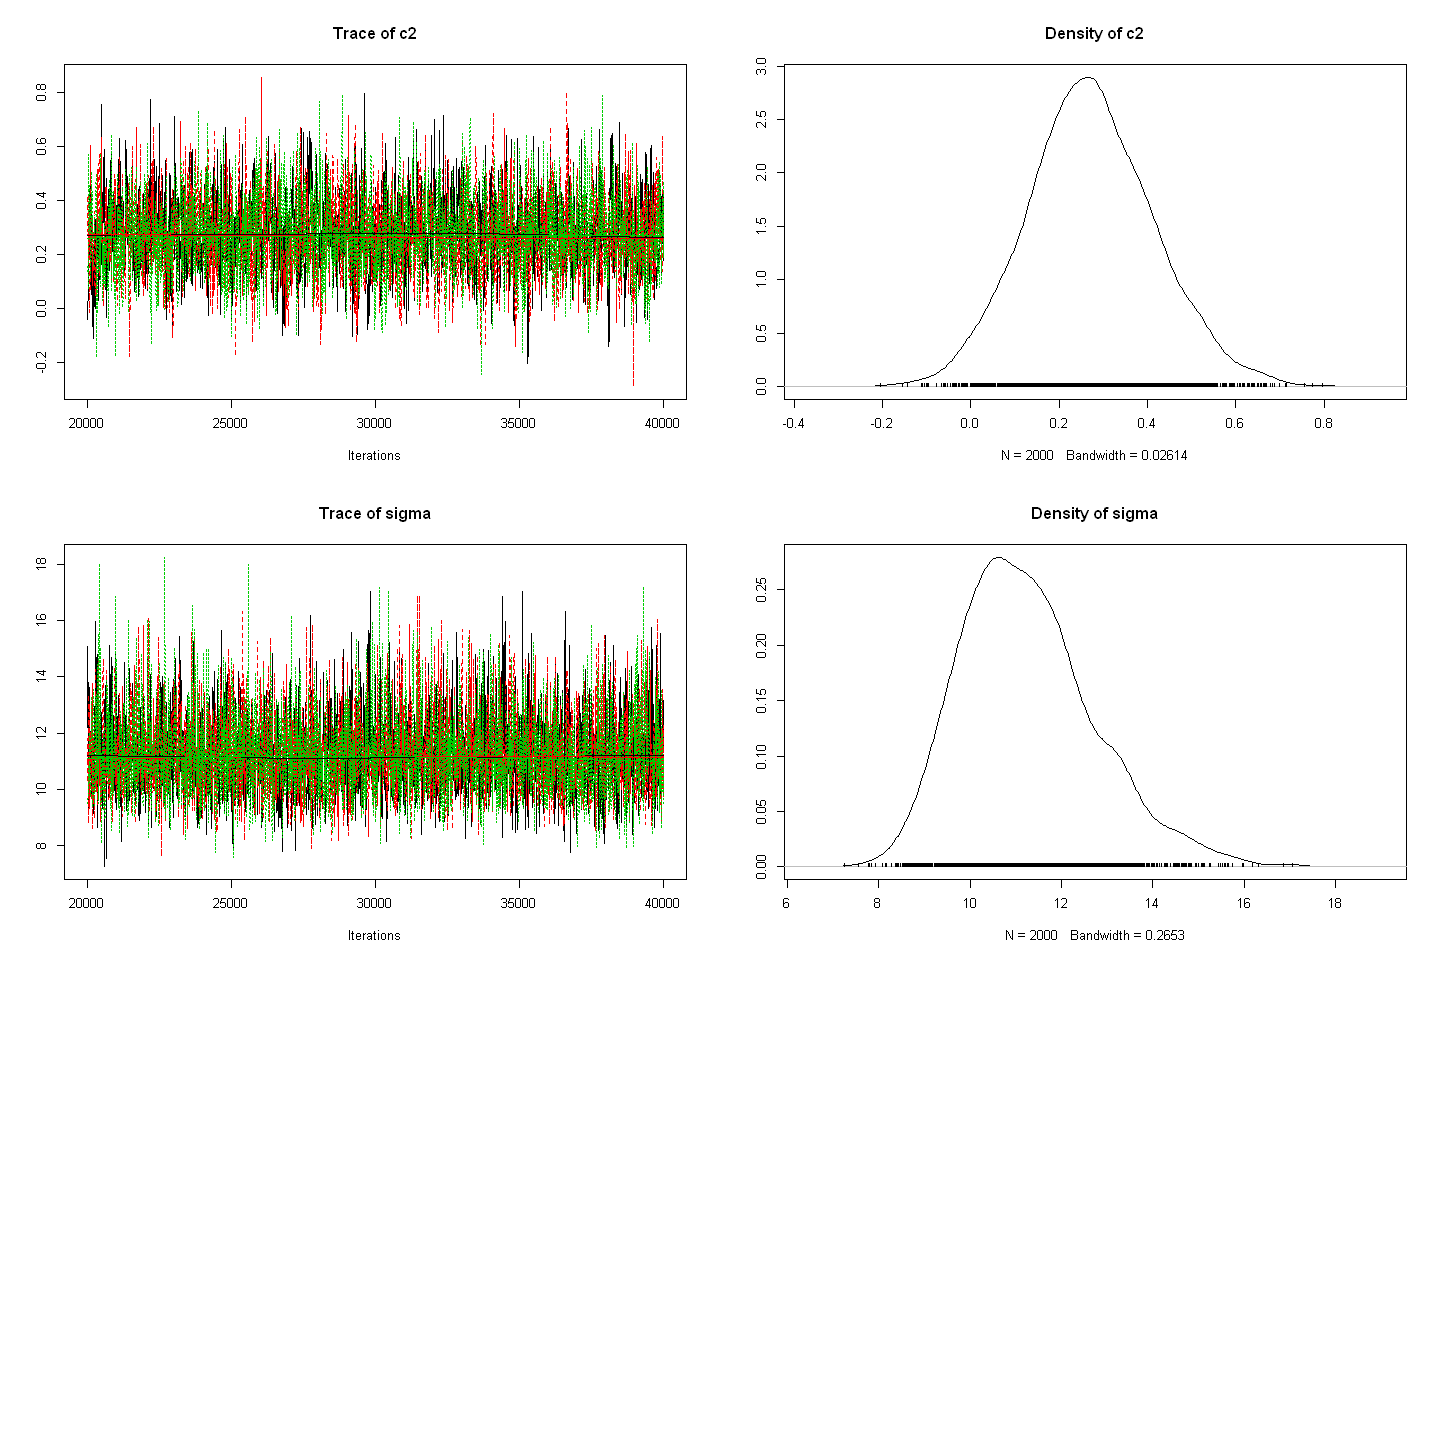

In [24]:
model <- jags.model(textConnection(fixed_glm),data=list(t=t,x=x,y=y,s=s),n.chains=3,n.adapt=10000)

#burnin for 10000 samples 
update(model,10000)

#thinning
mcmc.shark <- coda.samples(model, variable.names=c("a","b","c1","c2","sigma"), n.iter=20000, thin=10)
plot(mcmc.shark)

In [25]:
summary(mcmc.shark)


Iterations = 20010:40000
Thinning interval = 10 
Number of chains = 3 
Sample size per chain = 2000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

          Mean       SD  Naive SE Time-series SE
a     305.7943 19.78305 0.2553981       0.550018
b       0.2885  0.06276 0.0008102       0.001656
c1    -45.2419 22.85636 0.2950744       0.597714
c2      0.2720  0.14453 0.0018659       0.002644
sigma  11.2673  1.47801 0.0190810       0.019610

2. Quantiles for each variable:

            2.5%      25%      50%      75%    97.5%
a     272.188330 291.4744 303.8463 318.5247 348.9604
b       0.184863   0.2429   0.2825   0.3265   0.4266
c1    -90.522498 -60.2119 -44.9334 -29.9599  -1.8062
c2     -0.004402   0.1763   0.2677   0.3646   0.5694
sigma   8.852814  10.2083  11.1134  12.1189  14.6620


### (b) GLM : 성별 간 성장모수의 차이 검토 

In [26]:
cbind(summary(mcmc.shark)$statistics[c(3,4),1], summary(mcmc.shark)$quantiles[c(3,4),c(1,5)])

2.5%          97.5%     
c1 -45.241876 -90.522498228 -1.8062101
c2   0.272048  -0.004401839  0.5694469

* c1은 신뢰구간에서 0을 포함하지 않아 유의한 모수라고 할 수 있고,         
  c2는 신뢰구간에서 0을 포함하므로 유의미하지 않은 모수라고 할 수 있다. 
* c1이 음수인 것으로 보아 암컷의 최대성장길이가 수컷보다 클 것이라고 예상할 수 있다. 
* 반면, 성장률은 수컷이 더 크게 나타난다고 생각할 수 있다. 

### (c) Bayes 방법으로 혼합형 선형모형 (GLMM) 적합

#### Mixed effects Nonlinear GLM 
$y_i = g(x_i,t_i,s_i ; a,b,c_1,c_2,u_i,v_i,\sigma_a, \sigma_b) + e_i, e_i$ ~ $N(0, \sigma_e^2)$          
$g(x_i,t_i,s_i ; a,b,c_1,c_2,u_i,v_i,\sigma_a, \sigma_b) = a_i - (a_i - x_i)e^{-b_it_i}$            


$a_i = L_{i\infty} = a+u_i\sigma_a+c_1s_i,  i = 1,...,n$       
$b_i = k_i = b+v_i\sigma_b+c_2s_i$       
$u_i$ ~ $N(0,1)$        
$v_i$ ~ $N(0,1)$   

In [27]:
mixed_glm <- "model{

for(i in 1:length(y)) {
  y[i] ~ dnorm(alpha[i]-(alpha[i]-x[i])*exp(-beta[i]*t[i]), tau)
  alpha[i] <- a+u[i]*sigma.a+c1*s[i]
  beta[i] <- b+v[i]*sigma.b+c2*s[i]
  u[i] ~ dnorm(0,1)
  v[i] ~ dnorm(0,1)
}

a ~ dunif(100,300) 
b ~ dunif(0,1) 
c1 ~ dunif(-100,100)
c2 ~ dunif(0,1)
sigma ~ dunif(0, 20)
sigma.a ~ dunif(0,30)
sigma.b ~ dunif(0,1)
tau <- 1 / pow(sigma, 2)
}"

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 36
   Unobserved stochastic nodes: 79
   Total graph size: 597

Initializing model



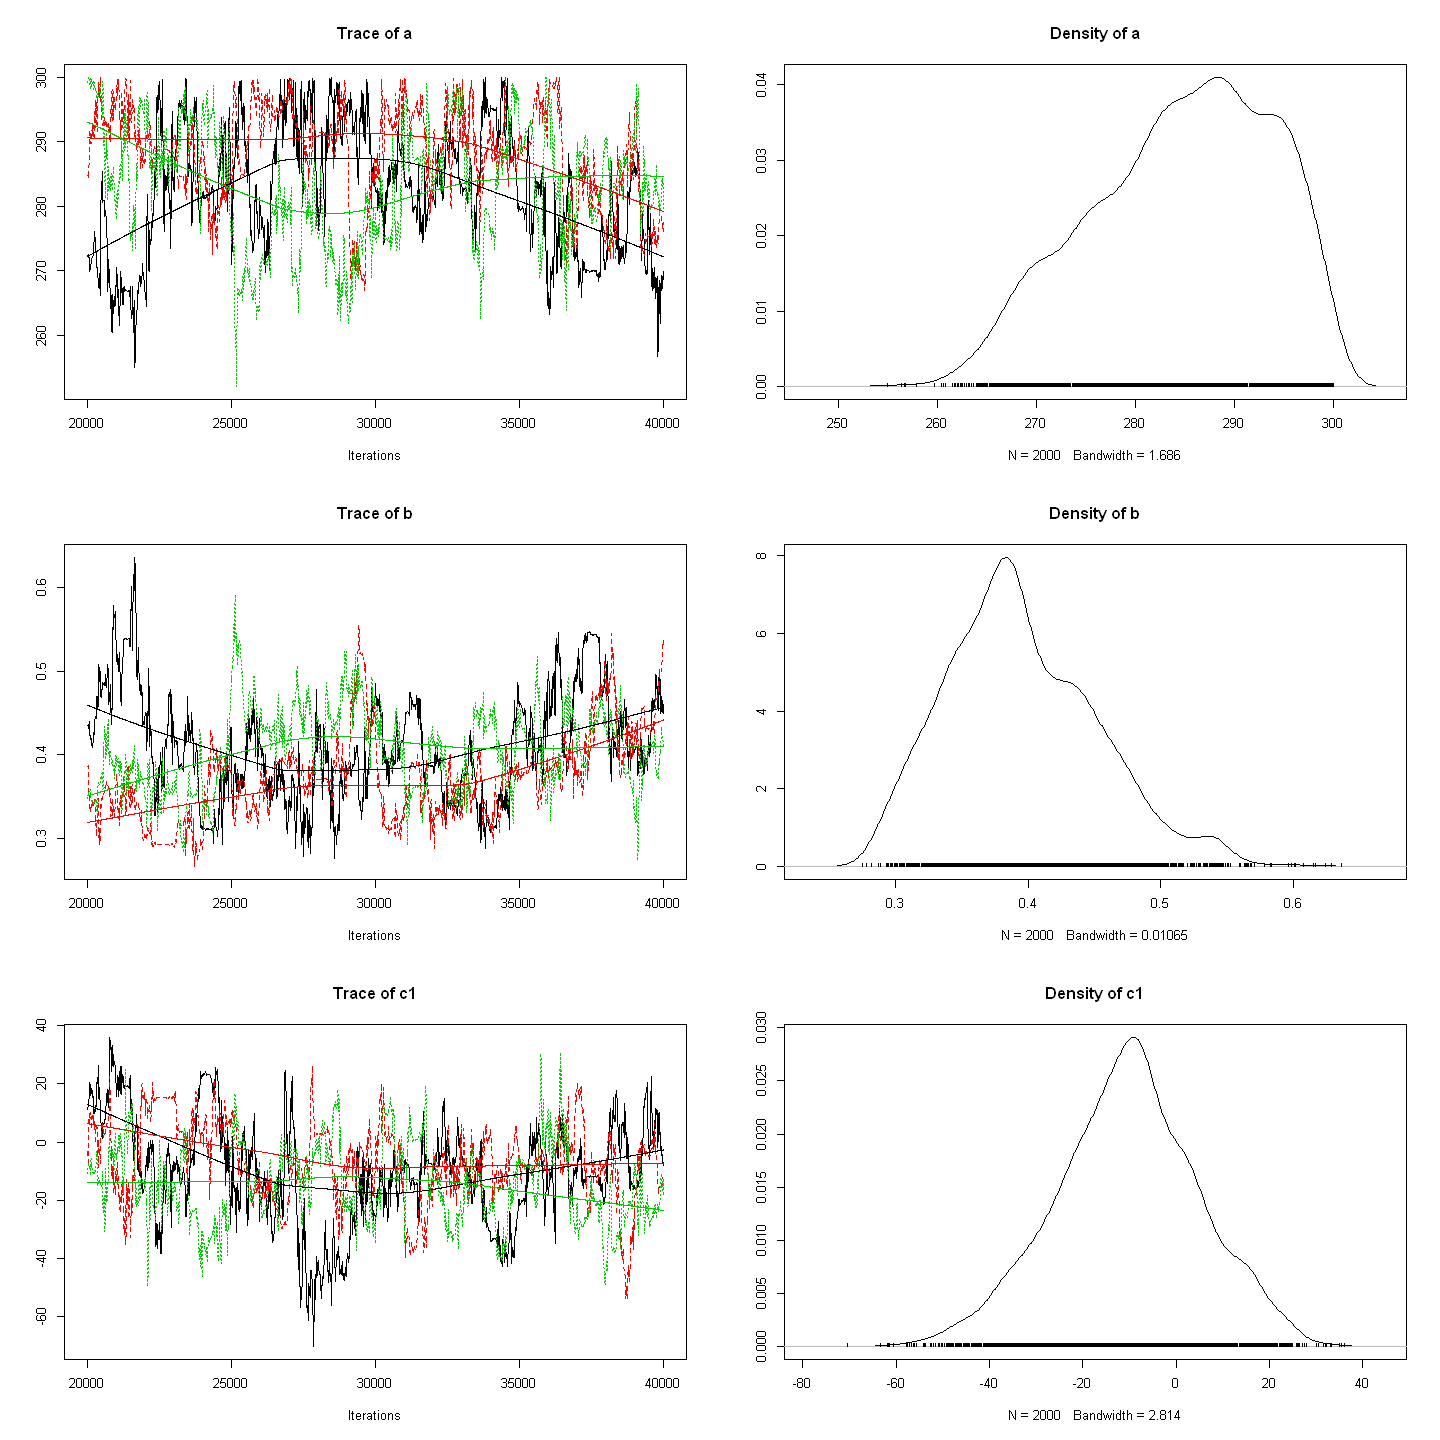

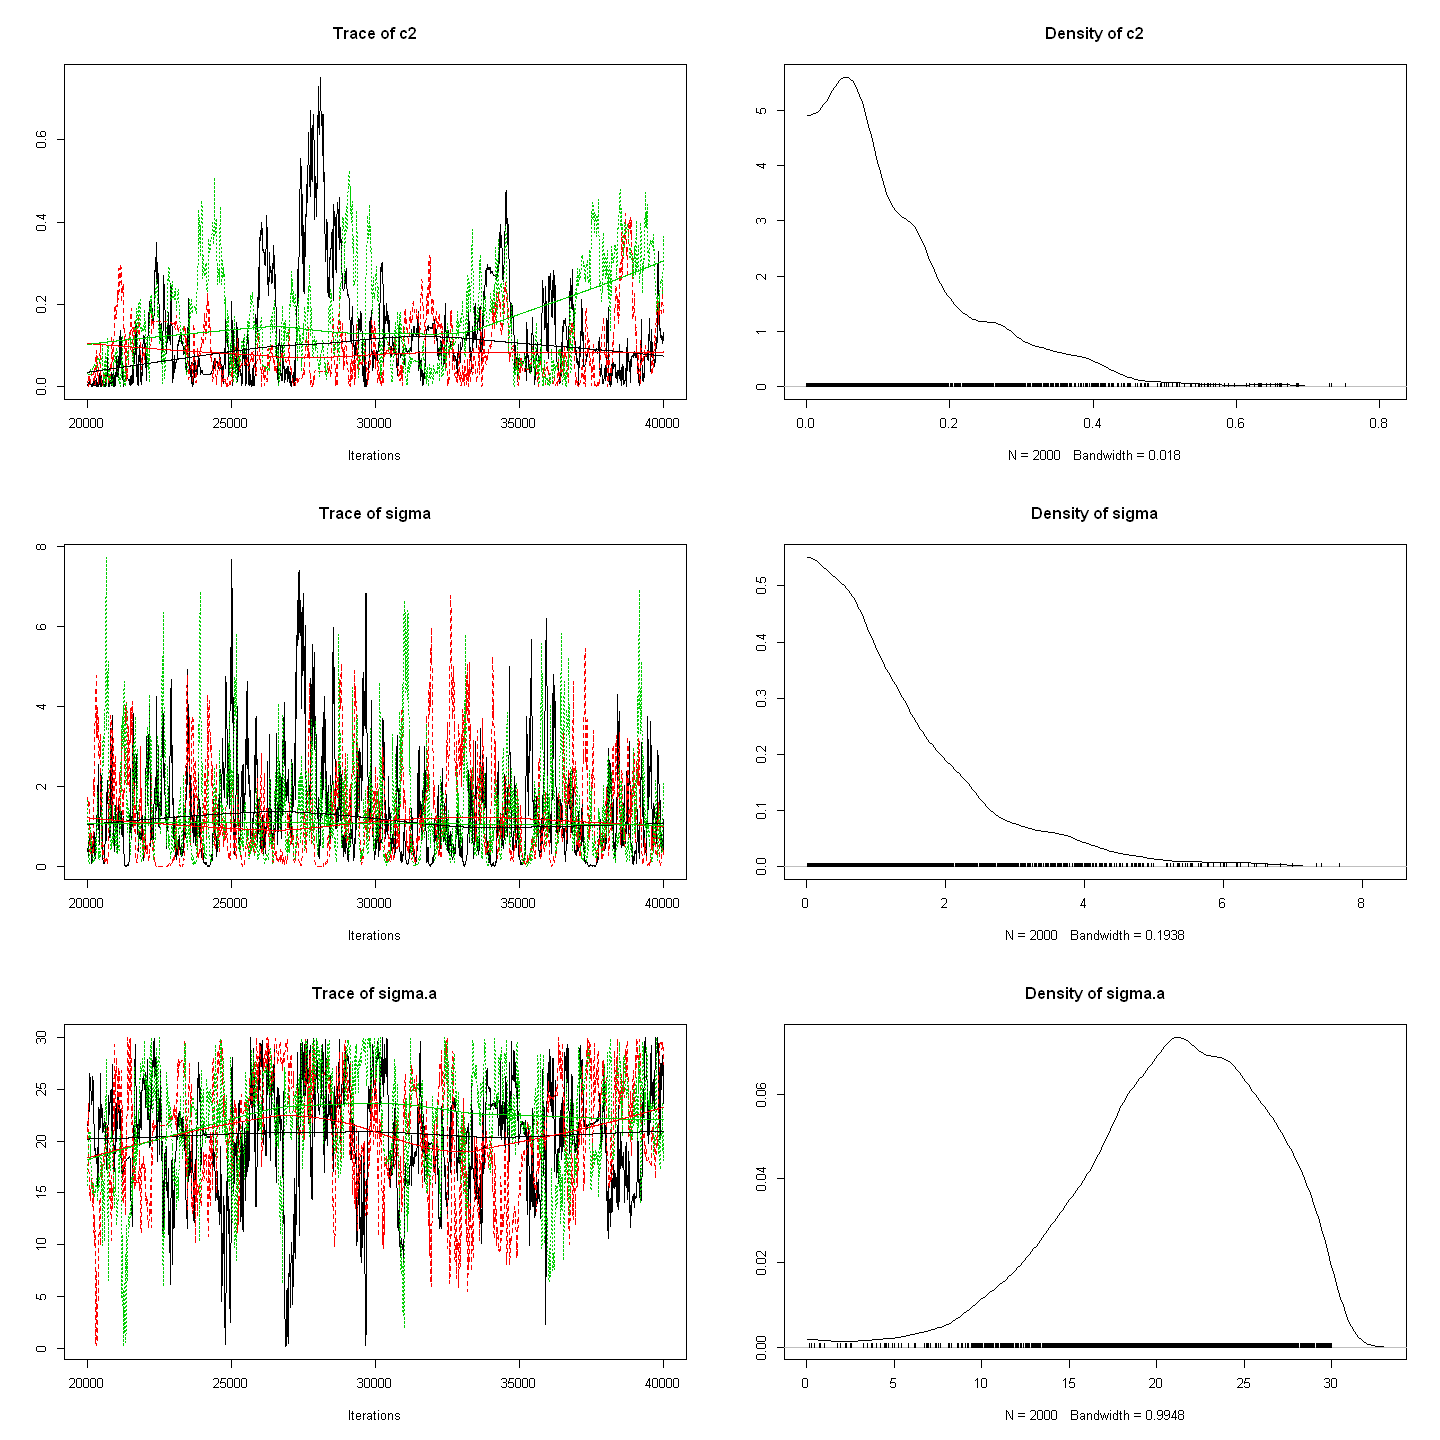

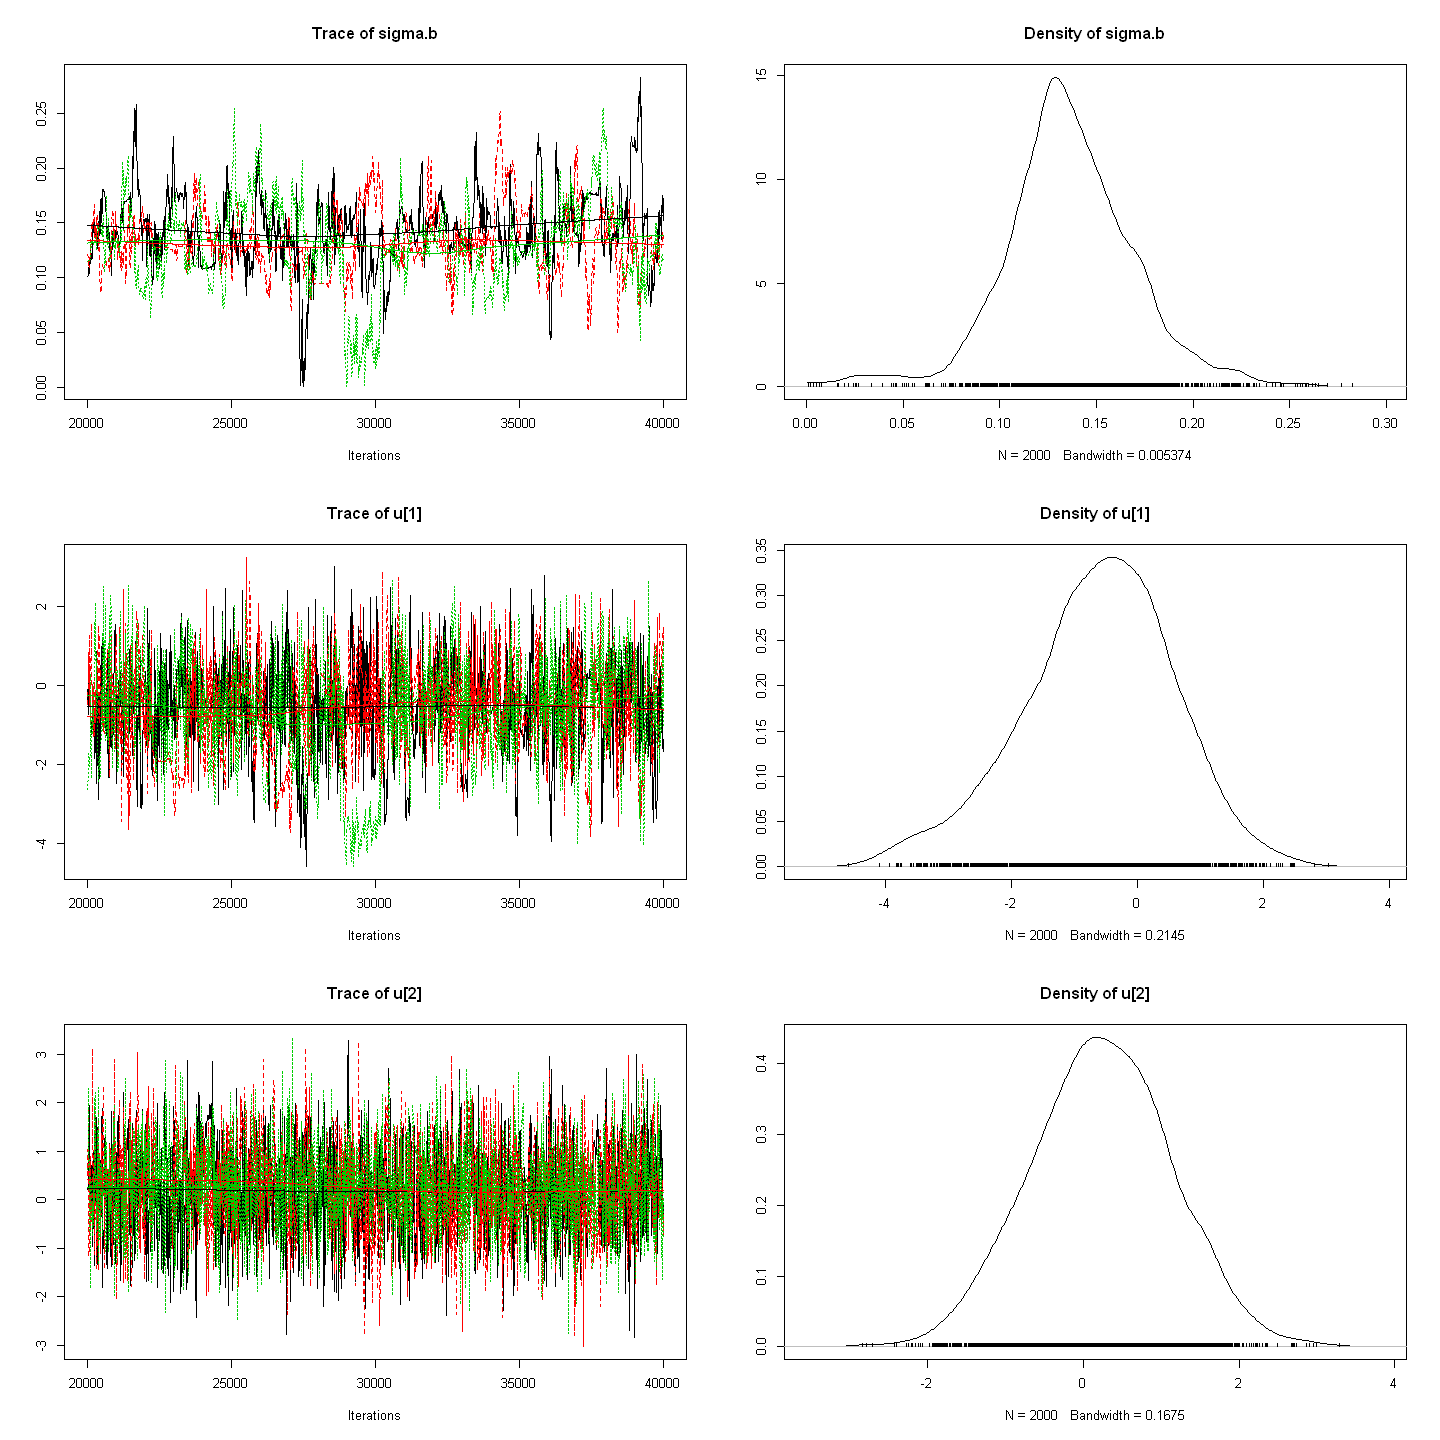

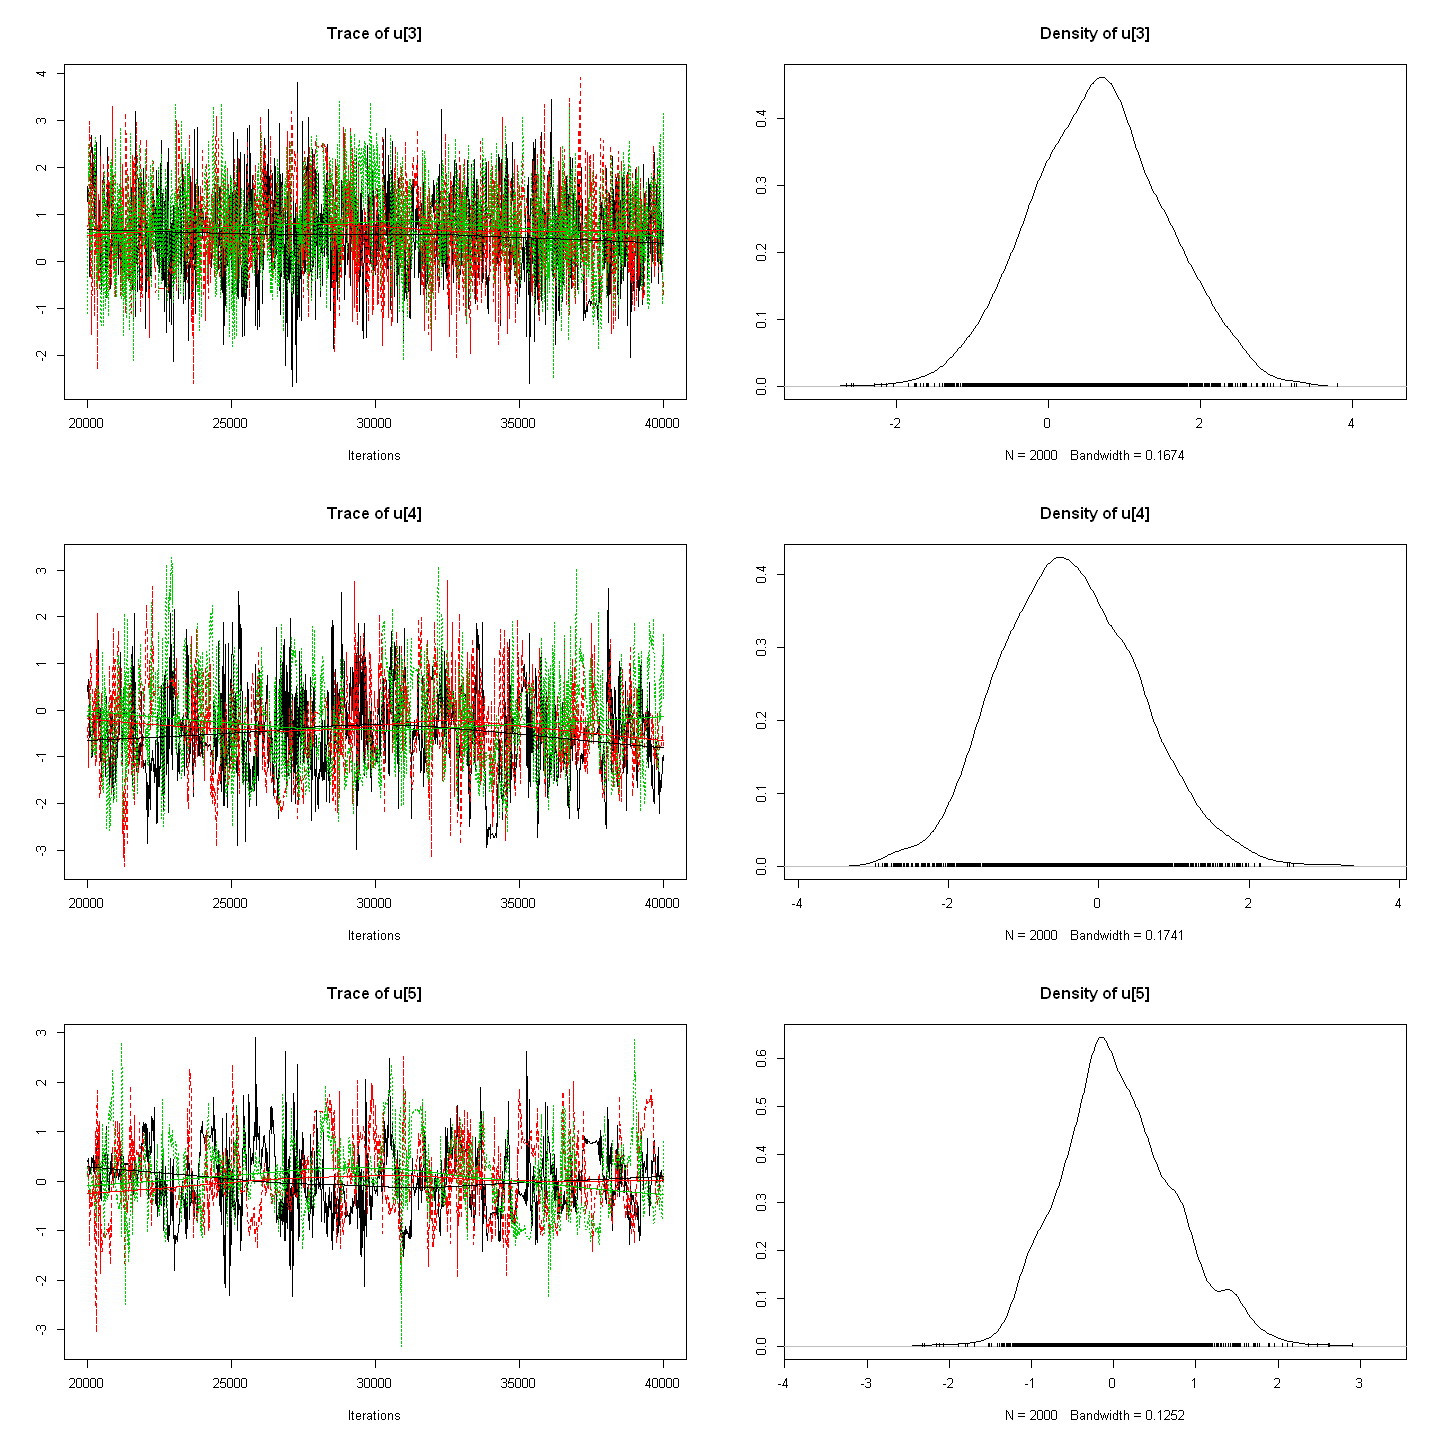

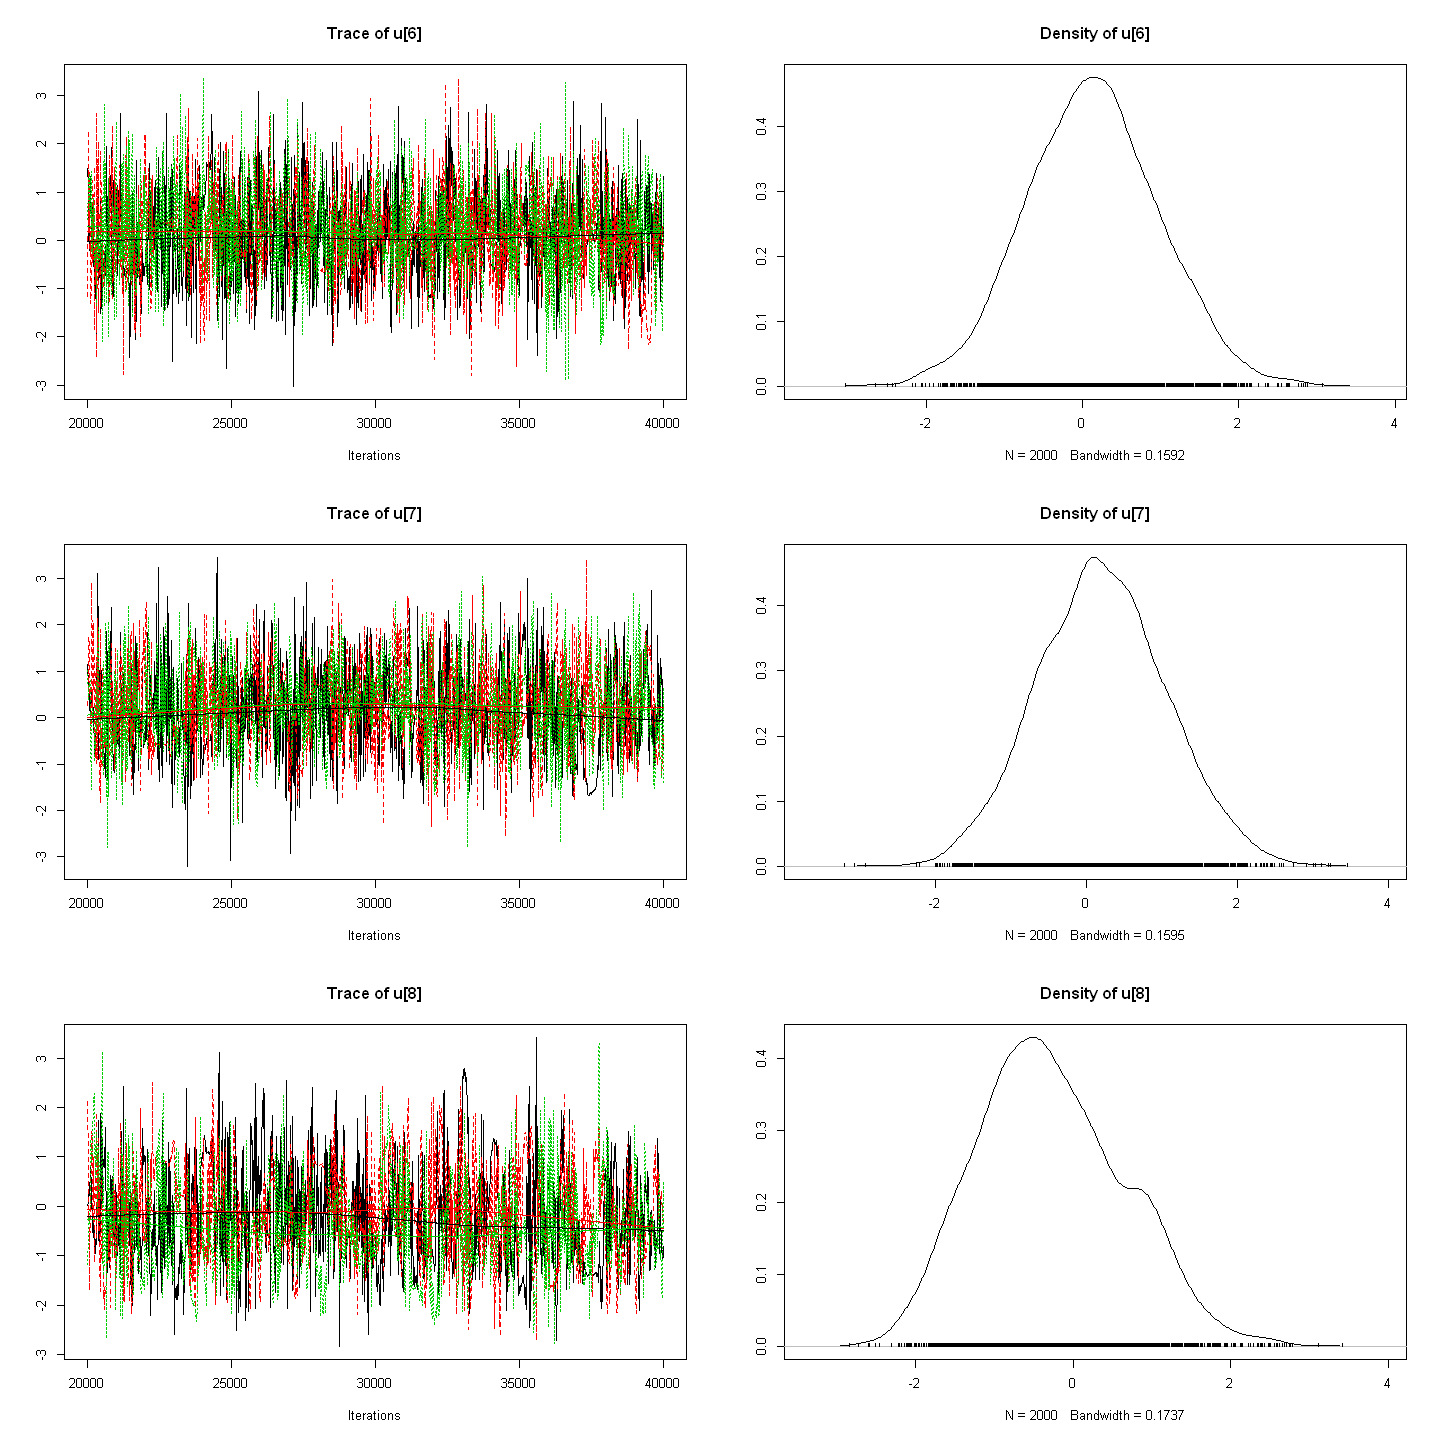

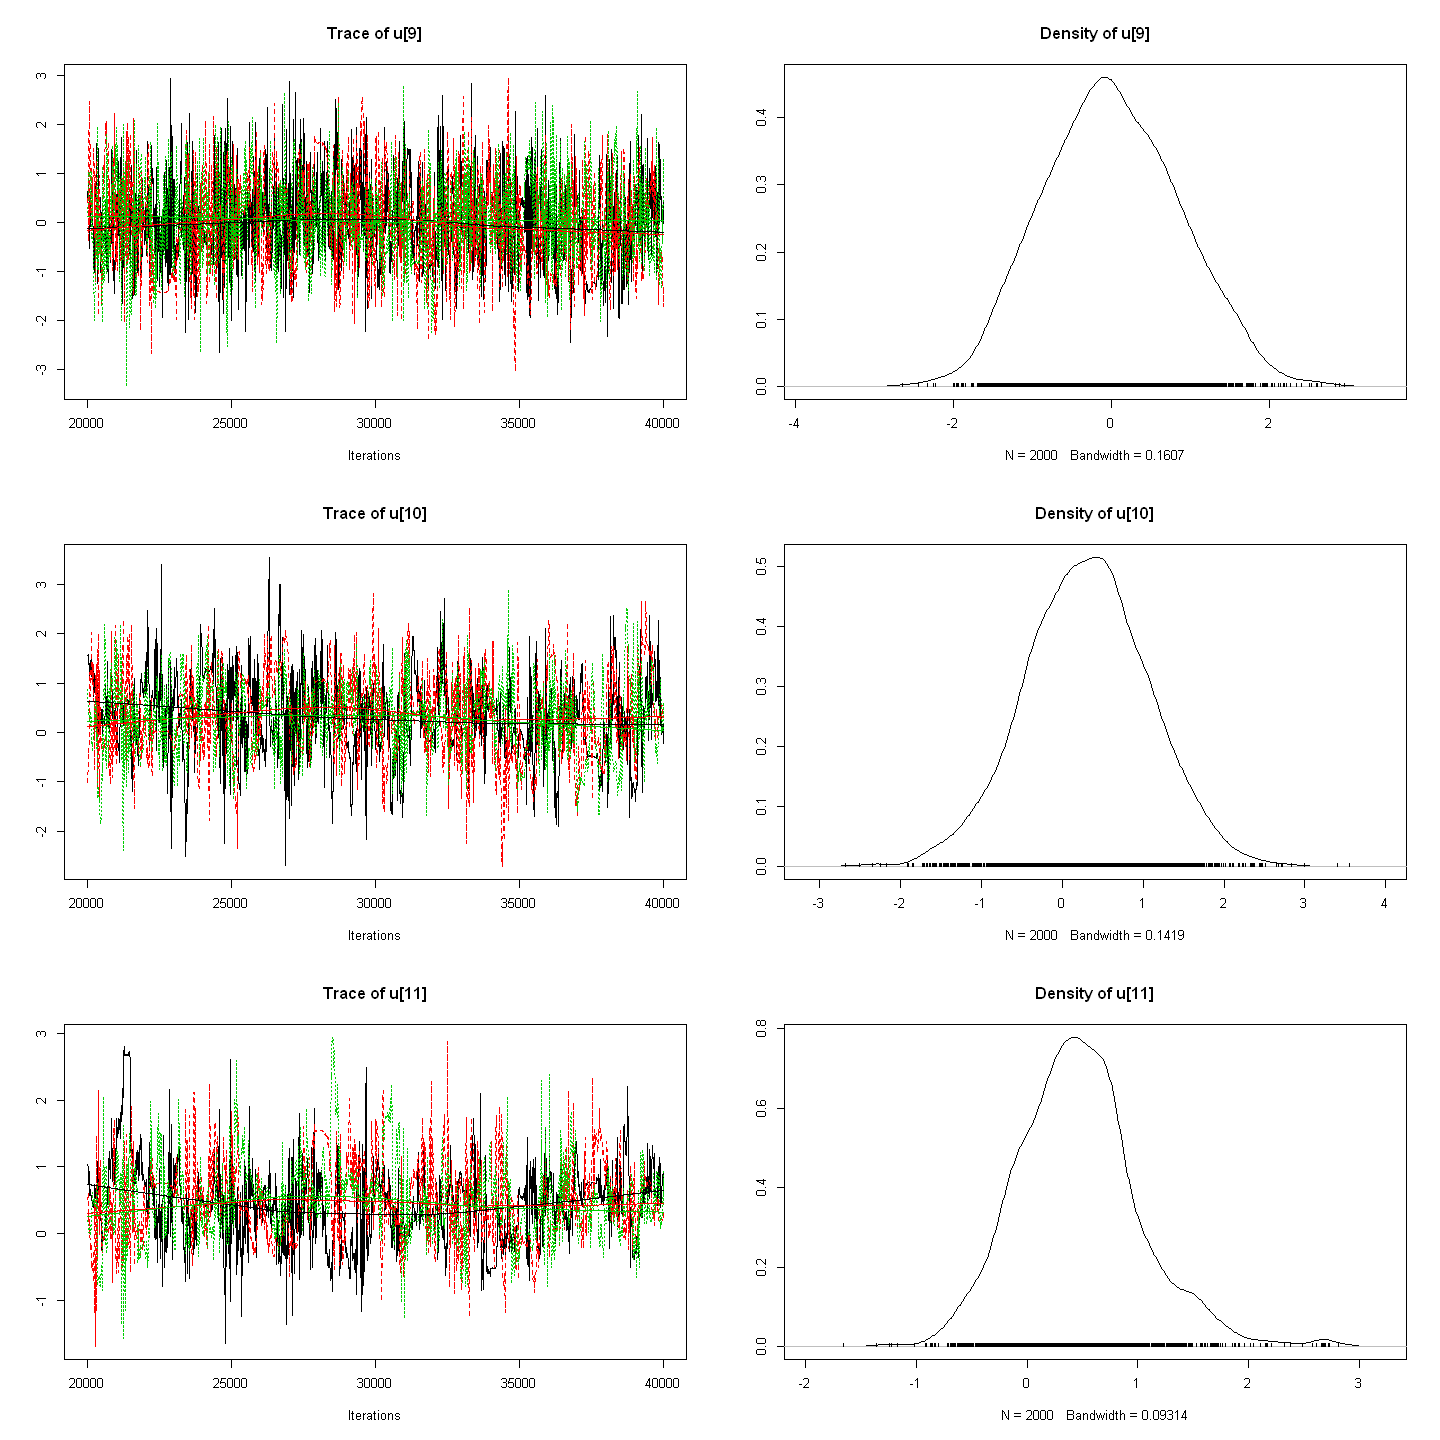

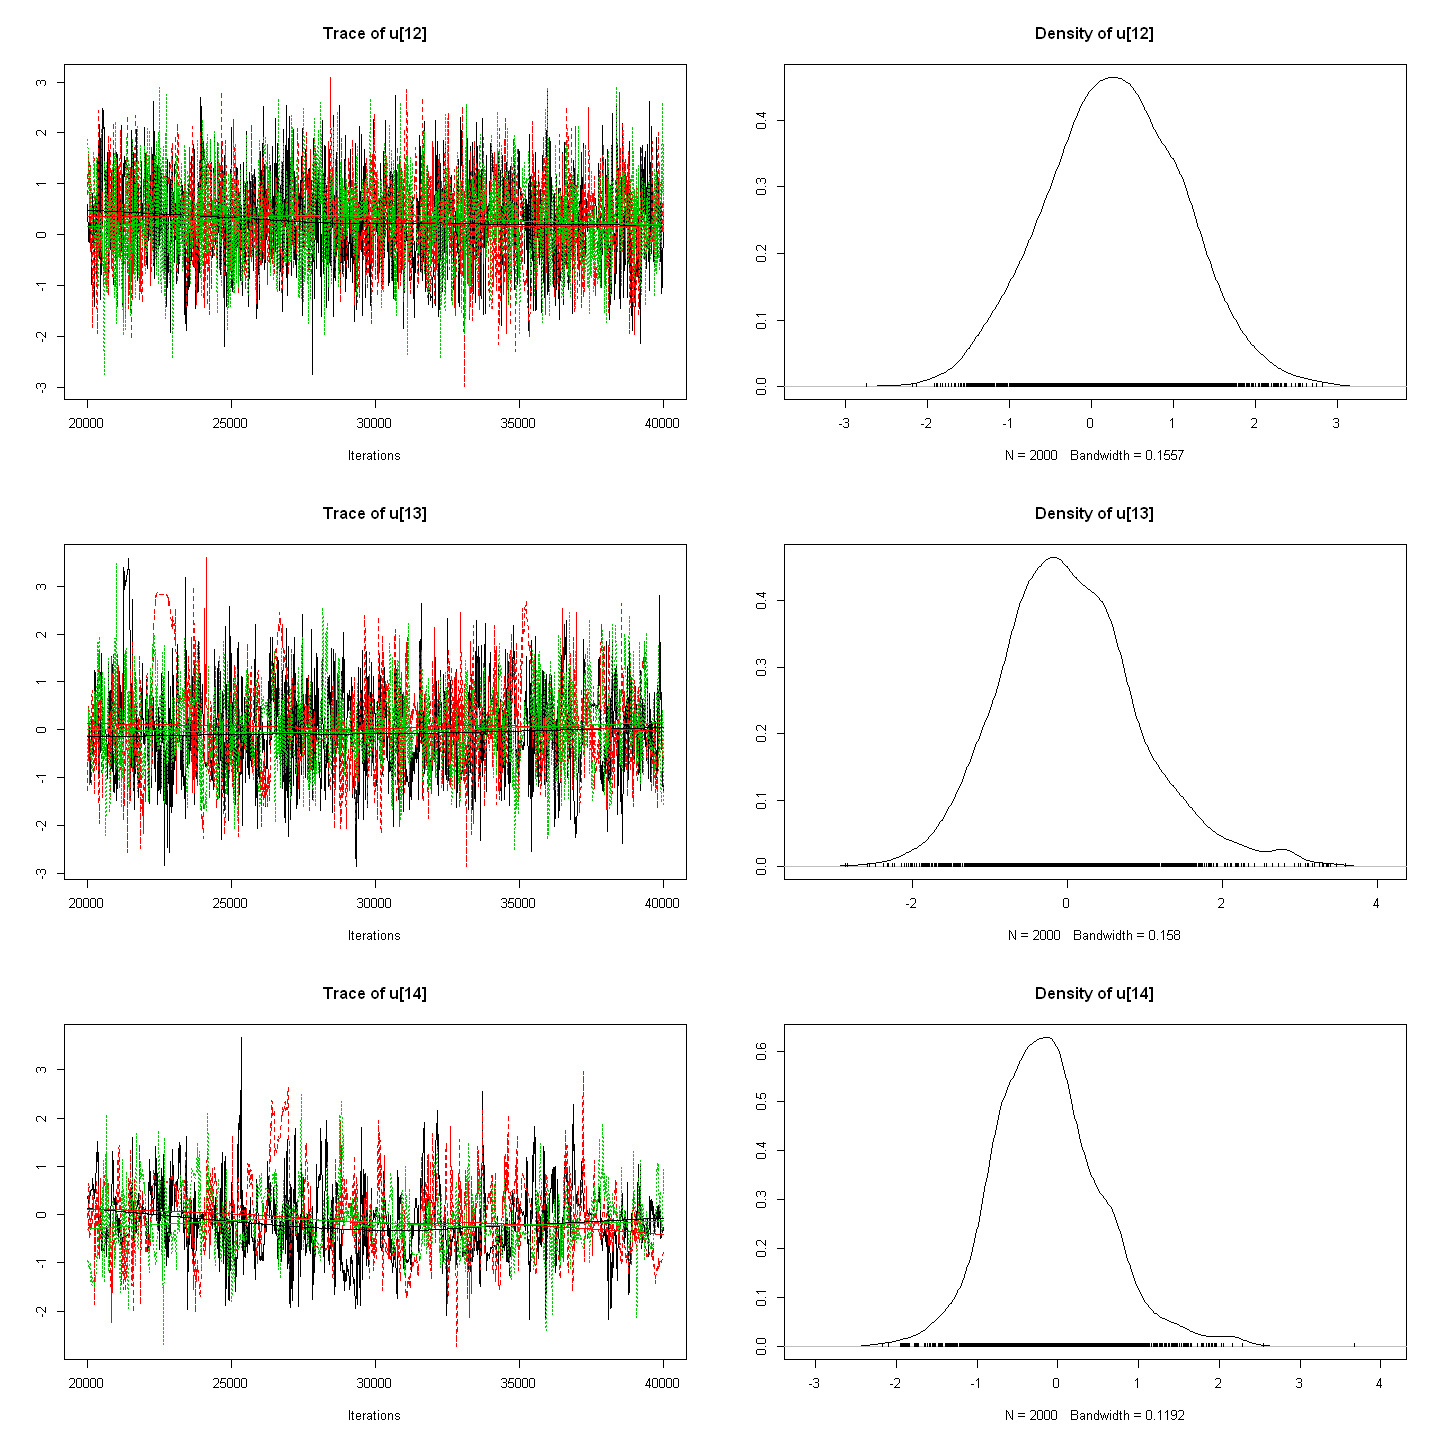

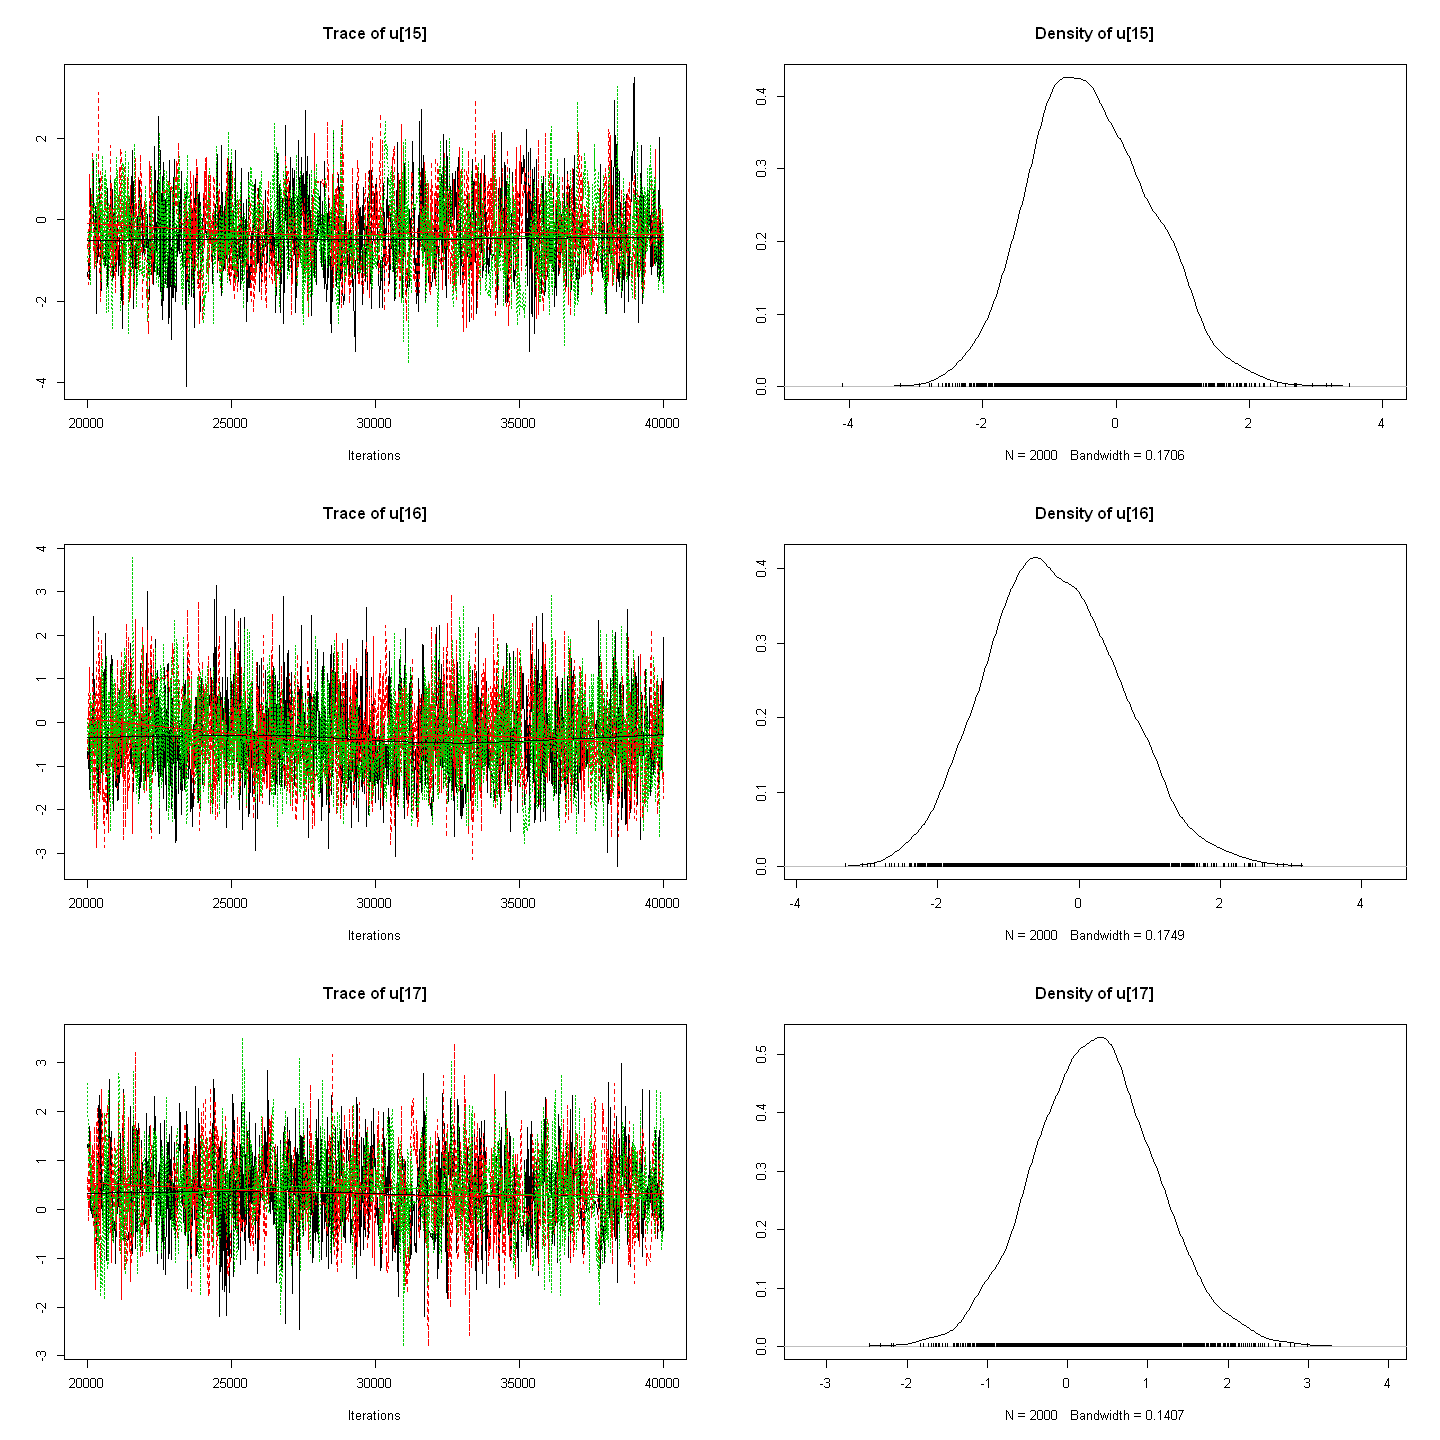

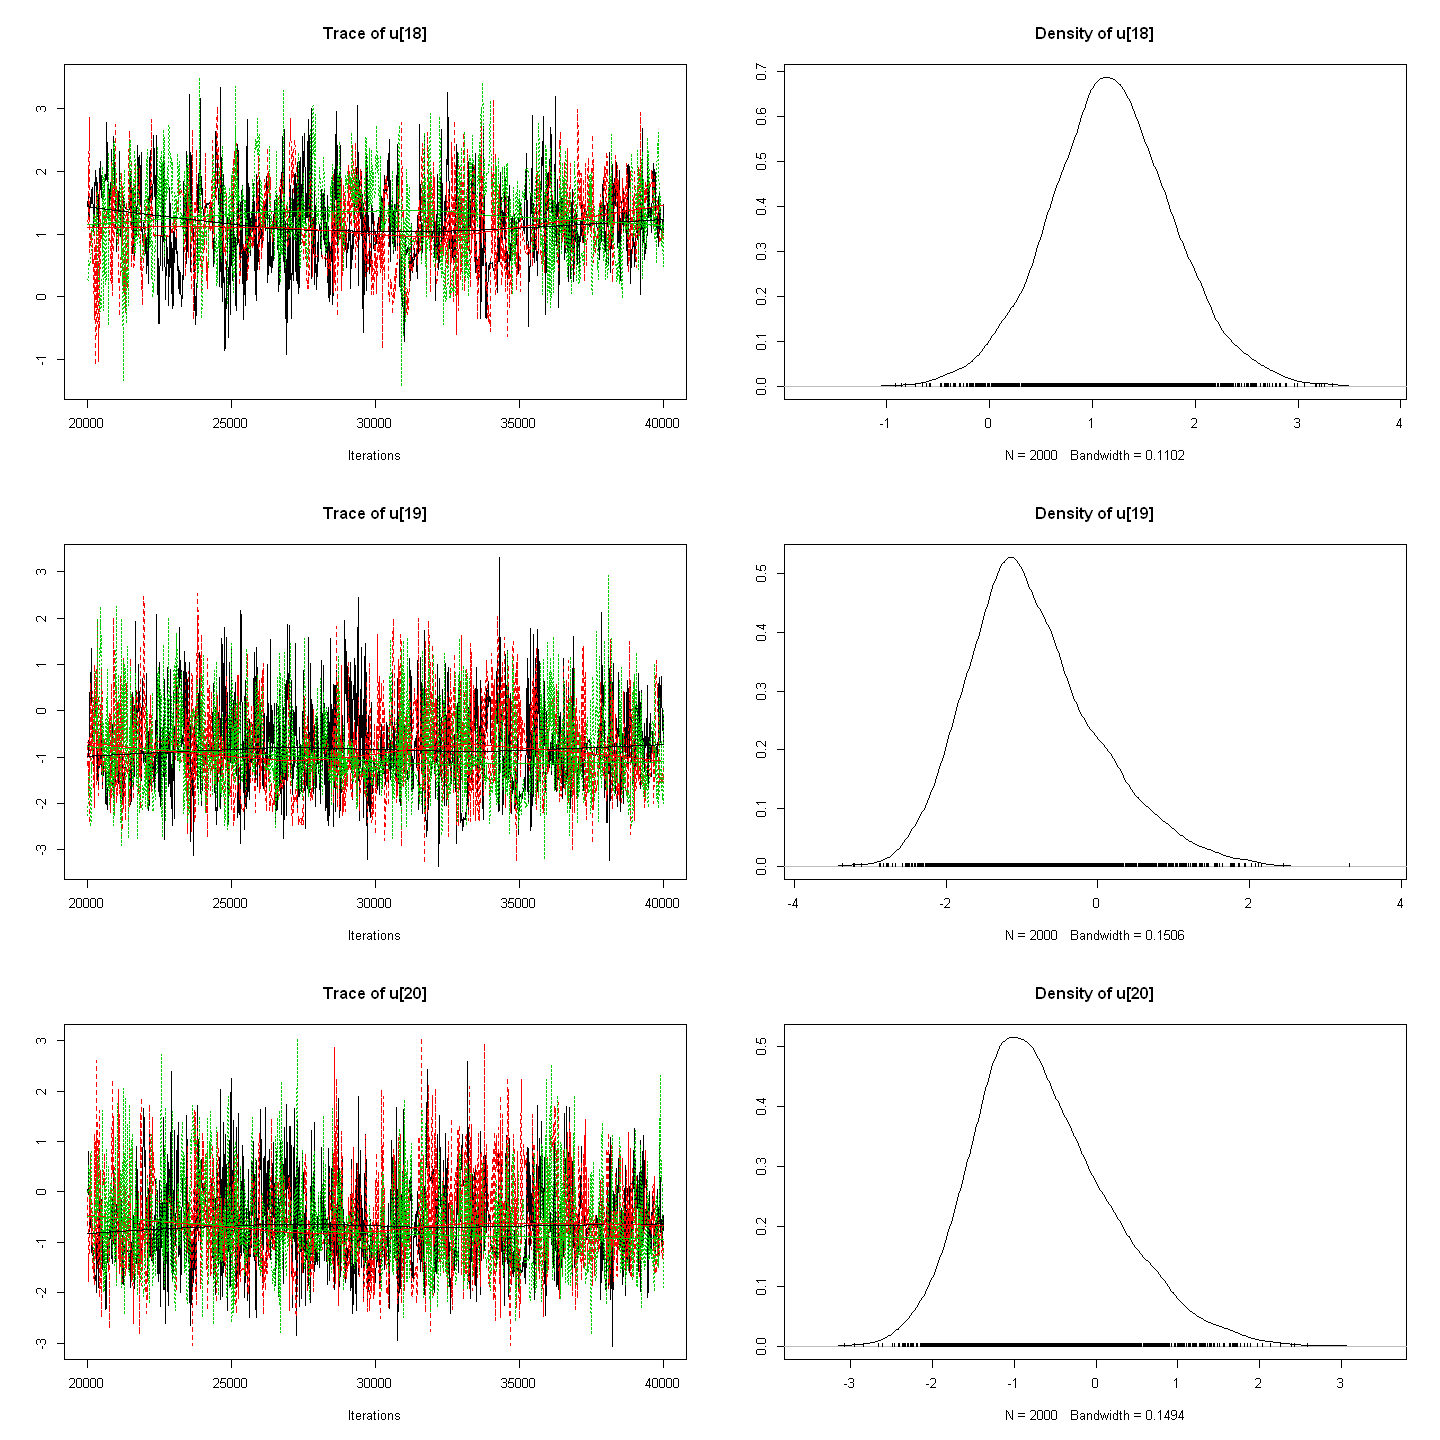

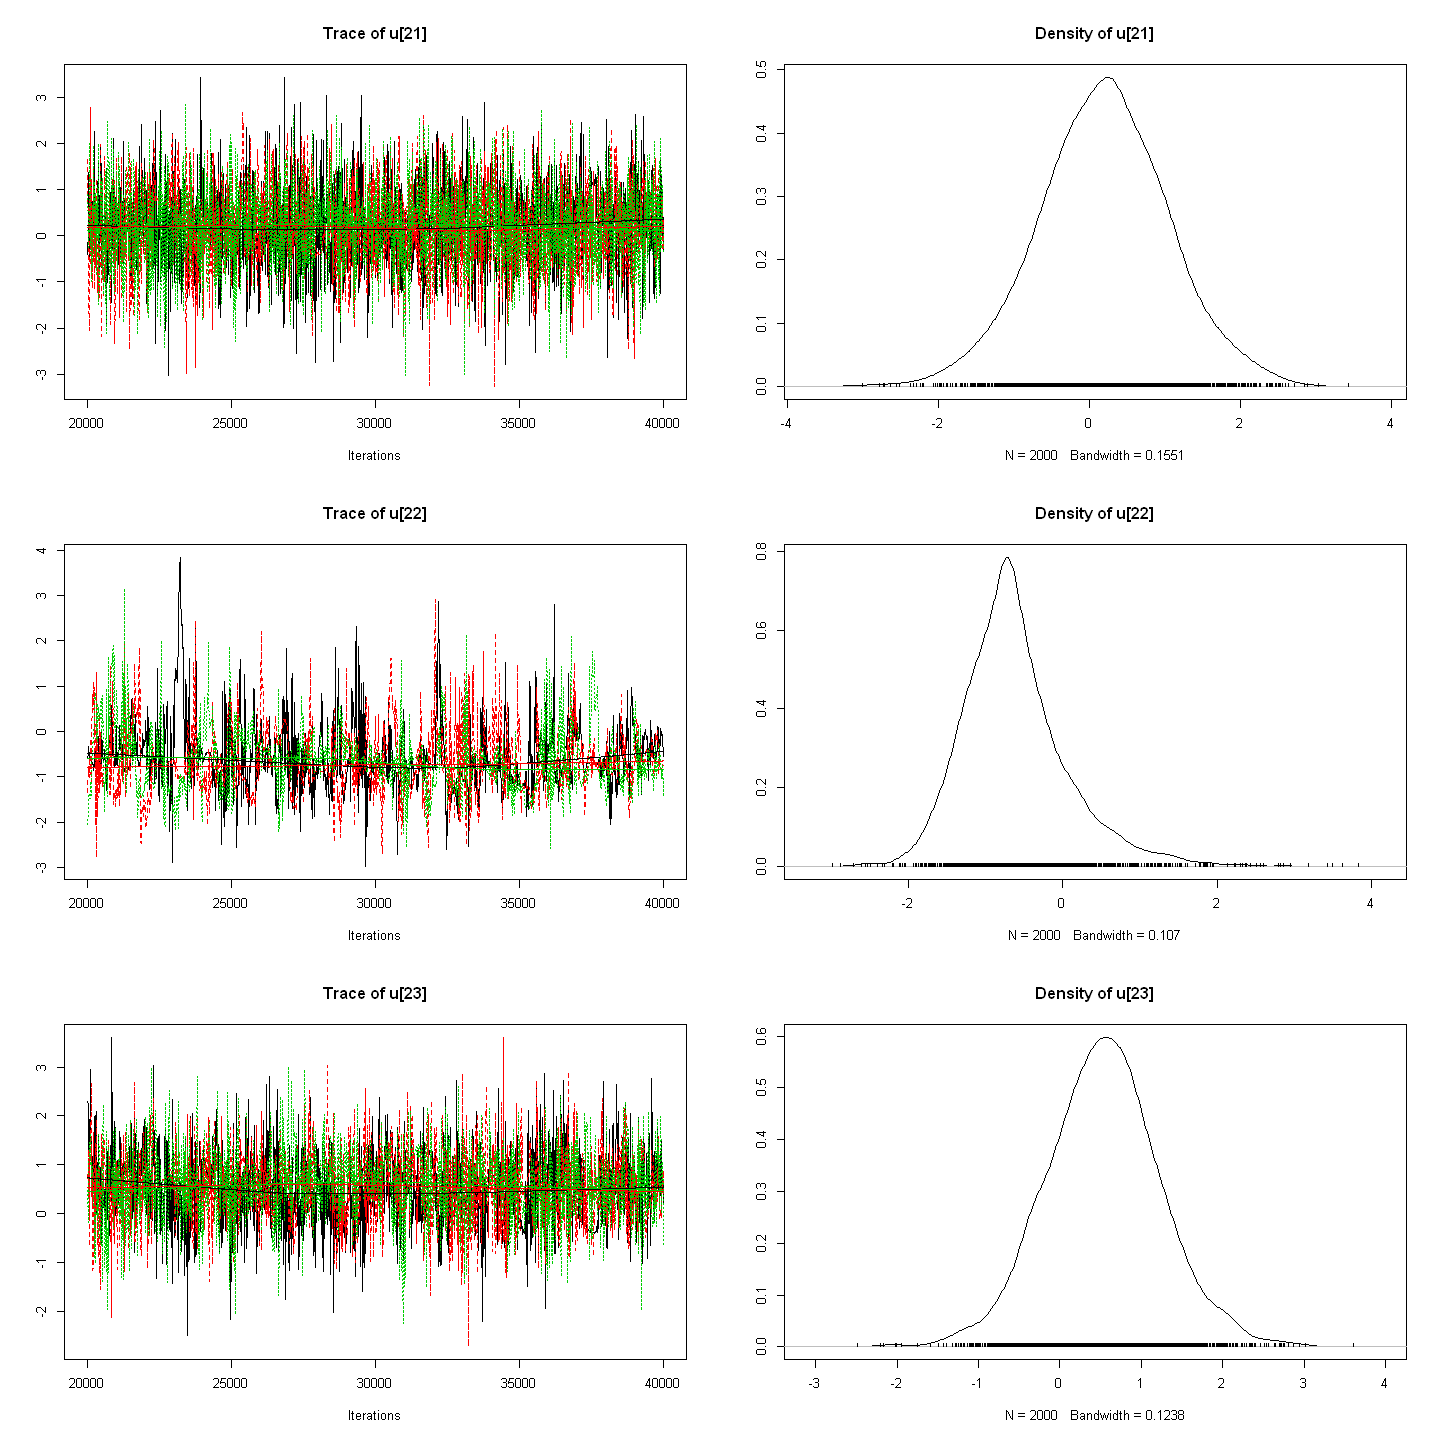

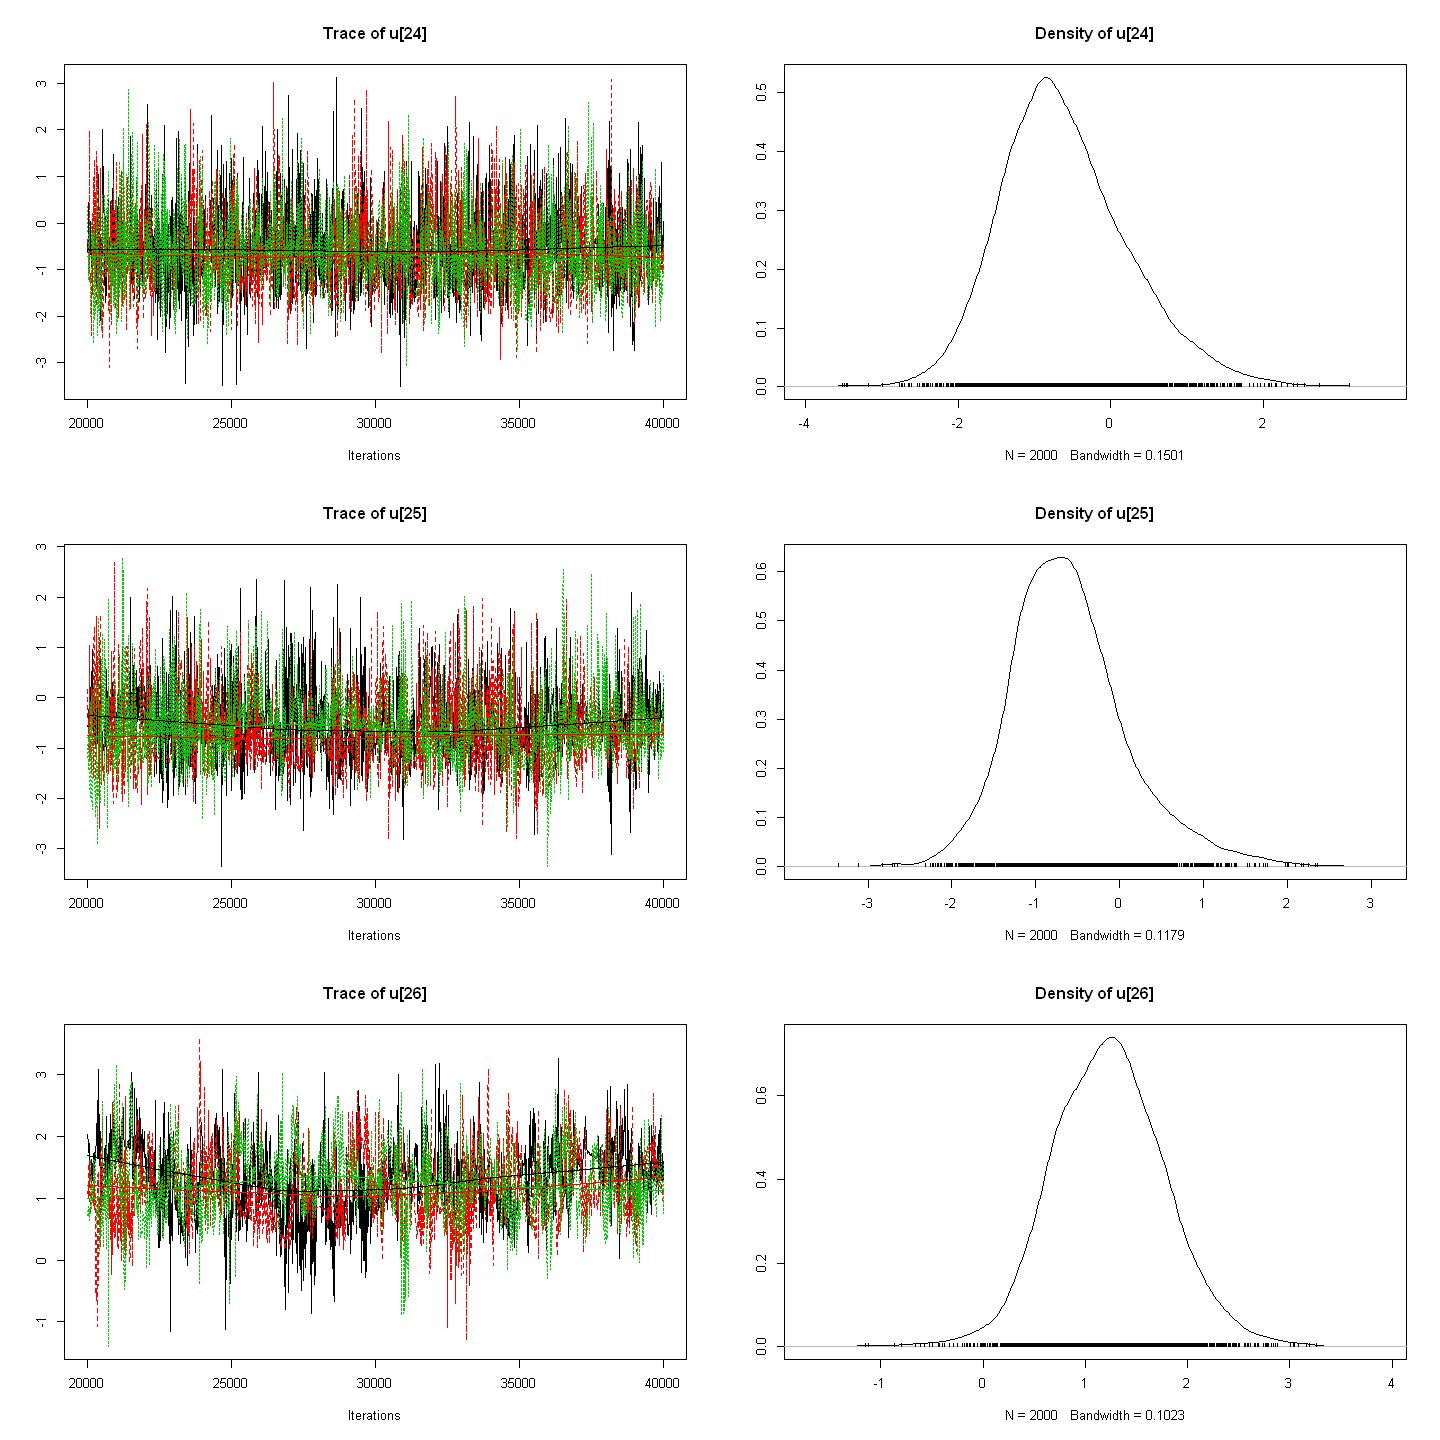

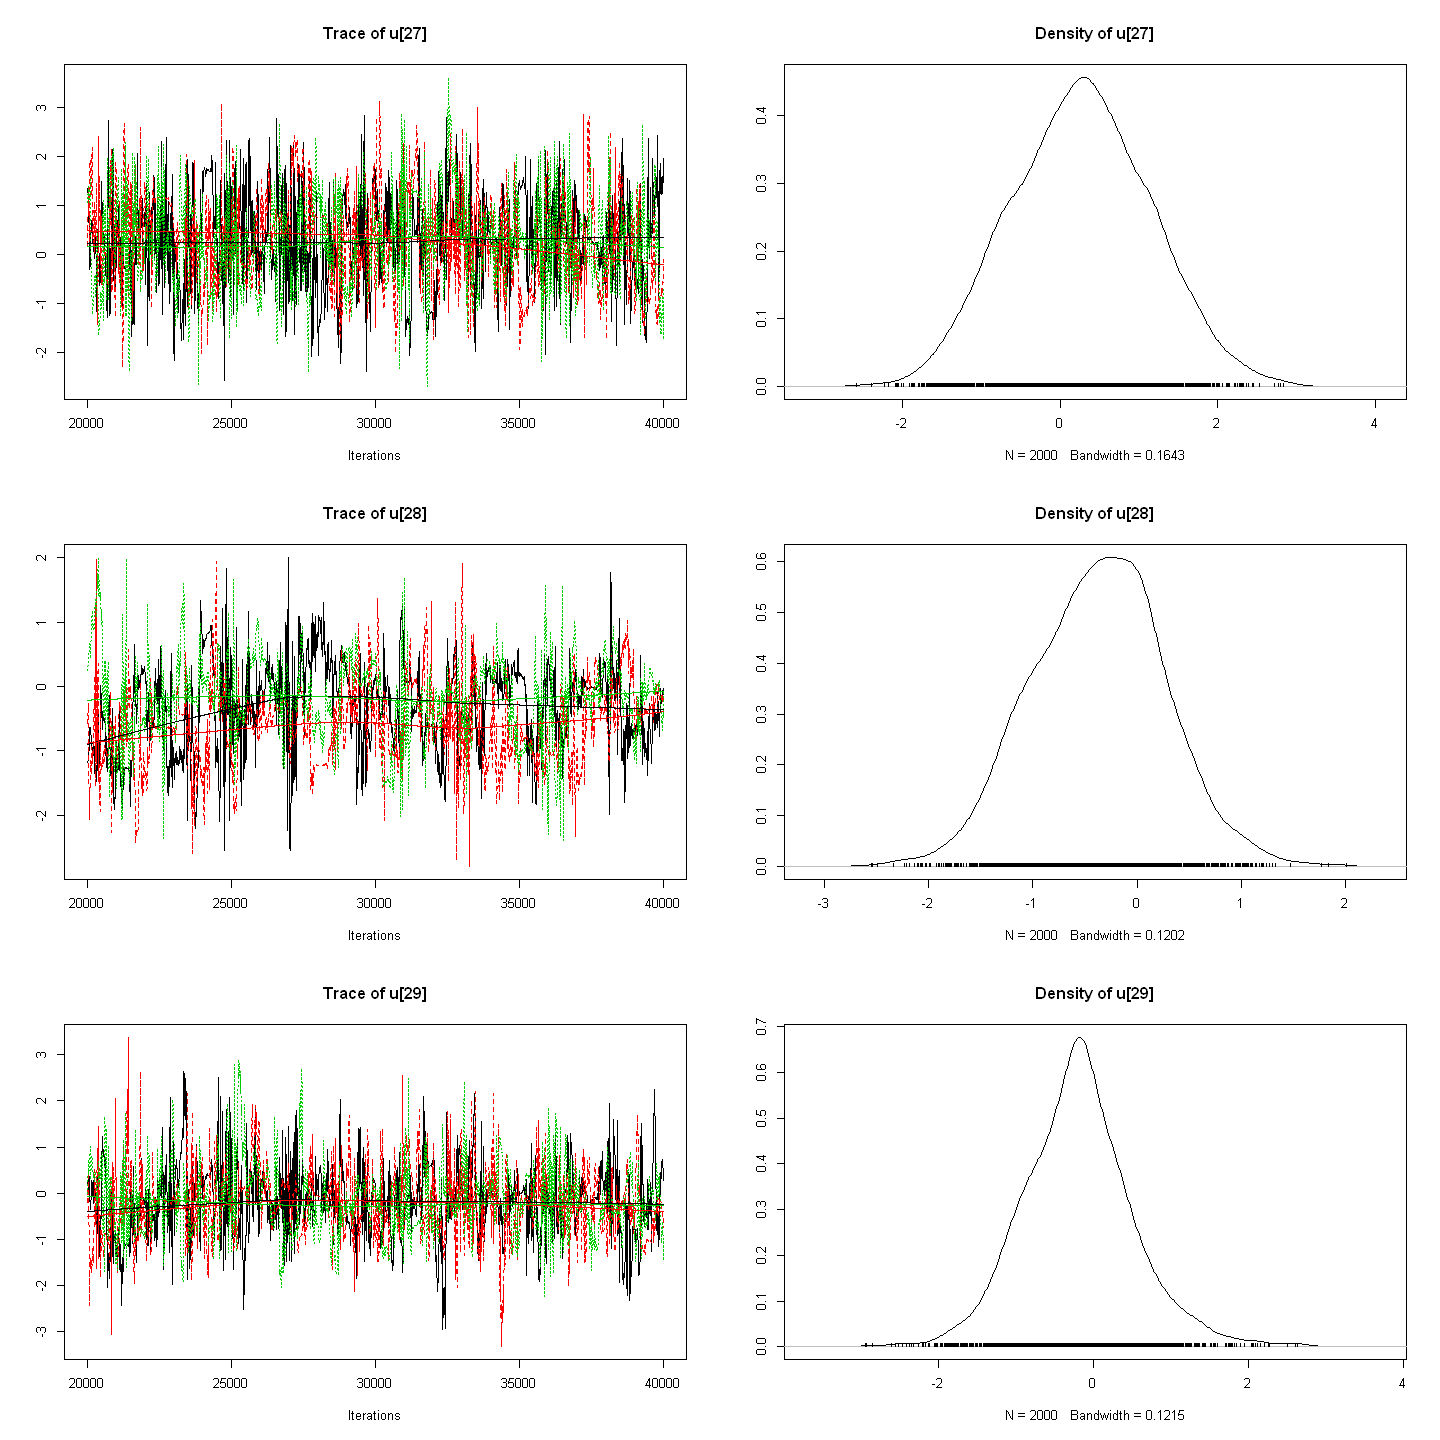

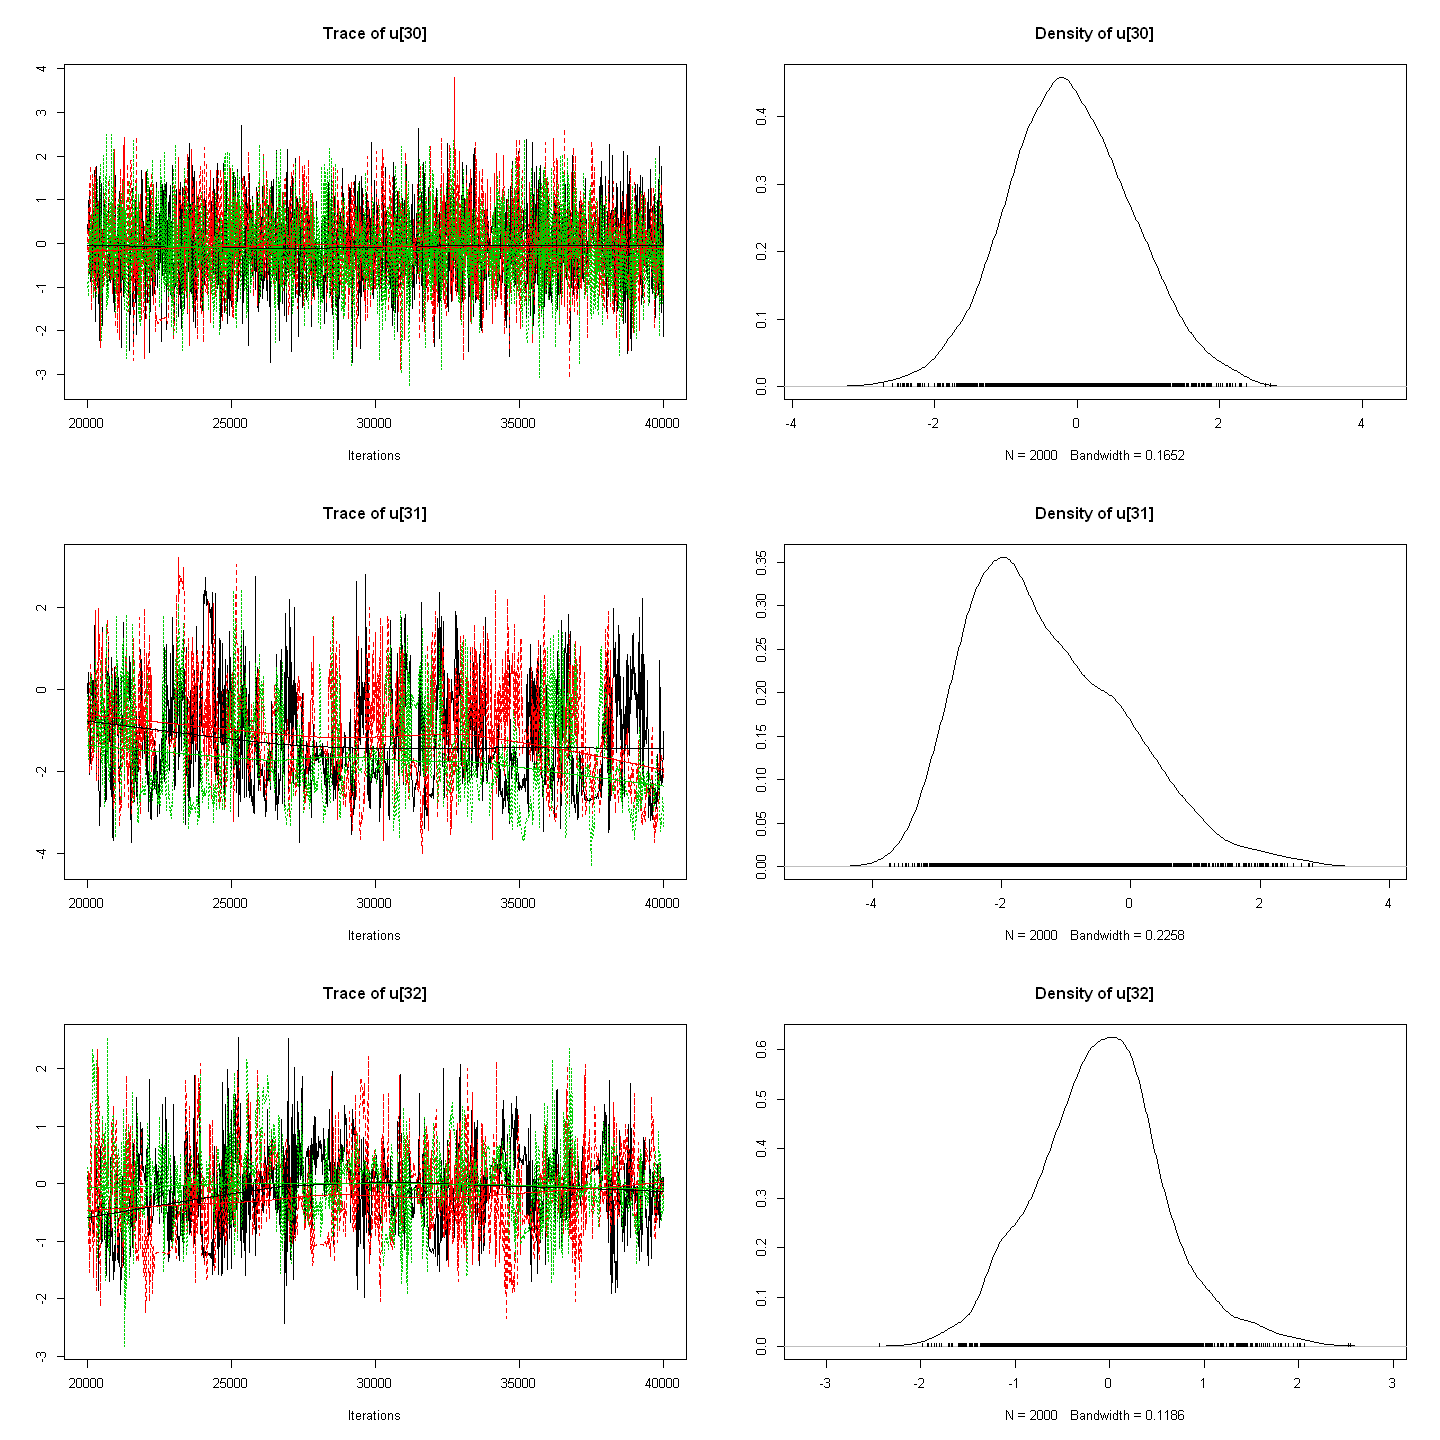

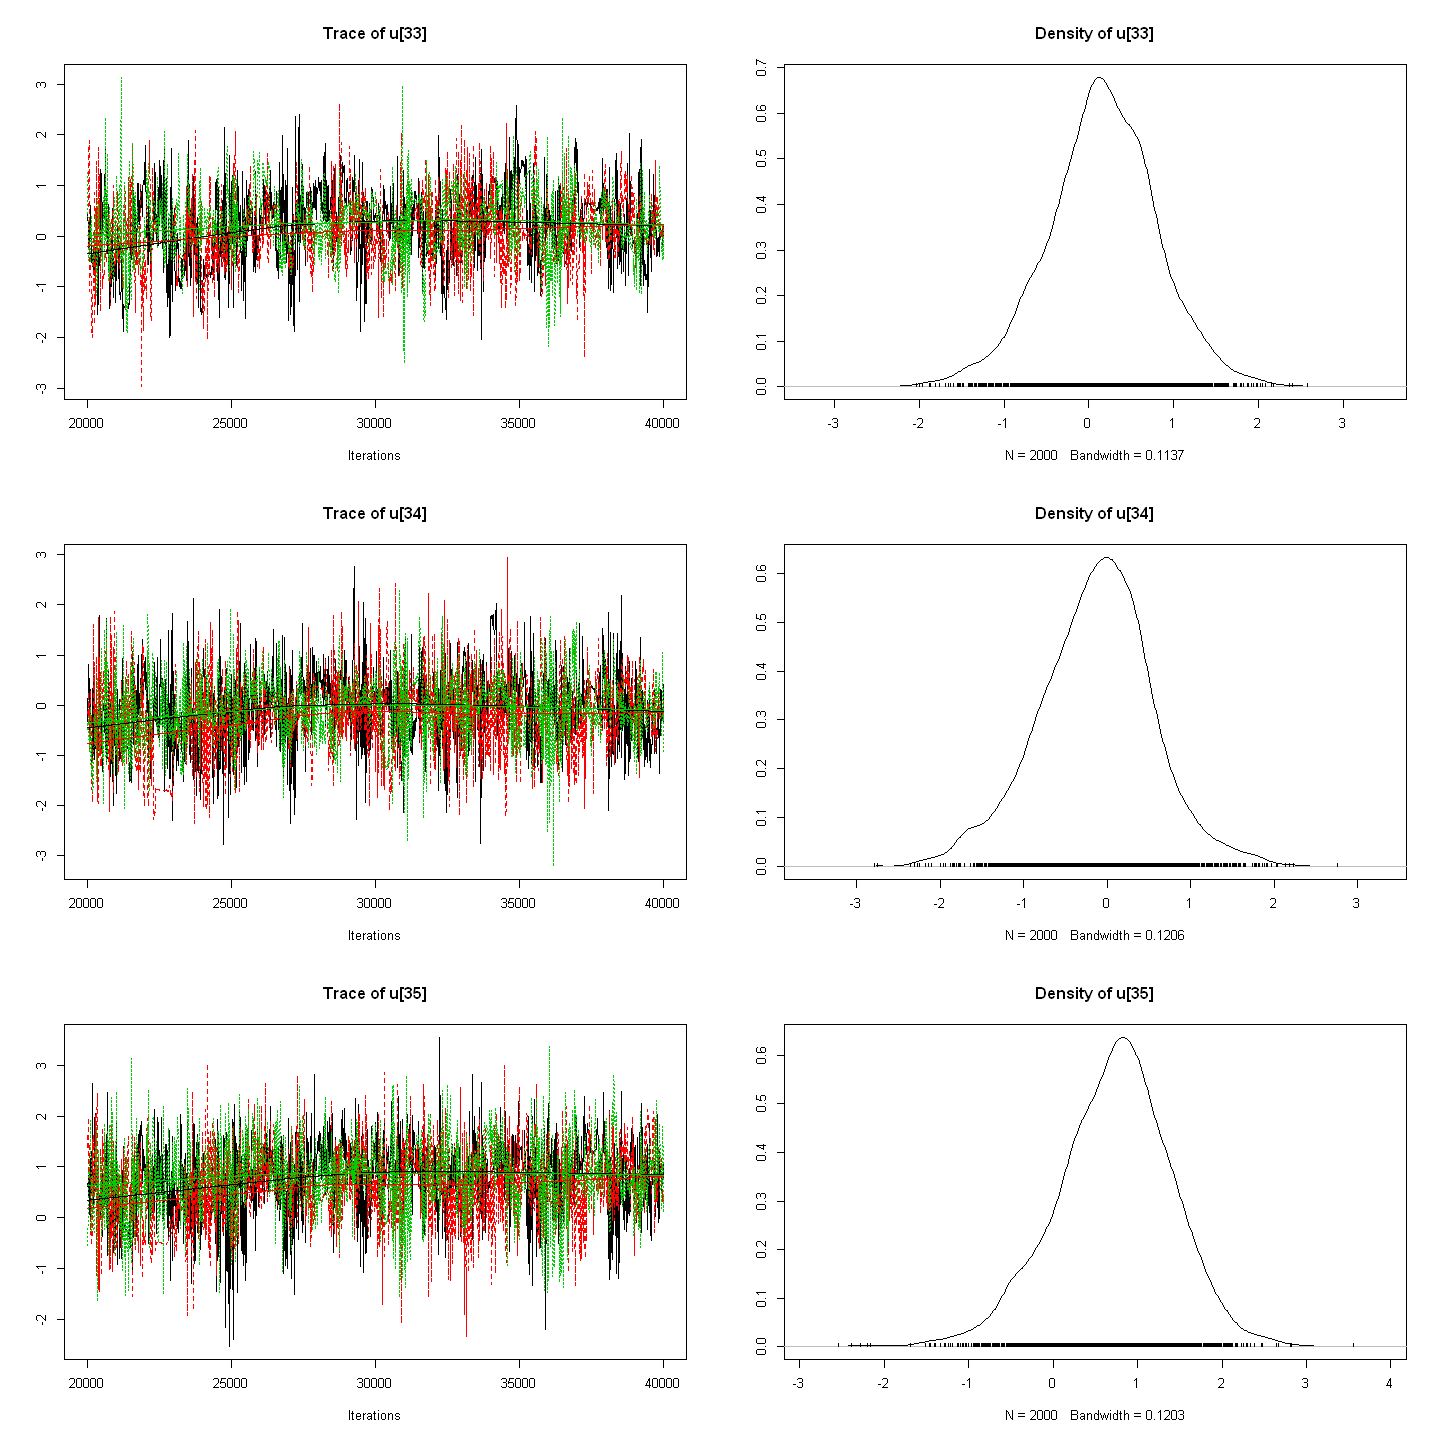

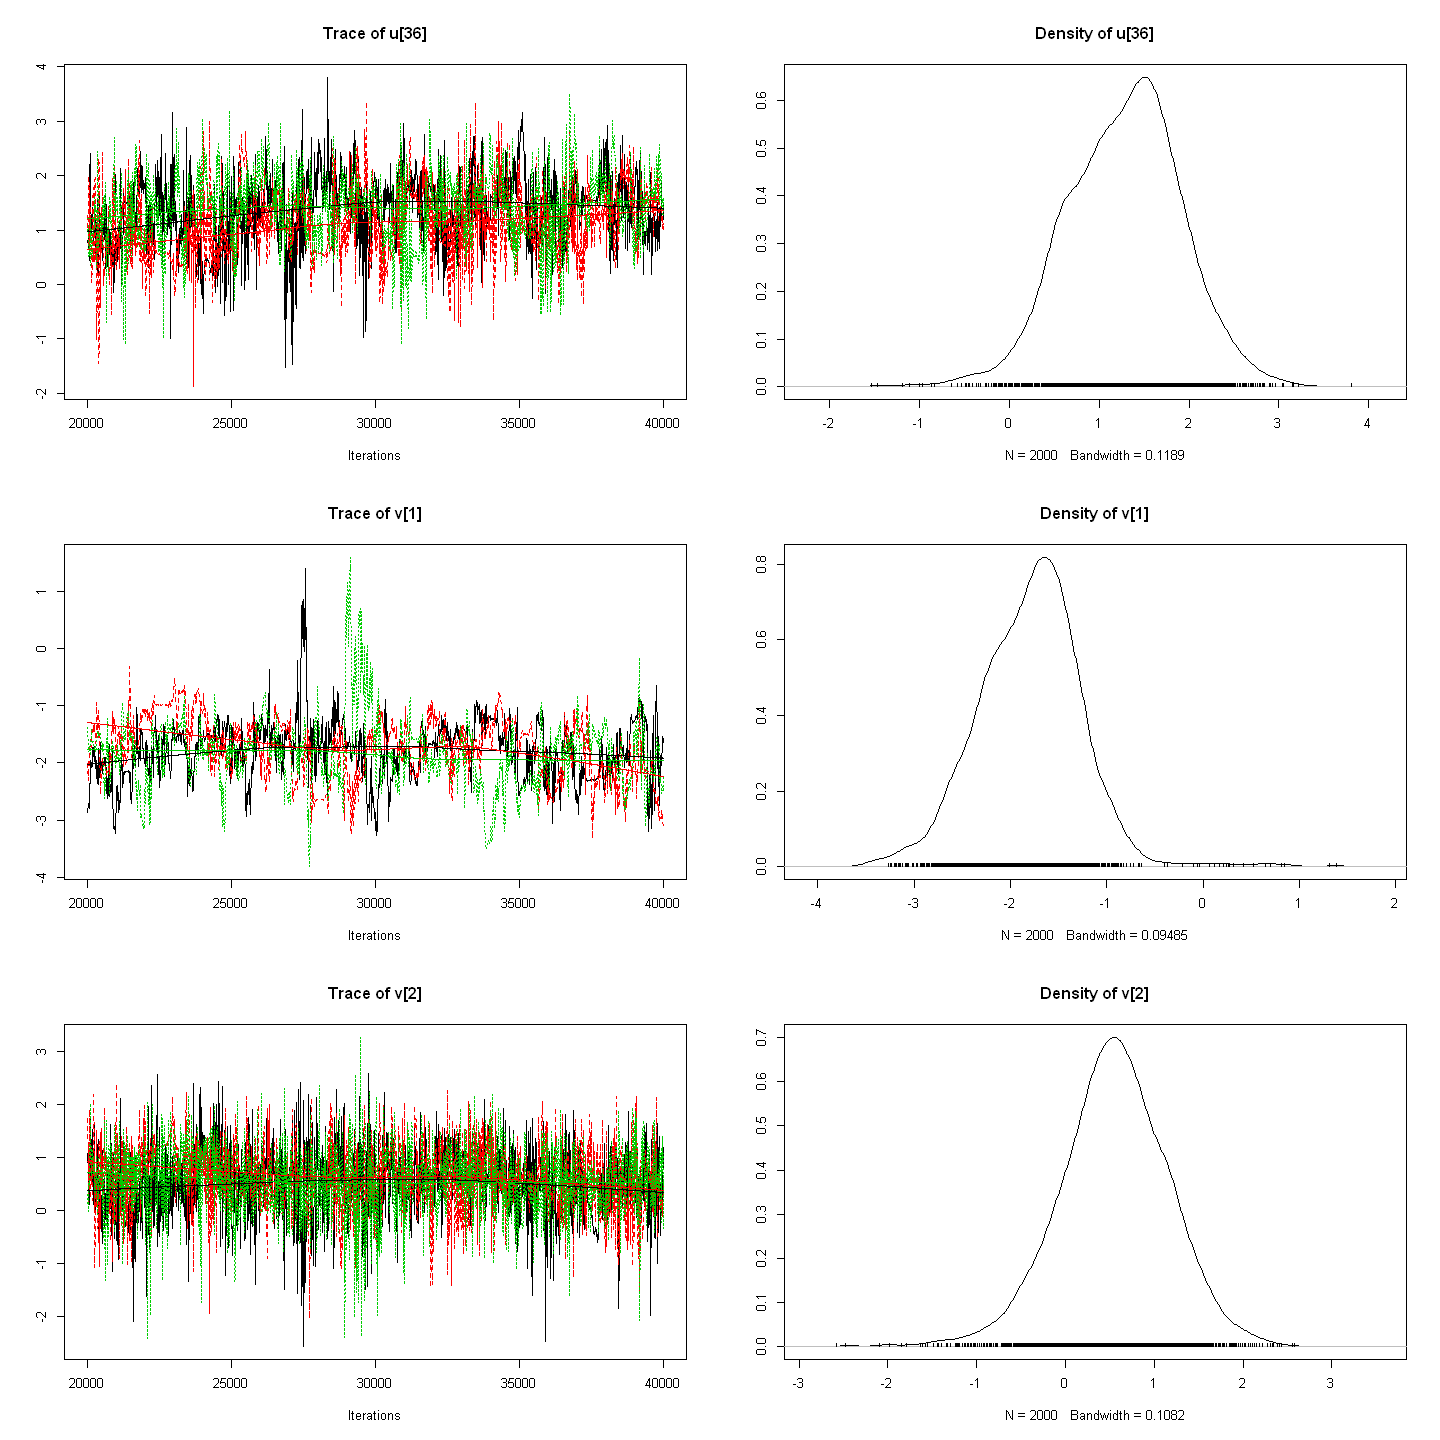

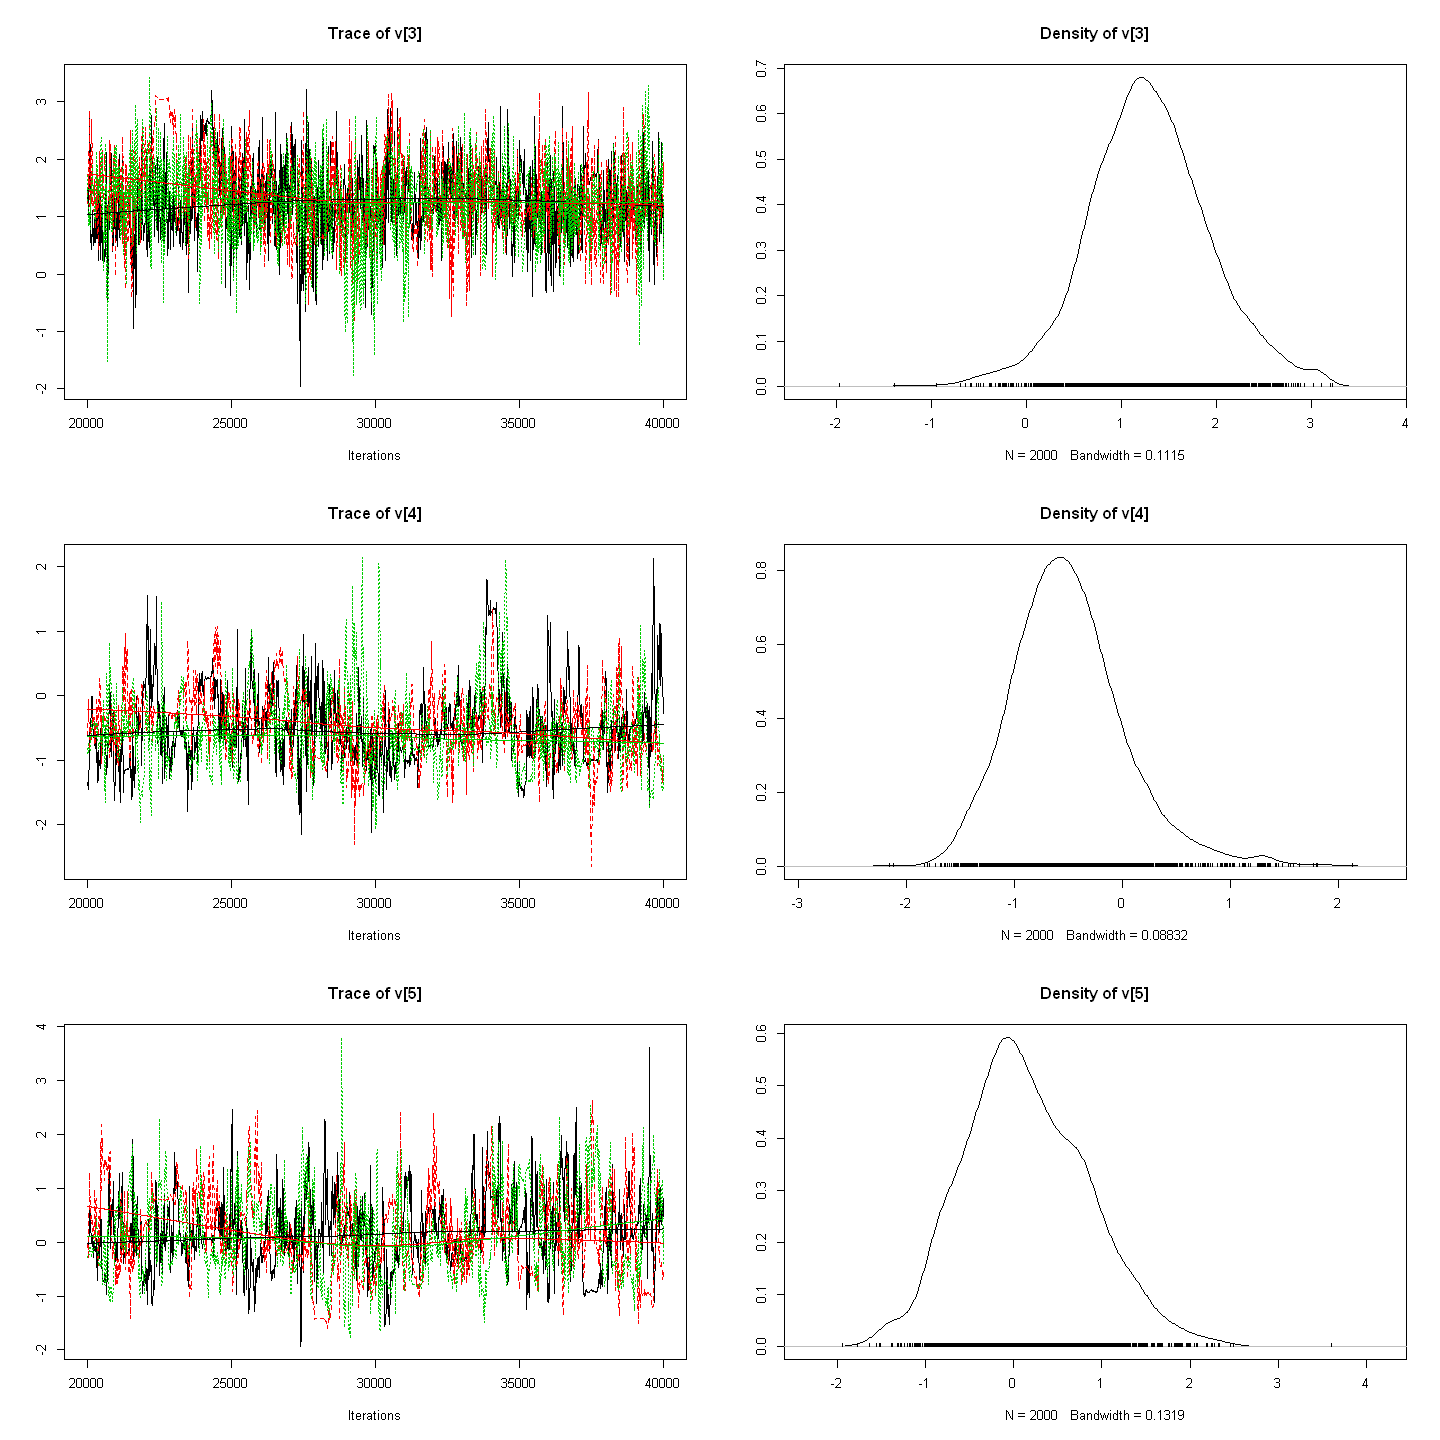

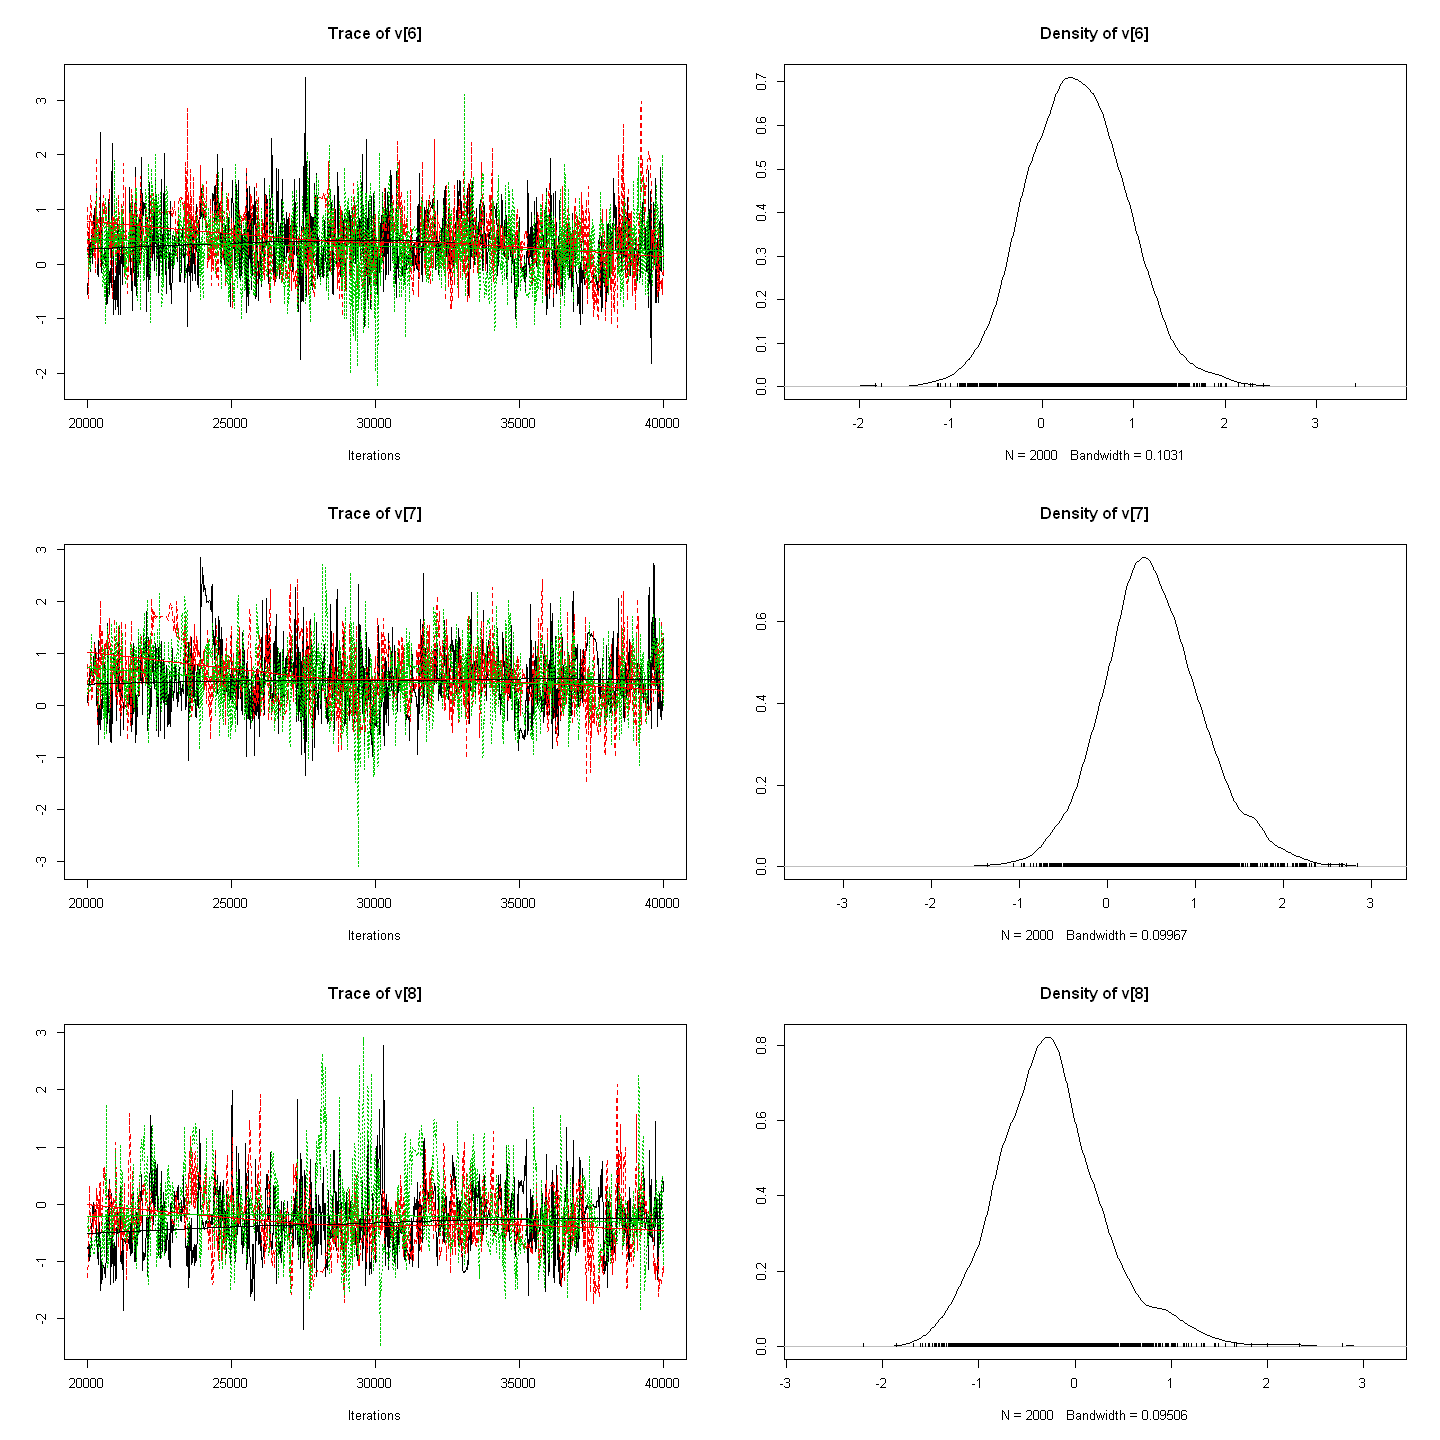

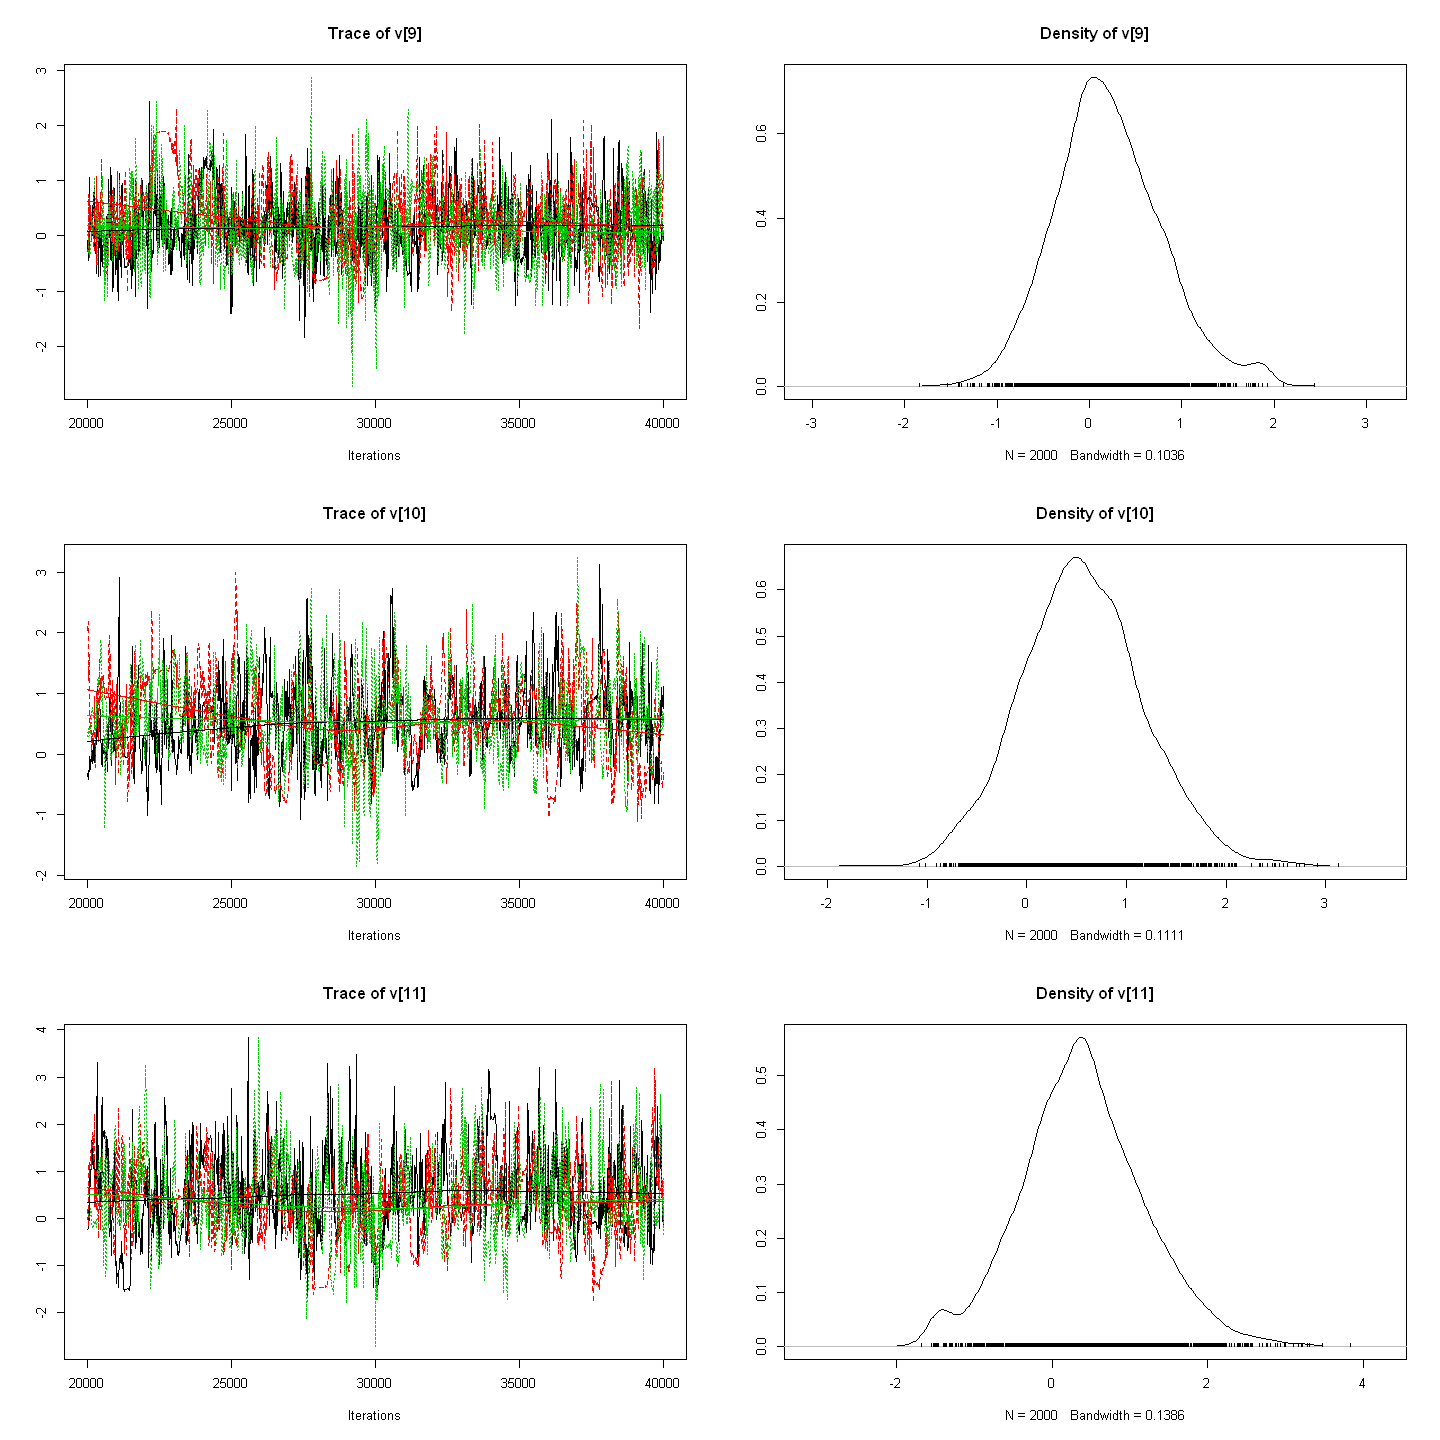

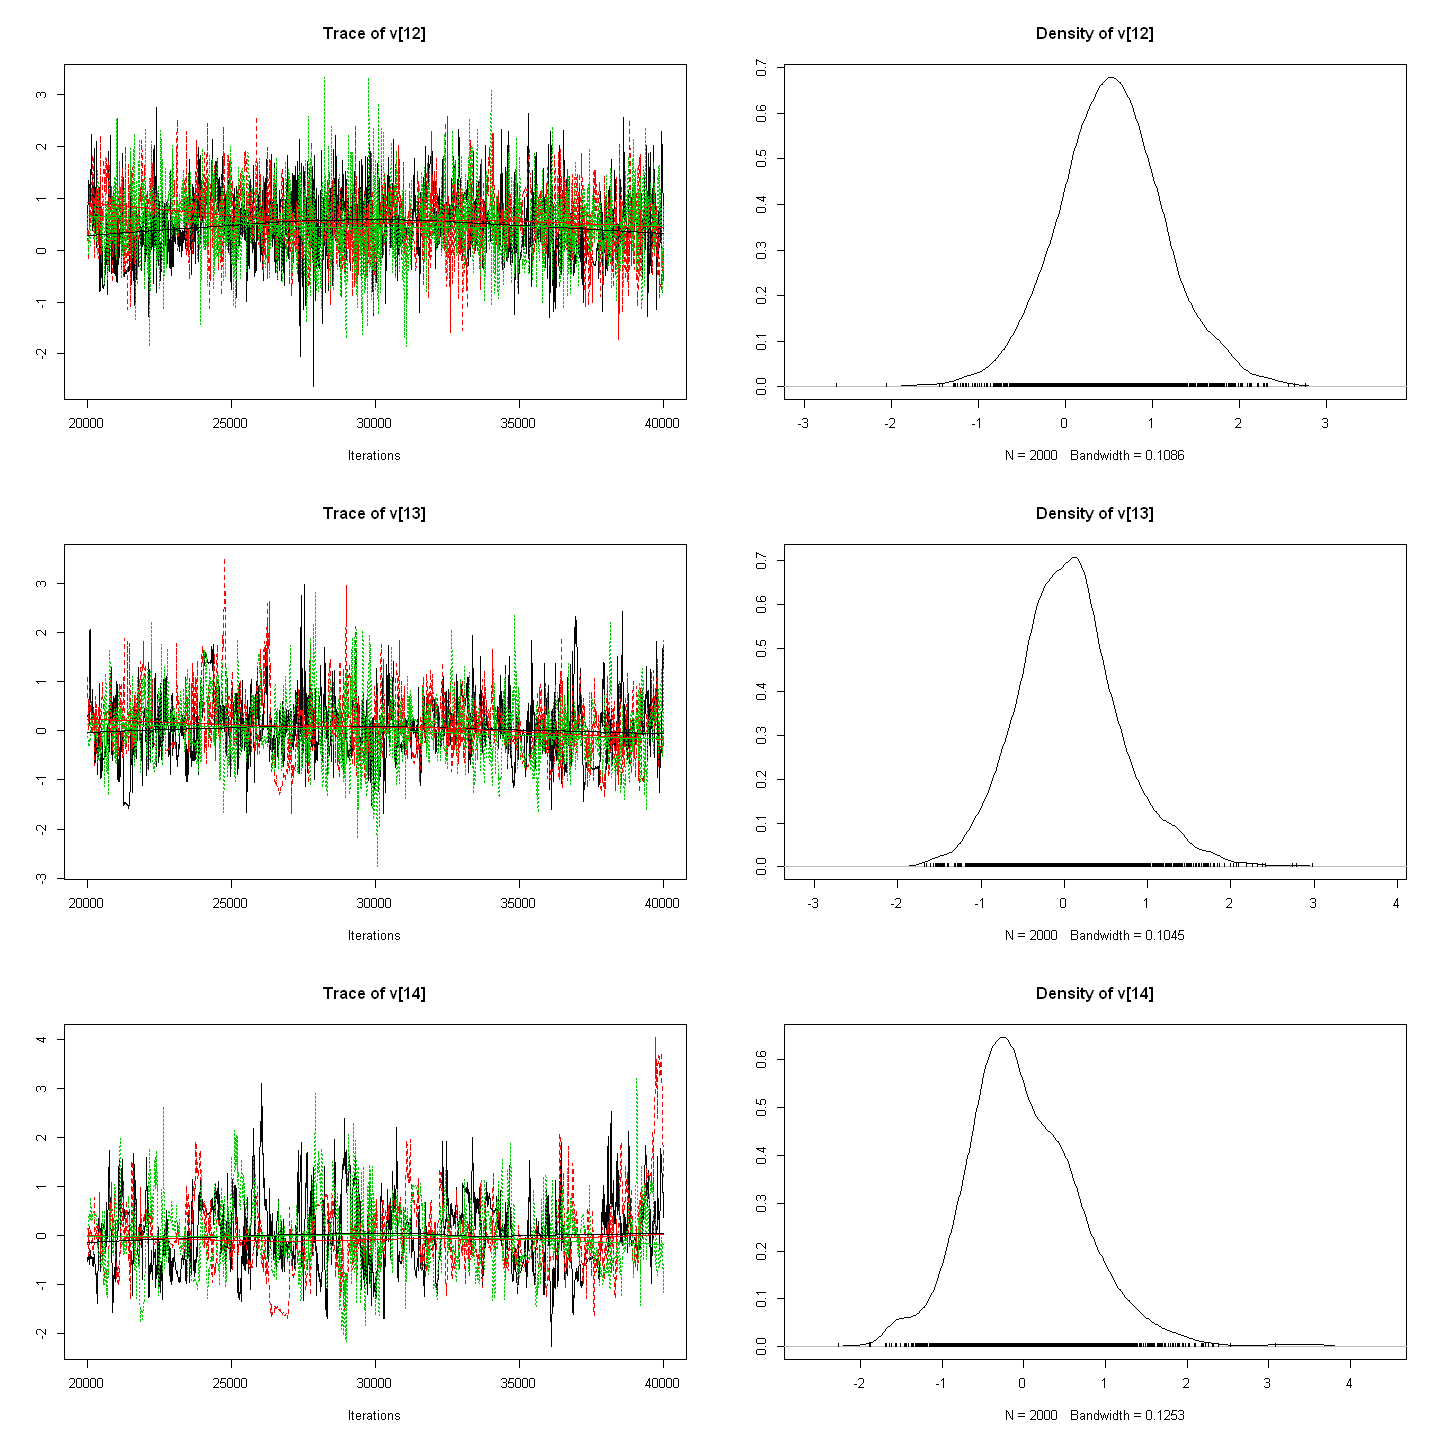

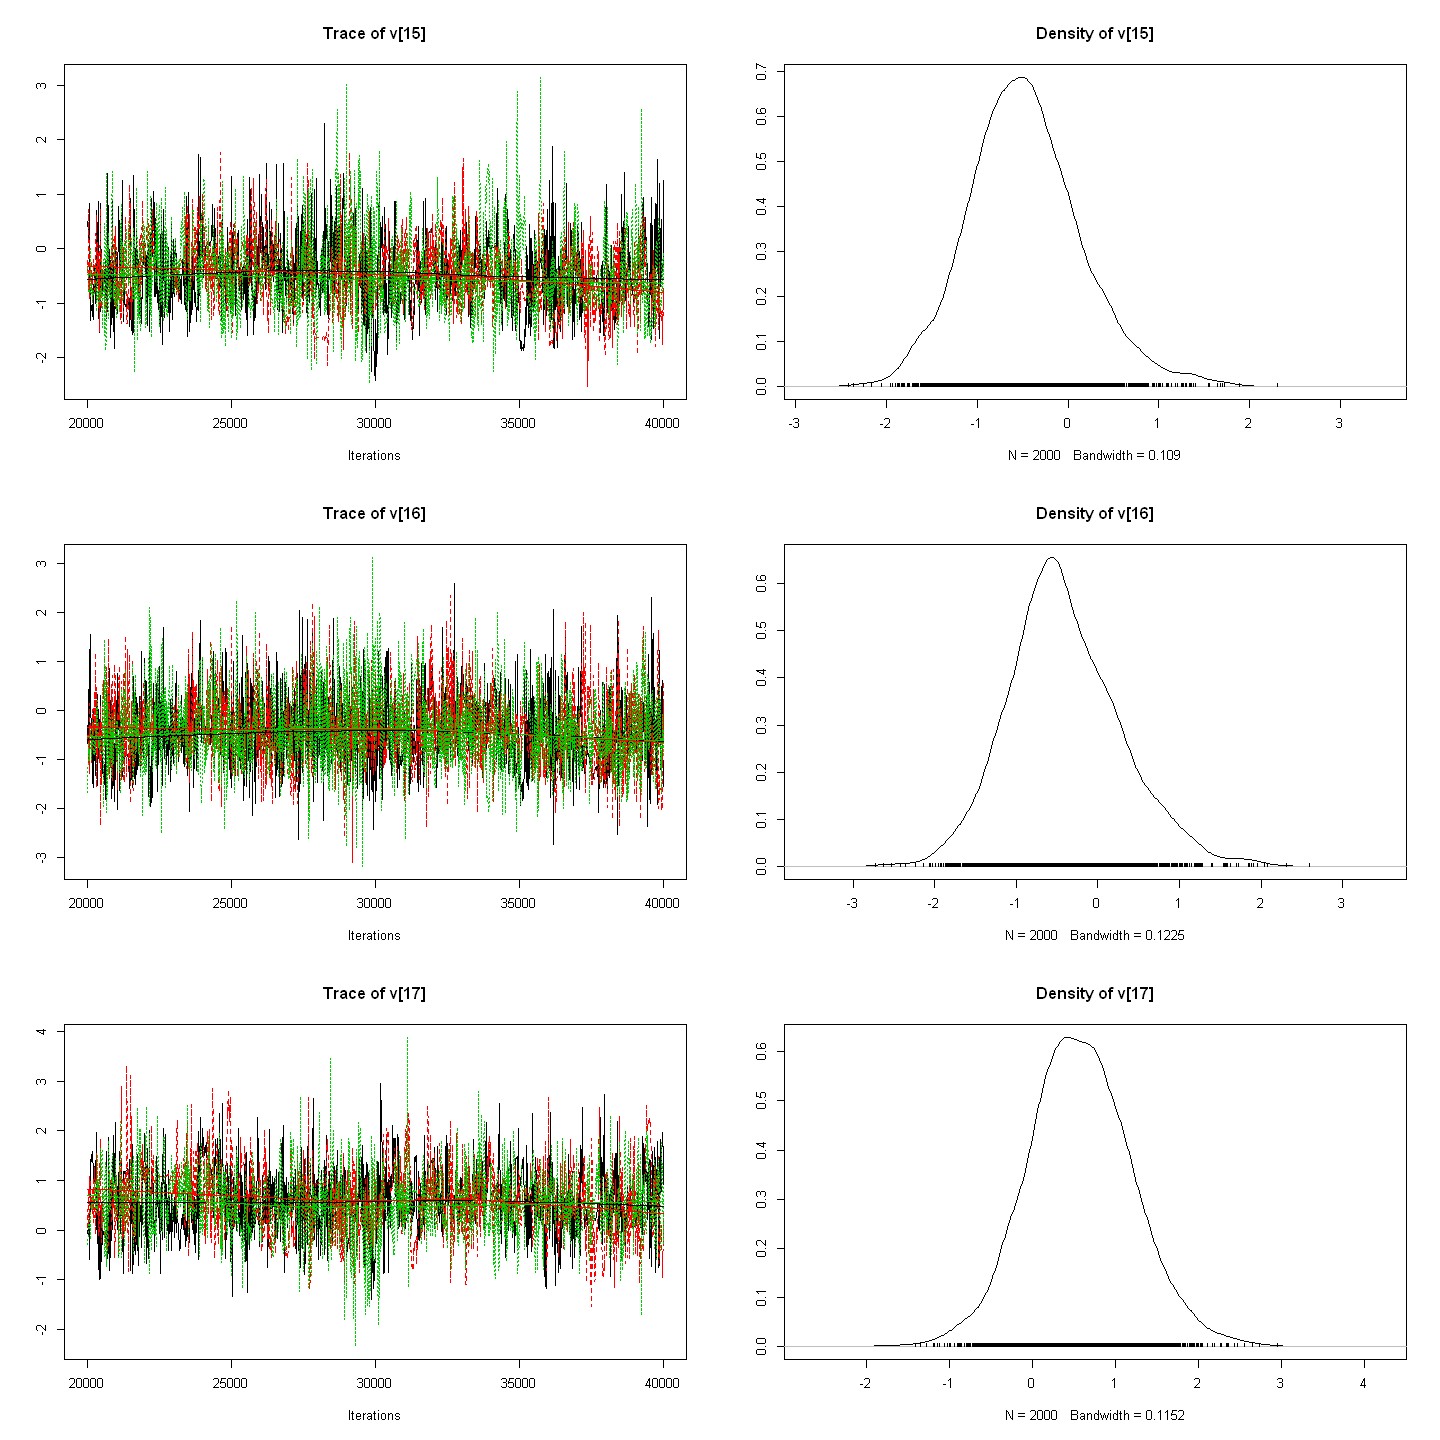

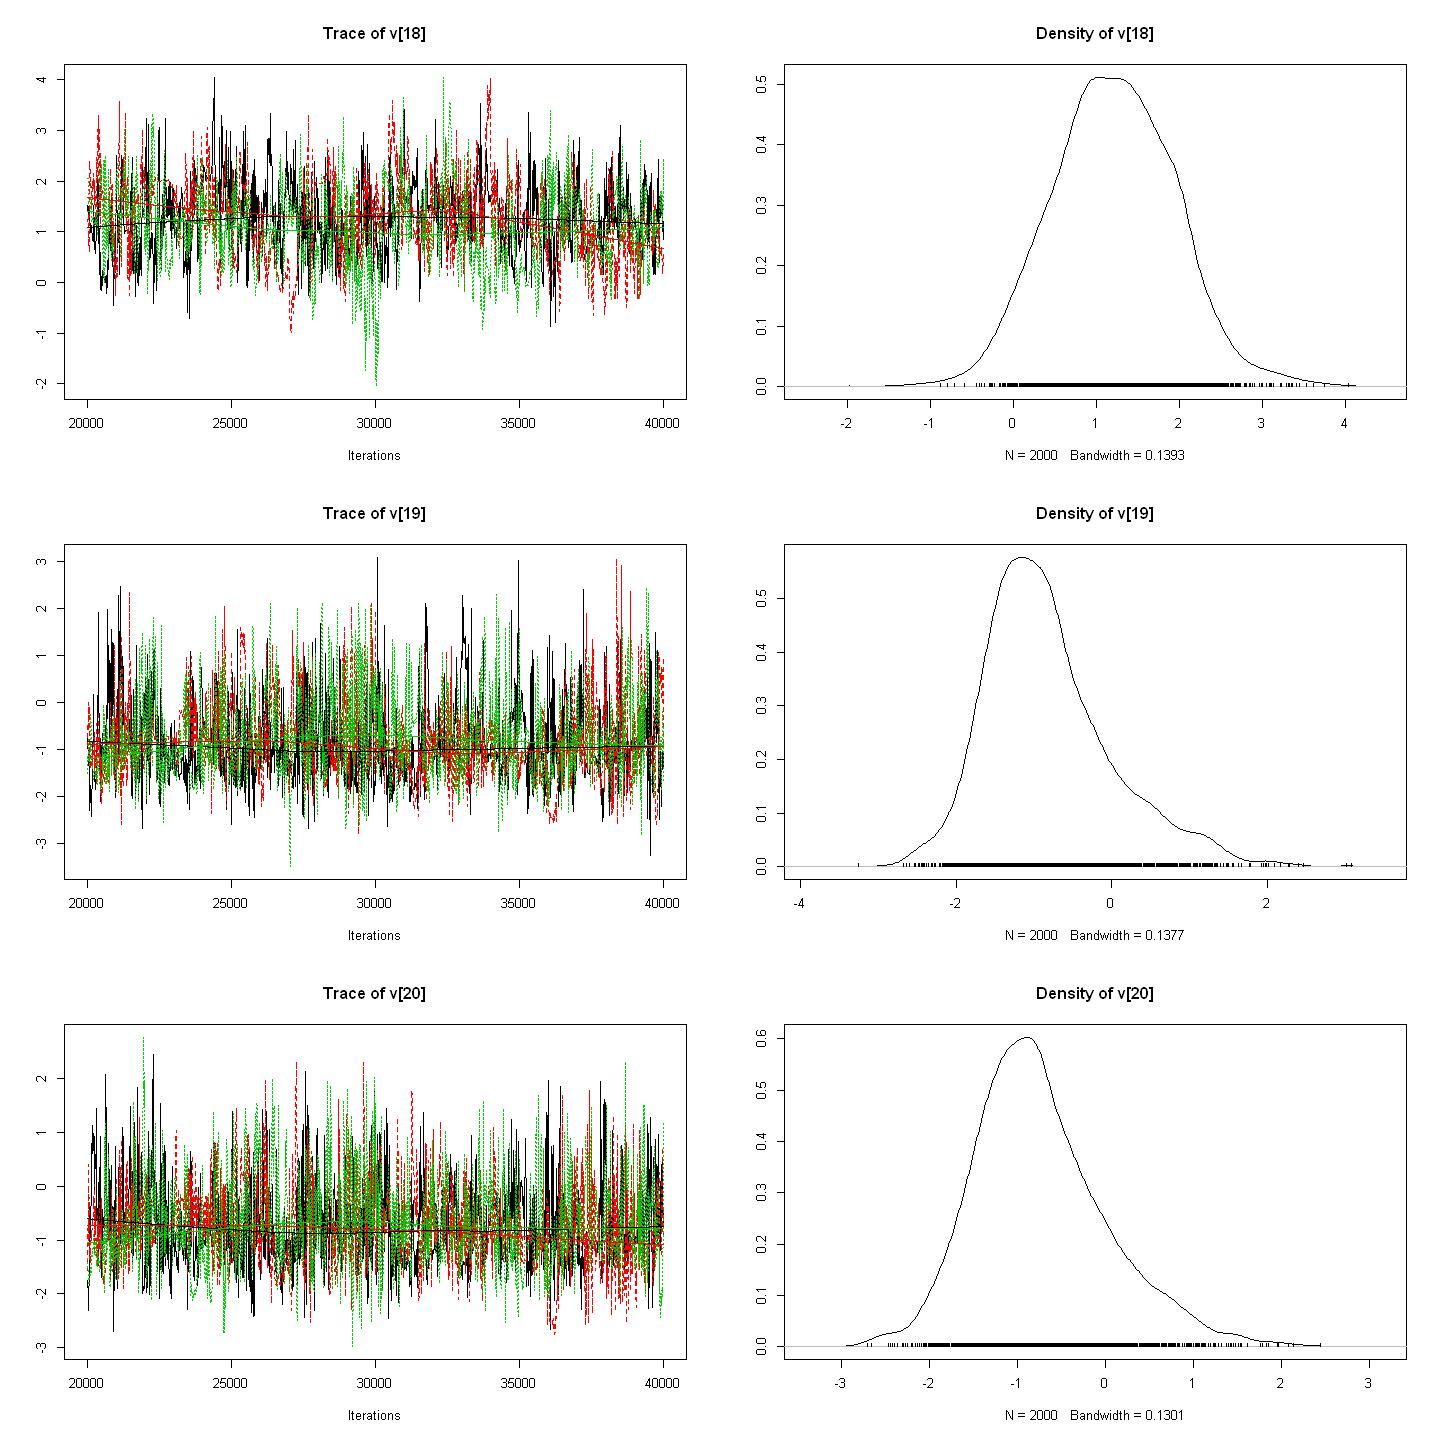

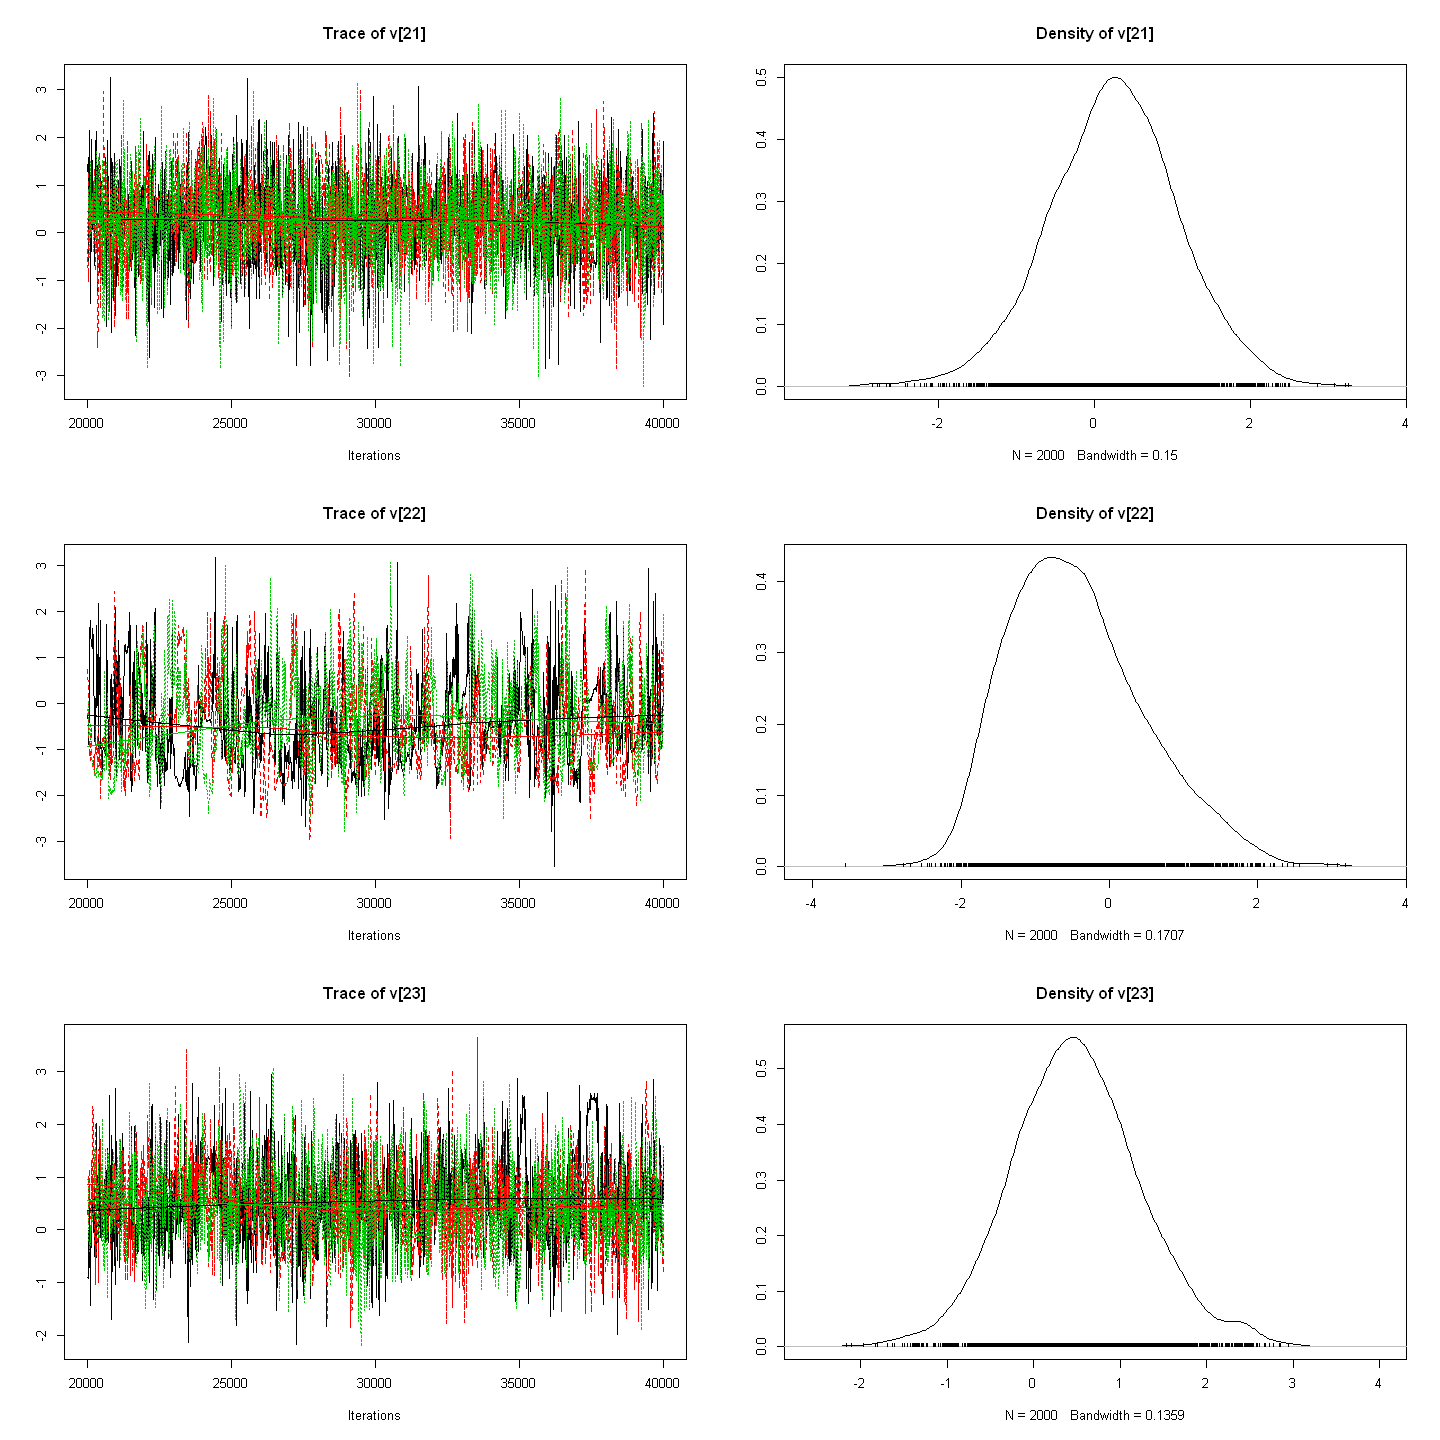

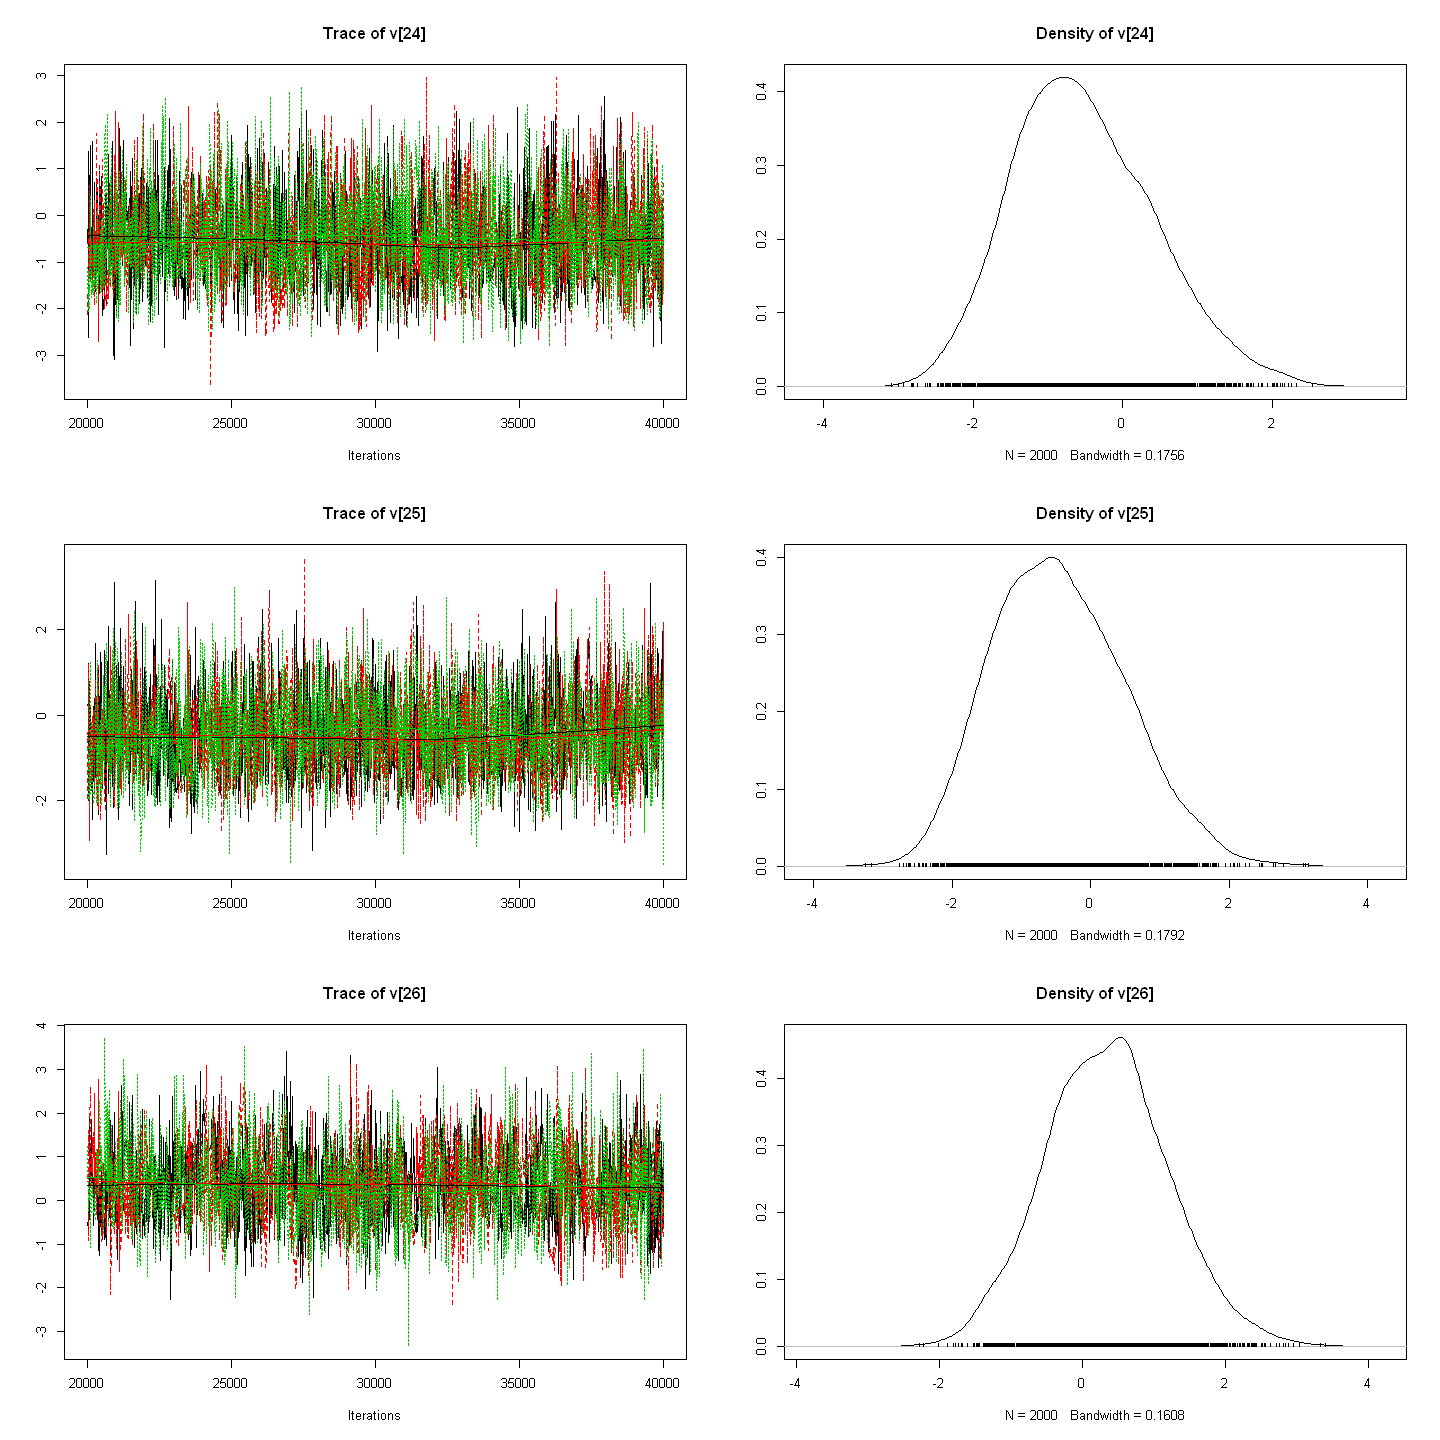

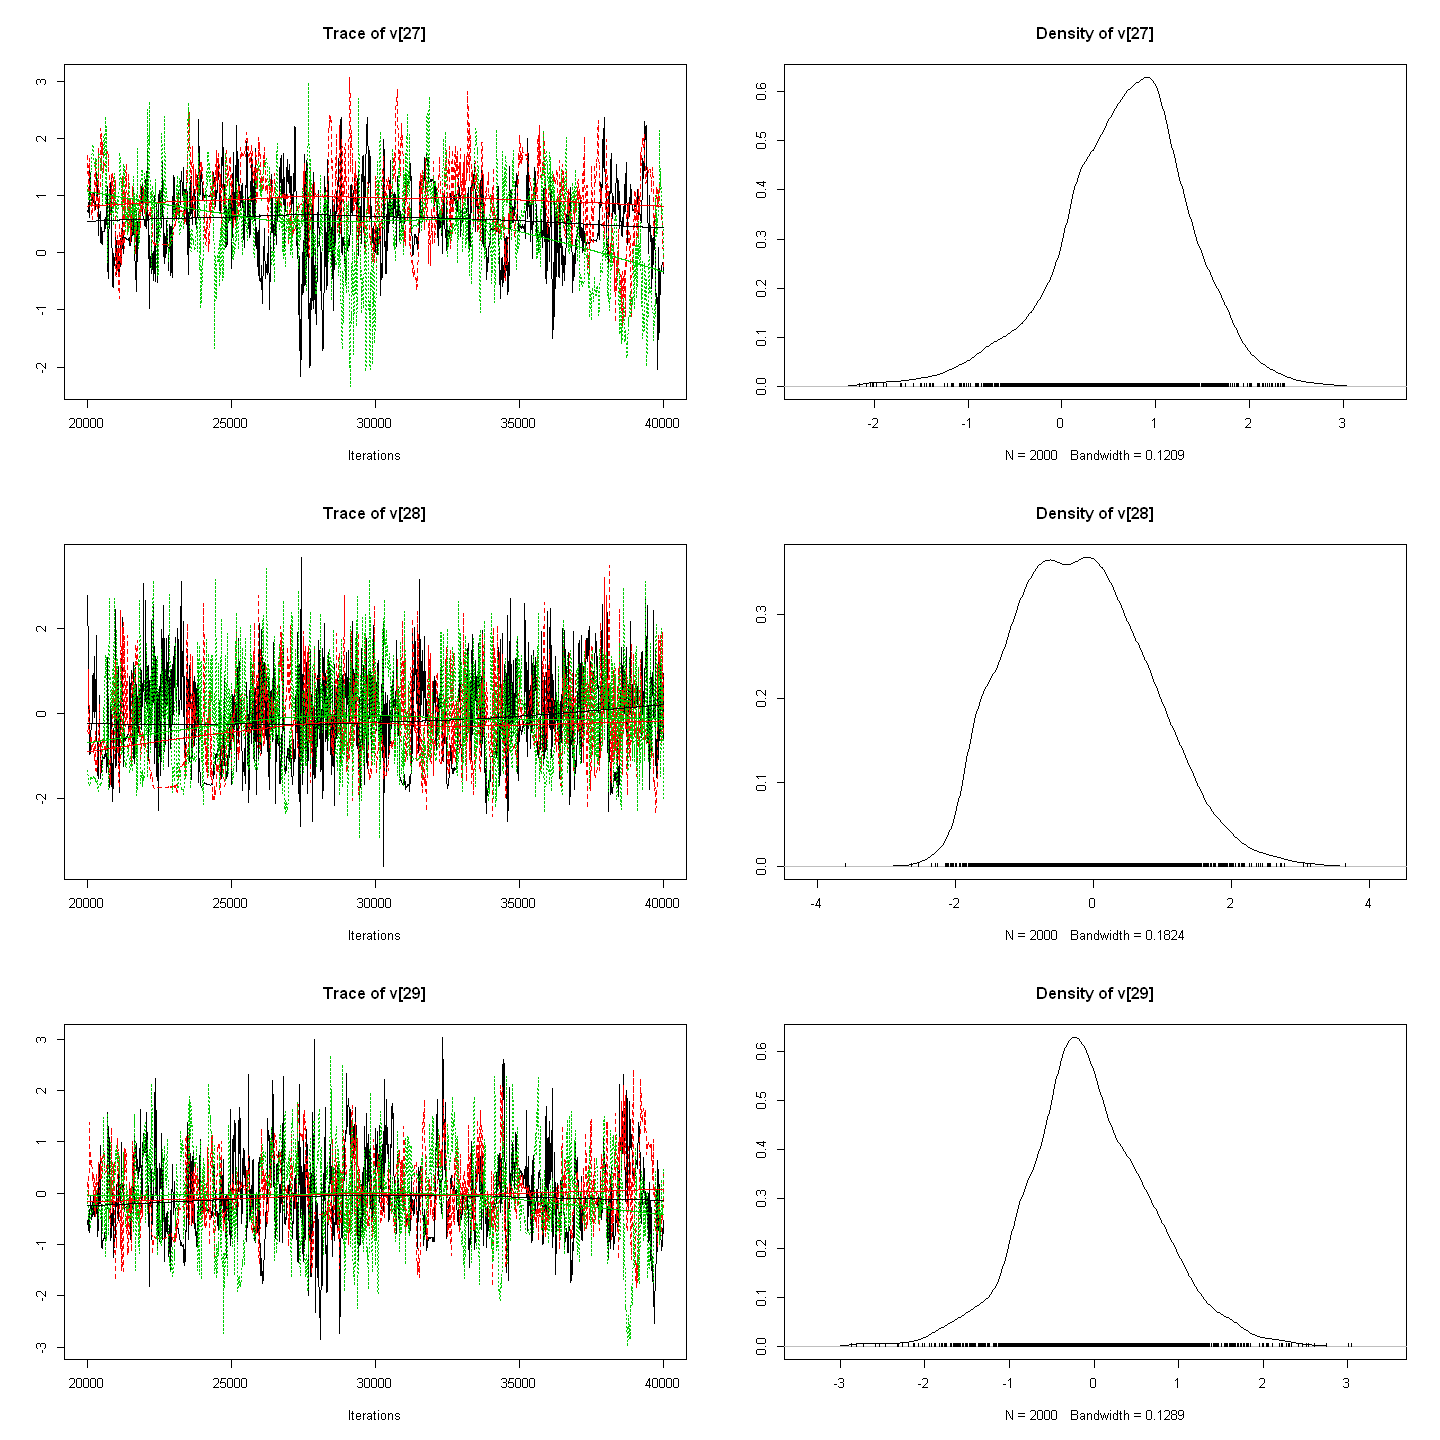

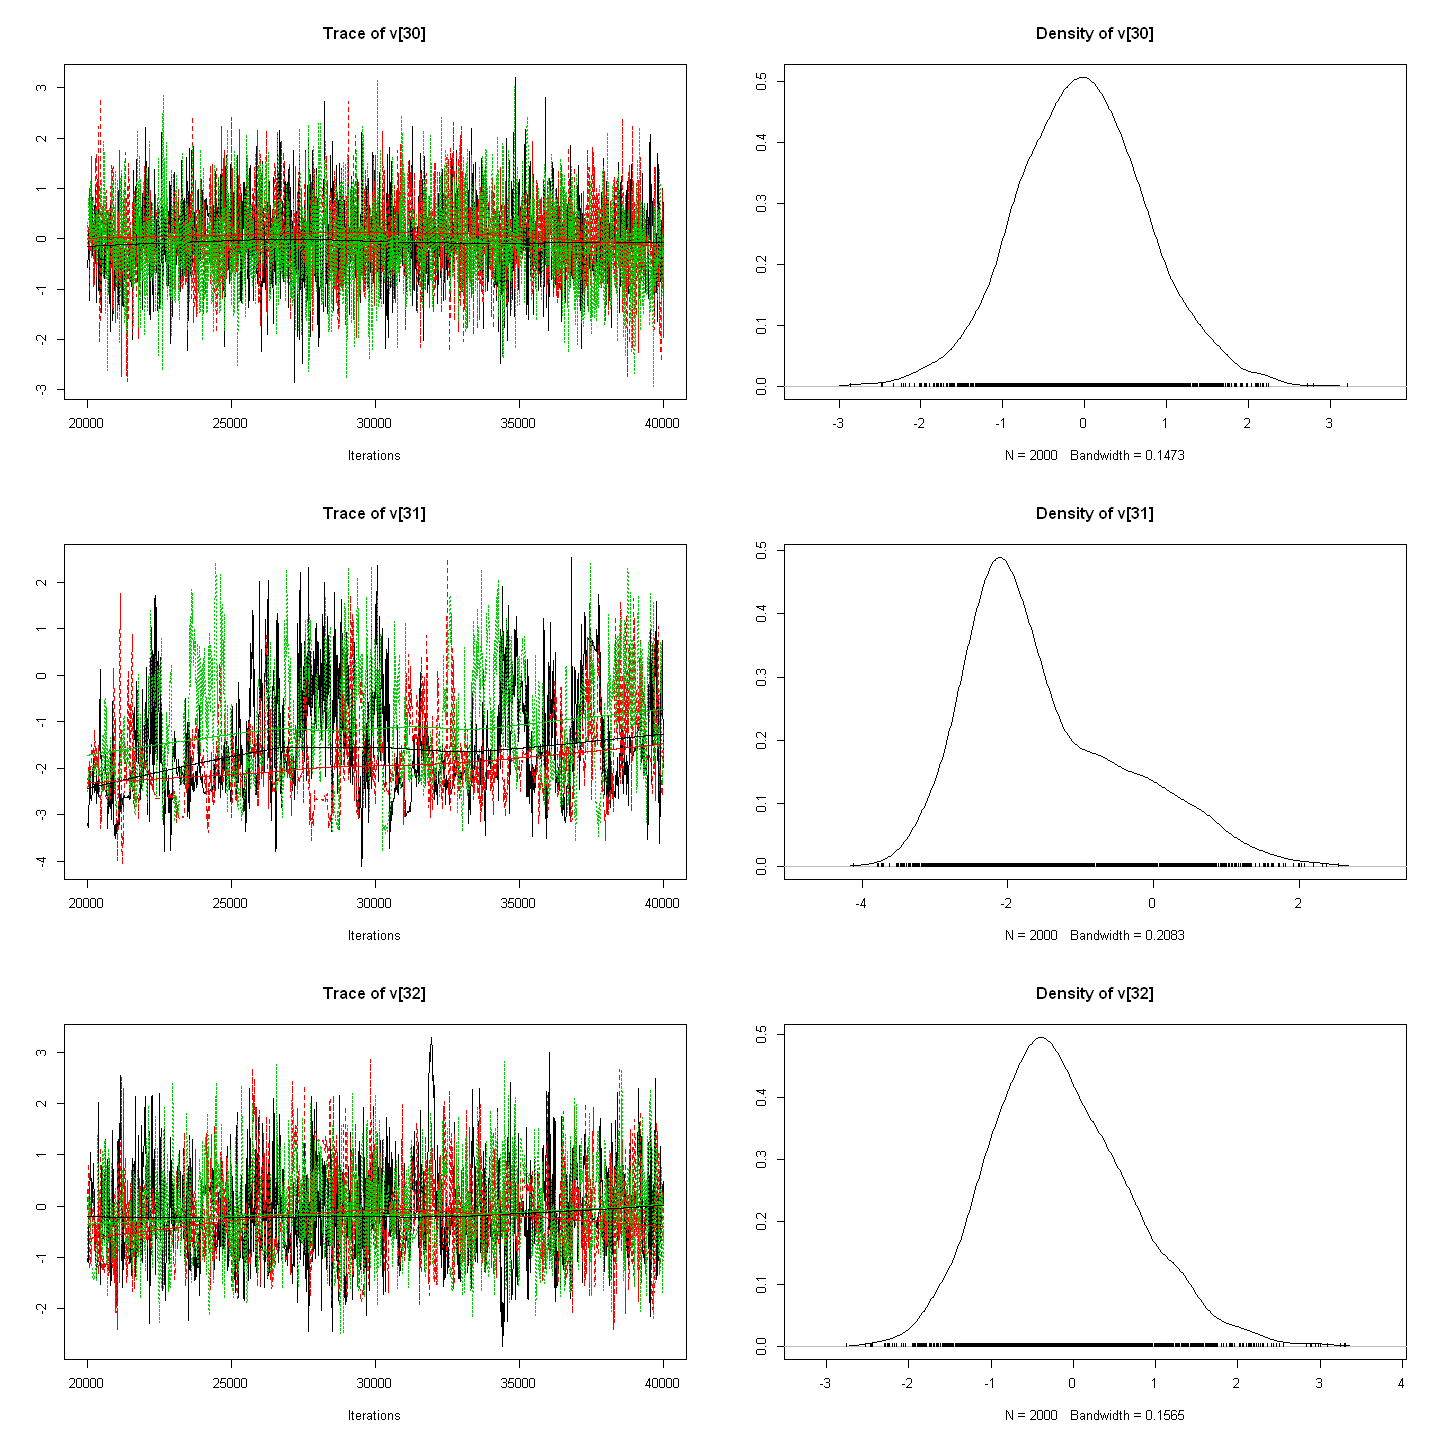

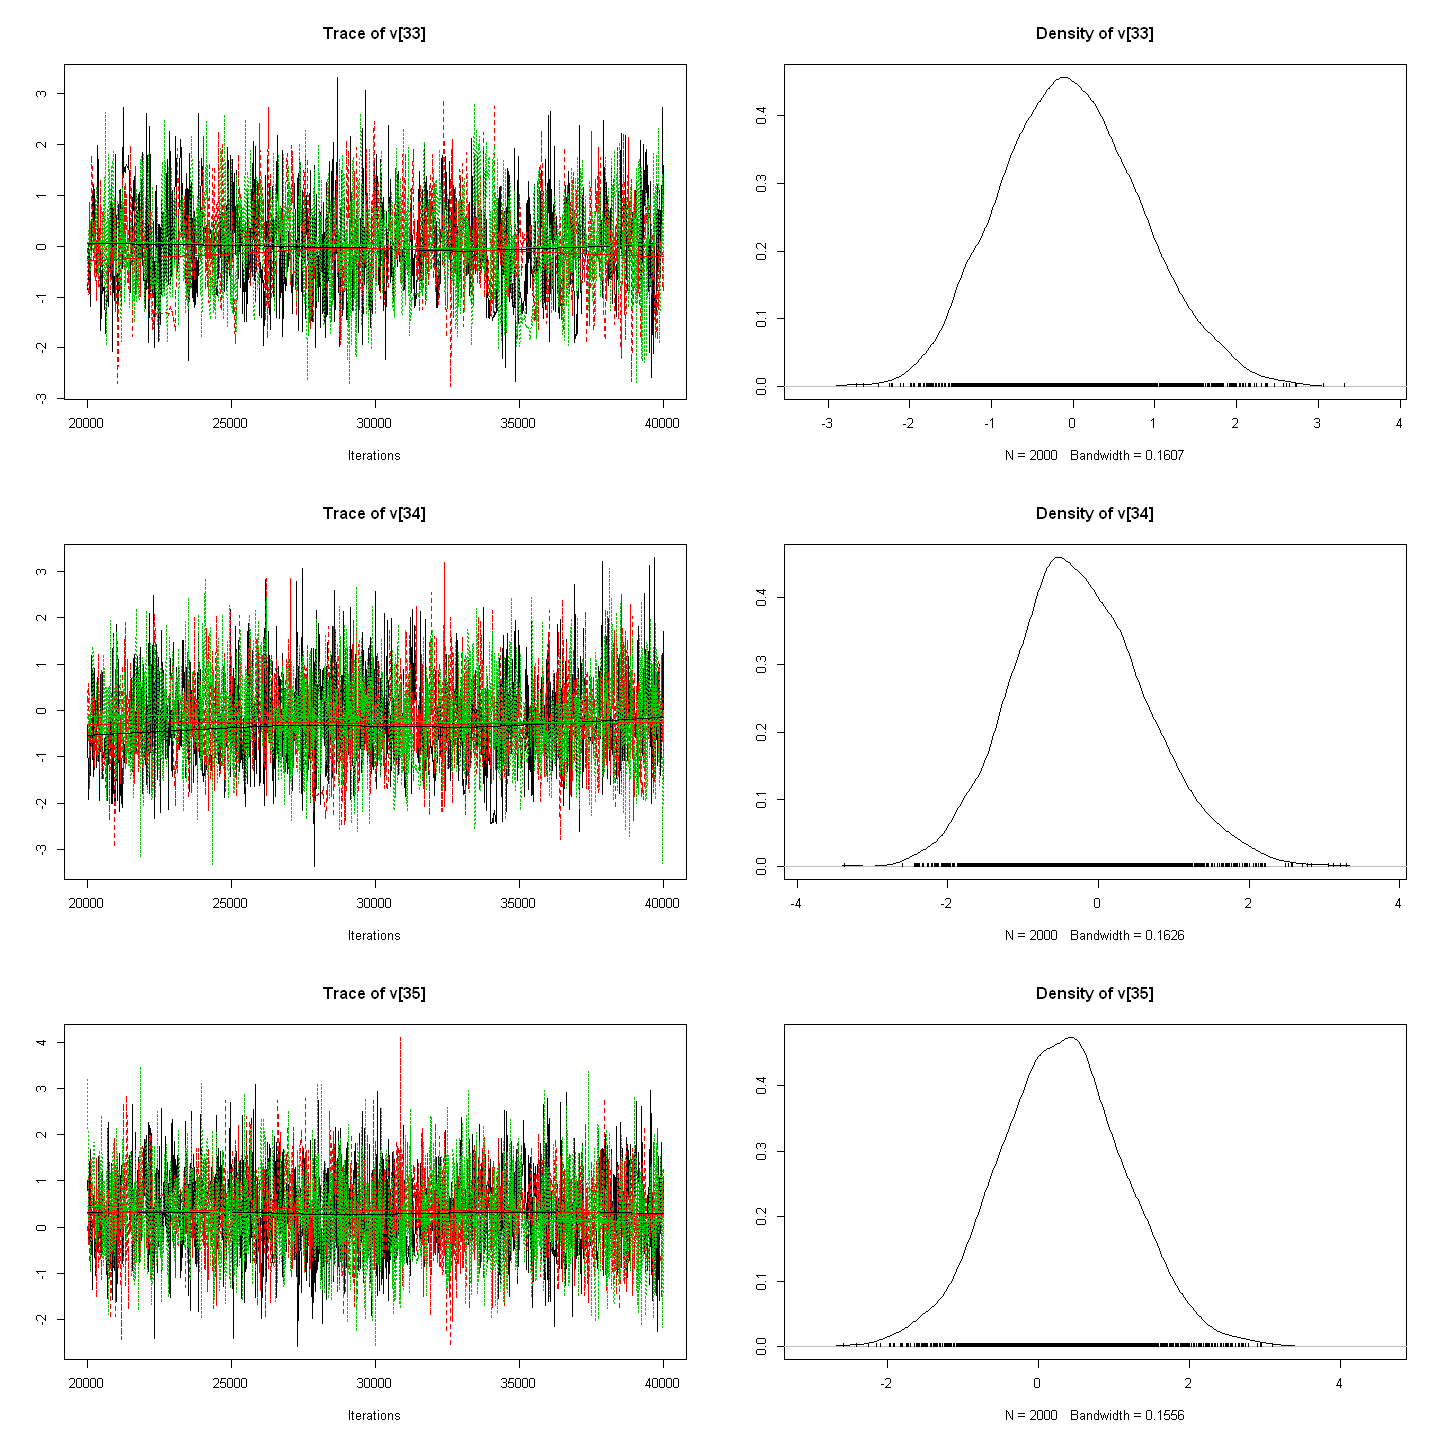

In [28]:
model2 <- jags.model(textConnection(mixed_glm),data=list(t=t,x=x,y=y,s=s),n.chains=3,n.adapt=10000)

#burnin for 10000 samples 
update(model2,10000)

#thinning
mcmc.shark2 <- coda.samples(model2, variable.names=c("a","b","c1","c2","sigma.a","sigma.b",
                                                    "sigma","u","v"), n.iter=20000, thin=10)
for(i in 1:26){
  plot(mcmc.shark2[,c(3*i-2,3*i-1,3*i)])
}

In [29]:
summary(mcmc.shark2)


Iterations = 20010:40000
Thinning interval = 10 
Number of chains = 3 
Sample size per chain = 2000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

              Mean       SD  Naive SE Time-series SE
a        2.846e+02  9.06371 0.1170120       1.094417
b        3.954e-01  0.05721 0.0007386       0.007951
c1      -1.054e+01 15.43842 0.1993091       1.960525
c2       1.300e-01  0.11246 0.0014518       0.012415
sigma    1.348e+00  1.20674 0.0155789       0.071625
sigma.a  2.087e+01  5.34624 0.0690197       0.420965
sigma.b  1.357e-01  0.03460 0.0004467       0.003566
u[1]    -6.328e-01  1.20953 0.0156149       0.074977
u[2]     2.354e-01  0.90035 0.0116234       0.017778
u[3]     6.662e-01  0.89973 0.0116155       0.036310
u[4]    -3.715e-01  0.93566 0.0120793       0.051187
u[5]     6.070e-02  0.69793 0.0090103       0.049369
u[6]     1.349e-01  0.85926 0.0110930       0.024615
u[7]     2.069e-01  0.86094 0.0111146       0.028506
u[8] 

### (d) GLMM : 성별 간 성장모수의 차이 검토

In [30]:
cbind(summary(mcmc.shark2)$statistics[c(3,4),1], summary(mcmc.shark2)$quantiles[c(3,4),c(1,5)])

2.5%          97.5%     
c1 -10.5413356 -42.378777377 19.0979219
c2   0.1300434   0.004882187  0.4112805

* c1은 신뢰구간에 0이 포함되지만, c2는 신뢰구간에 0이 포함되지 않는다. 
* 따라서 c1의 경우 유의미하지 않은 모수라고 할 수 있고, c2의 경우 유의미한 모수라고 생각할 수 있다.
* (그렇지만 c2의 경우 0과 매우 유사한 값을 나타내므로, 유의미한 모수라고 확신할 수 없는 것 같다.) 

### (e) Fixed vs Mixed 

* Fixed 모형(GLM)은 전체 모형의 평균적인 효과를 한 눈에 볼 수 있다. 
* Mixed 모형(GLMM)은 개체 별 특성을 고려해 줄 수 있다. (상어 별 특성) 

### (f) GLMM 에서의 random effect 비교 (ui, vi), (ai, bi)

In [31]:
abc1c2 <- summary(mcmc.shark2)$statistics[1:4,1]
sigma <- summary(mcmc.shark2)$statistics[5:7,1]

In [32]:
shark <- as_tibble(shark) %>% mutate(u=summary(mcmc.shark2)$statistics[8:43,1],v=summary(mcmc.shark2)$statistics[44:79,1],a=abc1c2[1]+u*sigma[1]+abc1c2[3]*Gender,b=abc1c2[2]+v*sigma[2]+abc1c2[4]*Gender)
shark

Sex Gender Days L1  L2  u           v             a        b           
1  F   0       392 108 131 -0.63280316 -1.7926993525 283.7802 -37.00997274
2  F   0        45 117 127  0.23544814  0.5457323605 284.9508  11.78237865
3  F   0        86 128 150  0.66623045  1.2885564328 285.5316  27.28171222
4  F   0       507 131 182 -0.37149843 -0.5004674573 284.1325 -10.04701618
5  F   0      1511 136 256  0.06069826  0.1399716158 284.7152   3.31601175
6  F   0       138 138 161  0.13494655  0.3840424140 284.8153   8.40865059
7  F   0       178 140 170  0.20685302  0.5254574292 284.9123  11.35933376
8  F   0       372 150 188 -0.27309618 -0.2416327208 284.2652  -4.64632162
9  F   0       182 151 176  0.01037243  0.2126778312 284.6474   4.83305721
10 F   0       515 159 222  0.30334821  0.5603766650 285.0423  12.08793816
11 F   0      1796 160 277  0.46298527  0.3938600054 285.2576   8.61349872
12 F   0        98 164 179  0.27927238  0.5322604522 285.0099  11.50128167
13 F   0       256 164 193  0.04897142  0.0618438013 284.6994   1.68584237
14 F   0      1090 170 245 -0.11731067  0.0007728347 284.4752   0.41157123
15 F   0       195 178 193 -0.36263447 -0.4673978589 284.1445  -9.35700524
16 F   0        76 179 185 -0.34447926 -0.4082622685 284.1690  -8.12311652
17 F   0       181 181 204  0.34832542  0.5795010096 285.1030  12.48697557
18 F   0       451 202 255  1.18483734  1.2075848571 286.2308  25.59220658
19 F   0       336 208 219 -0.84579899 -0.8157969626 283.4931 -16.62649760
20 F   0       296 210 221 -0.64520094 -0.7361462558 283.7635 -14.96455244
21 F   0        31 212 215  0.18488032  0.2474227479 284.8826   5.55802437
22 F   0      1248 214 249 -0.61537940 -0.4365916798 283.8037  -8.71422148
23 F   0       129 224 235  0.53535366  0.4951865424 285.3551  10.72771911
24 F   0        89 233 235 -0.59423307 -0.5139363494 283.8322 -10.32805022
25 F   0       154 249 251 -0.59467158 -0.4467542768 283.8316  -8.92626830
26 F   0       331 280 290  1.23041579  0.3460614922 286.2922   7.61616284
27 M   1       257  63 138  0.26983815  0.6575068772 274.4558  14.24464384
28 M   1      2421 136 257 -0.37388153 -0.1886442785 273.5880  -3.41065235
29 M   1       555 162 218 -0.19926681 -0.0528365809 273.8234  -0.57696820
30 M   1        28 164 168 -0.09711482 -0.0285364983 273.9611  -0.06993685
31 M   1       451 177 191 -1.30645704 -1.4764559553 272.3307 -30.28137922
32 M   1       402 221 241 -0.09962225 -0.1477505115 273.9577  -2.55738688
33 M   1       377 224 245  0.16373176 -0.0215477564 274.3128   0.07588615
34 M   1       176 229 237 -0.13875543 -0.2334465604 273.9050  -4.34547062
35 M   1       110 240 248  0.71877867  0.3036937874 275.0611   6.86218639
36 M   1       200 269 278  1.27921454  0.3705203411 275.8167   8.25655026

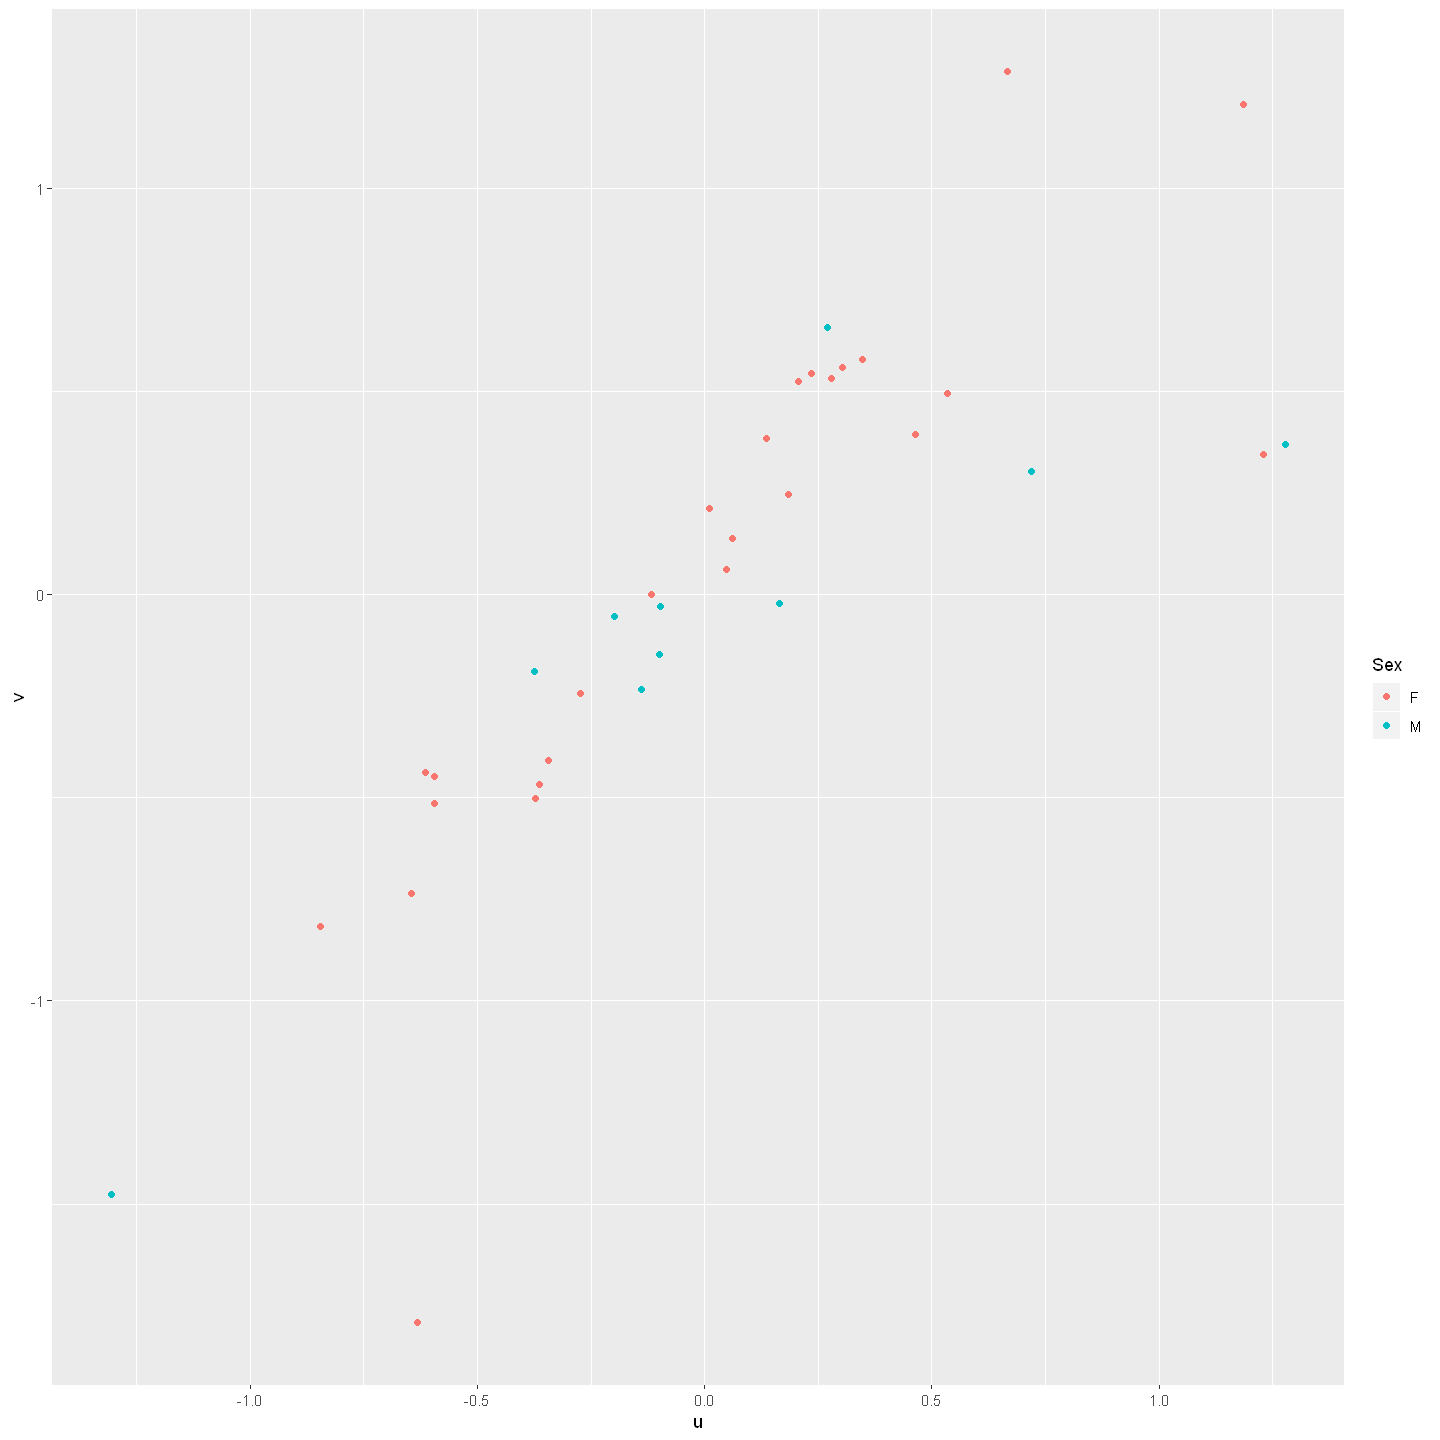

In [33]:
# (u,v)
ggplot(shark,aes(u,v))+geom_point(aes(colour=Sex))

* 두 요소의 상관성이 크다고 생각할 수 있다. 

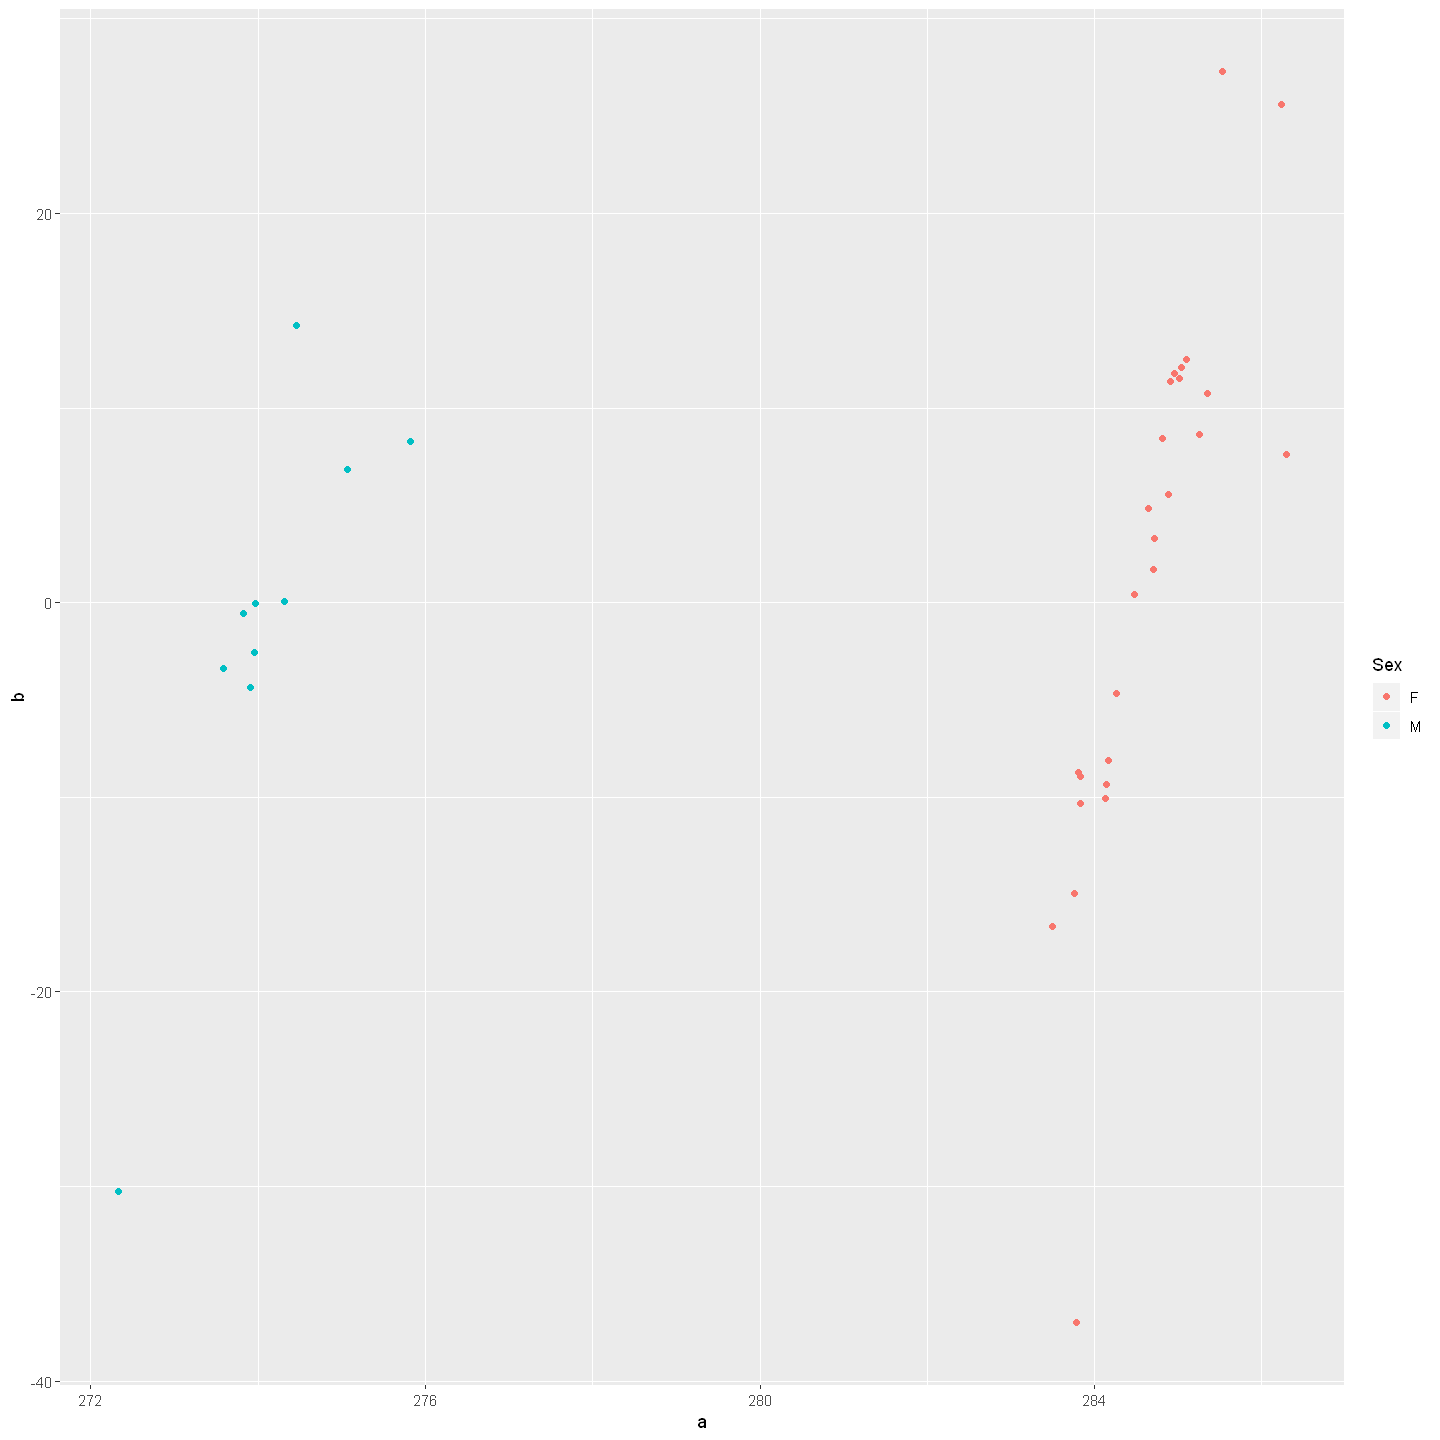

In [34]:
# (a,b)
ggplot(shark,aes(a,b))+geom_point(aes(colour=Sex))

* female의 최대 성장 길이가 크고, male은 환경적 요소의 영향을 많이 받는다. 
* 성별로 clustering이 가능하다.

### (g) 최대성장길이 예측 

In [35]:
which.max(shark$a) ; shark[which.max(shark$a),]

u[26] 
   26

Sex Gender Days L1  L2  u        v         a        b       
1 F   0      331  280 290 1.230416 0.3460615 286.2922 7.616163